# AIRR-ML-25: Adaptive Immune Profiling Challenge - EDA & Data Analysis

## Challenge Overview
**Objective:** Build ML models for two tasks:
1. **Predict immune state** (disease vs. healthy) from adaptive immune repertoires
2. **Identify immune receptor sequences** most strongly associated with the target immune state

## Notebook Structure
1. **Setup & Data Loading**
2. **Metadata Analysis** - Labels, demographics, class balance
3. **Sequence-Level Analysis** - junction_aa, v_call, j_call distributions
4. **Diversity Metrics** - Uniqueness, entropy, richness
5. **Technical Bias Check** - Batch effects across sequencing runs
6. **HLA Gene Analysis** - Allele prevalence and label associations
7. **Missing Values Assessment**
8. **Train vs Test Comparison**
9. **Dimensionality Reduction Visualization**

---

## 1. Setup & Configuration

In [1]:
# Core imports
import os
import glob
import warnings
from collections import Counter, defaultdict
from typing import Iterator, Tuple, Union, List, Optional, Dict

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Statistical analysis
from scipy import stats
from scipy.stats import entropy

# Progress bars
from tqdm.notebook import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 200)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# =============================================================================
# DATA PATHS CONFIGURATION
# =============================================================================
# Update these paths based on your environment (Kaggle vs Local)

# For Kaggle:
TRAIN_DIR = "/kaggle/input/adaptive-immune-profiling-challenge-2025/train_datasets/train_datasets"
TEST_DIR = "/kaggle/input/adaptive-immune-profiling-challenge-2025/test_datasets/test_datasets"

# For local testing (uncomment and modify if running locally):
# TRAIN_DIR = "/path/to/your/local/train_datasets"
# TEST_DIR = "/path/to/your/local/test_datasets"

# Check if running on Kaggle
IS_KAGGLE = os.path.exists("/kaggle/input")
print(f"Running on Kaggle: {IS_KAGGLE}")

# Verify paths exist
if IS_KAGGLE:
    if os.path.exists(TRAIN_DIR):
        train_datasets = sorted([d for d in os.listdir(TRAIN_DIR) if d.startswith("train_dataset_")])
        test_datasets = sorted([d for d in os.listdir(TEST_DIR) if d.startswith("test_dataset_")])
        print(f"\n📁 Found {len(train_datasets)} training datasets")
        print(f"📁 Found {len(test_datasets)} test datasets")
        print(f"\n🔹 Training datasets: {train_datasets[:5]}{'...' if len(train_datasets) > 5 else ''}")
        print(f"🔹 Test datasets: {test_datasets[:5]}{'...' if len(test_datasets) > 5 else ''}")
    else:
        print("⚠️ Data directory not found. Please check the path.")
else:
    print("⚠️ Not running on Kaggle. Update paths in the cell above for local execution.")

Running on Kaggle: True

📁 Found 8 training datasets
📁 Found 11 test datasets

🔹 Training datasets: ['train_dataset_1', 'train_dataset_2', 'train_dataset_3', 'train_dataset_4', 'train_dataset_5']...
🔹 Test datasets: ['test_dataset_1', 'test_dataset_2', 'test_dataset_3', 'test_dataset_4', 'test_dataset_5']...


## 2. Utility Functions for Data Loading

In [3]:
# =============================================================================
# DATA LOADING UTILITIES
# =============================================================================

def load_metadata(dataset_dir: str, metadata_filename: str = 'metadata.csv') -> Optional[pd.DataFrame]:
    """Load metadata.csv from a dataset directory."""
    metadata_path = os.path.join(dataset_dir, metadata_filename)
    if os.path.exists(metadata_path):
        return pd.read_csv(metadata_path)
    return None


def load_all_metadata(base_dir: str, dataset_prefix: str = "train_dataset_") -> pd.DataFrame:
    """Load and combine metadata from all datasets in a directory."""
    all_metadata = []
    datasets = sorted([d for d in os.listdir(base_dir) if d.startswith(dataset_prefix)])
    
    for dataset_name in tqdm(datasets, desc="Loading metadata"):
        dataset_path = os.path.join(base_dir, dataset_name)
        metadata = load_metadata(dataset_path)
        if metadata is not None:
            metadata['dataset'] = dataset_name
            all_metadata.append(metadata)
    
    if all_metadata:
        return pd.concat(all_metadata, ignore_index=True)
    return pd.DataFrame()


def load_repertoire(file_path: str) -> Optional[pd.DataFrame]:
    """Load a single repertoire TSV file."""
    try:
        return pd.read_csv(file_path, sep='\t')
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


def load_sample_repertoires(base_dir: str, dataset_name: str, n_samples: int = 5) -> Dict[str, pd.DataFrame]:
    """Load a sample of repertoire files from a dataset for quick analysis."""
    dataset_path = os.path.join(base_dir, dataset_name)
    tsv_files = glob.glob(os.path.join(dataset_path, "*.tsv"))[:n_samples]
    
    repertoires = {}
    for file_path in tsv_files:
        filename = os.path.basename(file_path)
        repertoires[filename] = load_repertoire(file_path)
    
    return repertoires


def get_repertoire_summary(dataset_path: str, sample_size: int = None) -> pd.DataFrame:
    """Get summary statistics for repertoires in a dataset."""
    metadata_path = os.path.join(dataset_path, 'metadata.csv')
    summaries = []
    
    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        files_to_process = metadata['filename'].tolist()
        if sample_size:
            files_to_process = files_to_process[:sample_size]
    else:
        files_to_process = glob.glob(os.path.join(dataset_path, "*.tsv"))
        if sample_size:
            files_to_process = files_to_process[:sample_size]
    
    for filename in tqdm(files_to_process, desc=f"Analyzing {os.path.basename(dataset_path)}", leave=False):
        if os.path.exists(metadata_path):
            file_path = os.path.join(dataset_path, filename)
        else:
            file_path = filename
            filename = os.path.basename(filename)
        
        repertoire = load_repertoire(file_path)
        if repertoire is not None:
            summary = {
                'filename': filename,
                'n_sequences': len(repertoire),
                'n_unique_junction_aa': repertoire['junction_aa'].nunique() if 'junction_aa' in repertoire.columns else 0,
                'n_unique_v_call': repertoire['v_call'].nunique() if 'v_call' in repertoire.columns else 0,
                'n_unique_j_call': repertoire['j_call'].nunique() if 'j_call' in repertoire.columns else 0,
                'has_d_call': 'd_call' in repertoire.columns,
                'has_templates': 'templates' in repertoire.columns or 'duplicate_count' in repertoire.columns,
                'columns': list(repertoire.columns)
            }
            
            if 'junction_aa' in repertoire.columns:
                seq_lengths = repertoire['junction_aa'].dropna().str.len()
                summary['mean_seq_length'] = seq_lengths.mean()
                summary['min_seq_length'] = seq_lengths.min()
                summary['max_seq_length'] = seq_lengths.max()
            
            summaries.append(summary)
    
    return pd.DataFrame(summaries)


print("✅ Utility functions defined!")

✅ Utility functions defined!


## 3. Metadata Analysis

### 3.1 Overview of All Datasets

In [4]:
# =============================================================================
# LOAD ALL TRAINING METADATA
# =============================================================================

# Load metadata from all training datasets
train_metadata = load_all_metadata(TRAIN_DIR, dataset_prefix="train_dataset_")

print("=" * 80)
print("TRAINING METADATA OVERVIEW")
print("=" * 80)
print(f"\n📊 Total repertoires (samples): {len(train_metadata):,}")
print(f"📁 Number of datasets: {train_metadata['dataset'].nunique()}")
print(f"\n📋 Available columns in metadata:")
for col in train_metadata.columns:
    non_null = train_metadata[col].notna().sum()
    unique = train_metadata[col].nunique()
    print(f"   • {col}: {non_null:,} non-null ({non_null/len(train_metadata)*100:.1f}%), {unique:,} unique values")

# Display sample of the data
print("\n" + "=" * 80)
print("SAMPLE DATA (first 10 rows)")
print("=" * 80)
display(train_metadata.head(10))

Loading metadata:   0%|          | 0/8 [00:00<?, ?it/s]

TRAINING METADATA OVERVIEW

📊 Total repertoires (samples): 3,610
📁 Number of datasets: 8

📋 Available columns in metadata:
   • repertoire_id: 3,610 non-null (100.0%), 3,610 unique values
   • filename: 3,610 non-null (100.0%), 3,610 unique values
   • label_positive: 3,610 non-null (100.0%), 2 unique values
   • dataset: 3,610 non-null (100.0%), 8 unique values
   • age: 1,210 non-null (33.5%), 927 unique values
   • sex: 1,209 non-null (33.5%), 4 unique values
   • race: 302 non-null (8.4%), 1 unique values
   • sequencing_run_id: 302 non-null (8.4%), 3 unique values
   • study_group_description: 908 non-null (25.2%), 4 unique values
   • A: 864 non-null (23.9%), 276 unique values
   • B: 864 non-null (23.9%), 488 unique values
   • C: 864 non-null (23.9%), 268 unique values
   • DPA1: 864 non-null (23.9%), 27 unique values
   • DPB1: 864 non-null (23.9%), 168 unique values
   • DQA1: 864 non-null (23.9%), 61 unique values
   • DQB1: 864 non-null (23.9%), 148 unique values
   • DRB1:

,repertoire_id,filename,label_positive,dataset,age,sex,race,sequencing_run_id,study_group_description,A,B,C,DPA1,DPB1,DQA1,DQB1,DRB1,DRB3,DRB4,DRB5
0,44967b361684556629a8b61288daf20c,44967b361684556629a8b61288daf20c.tsv,True,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36c146e43178cc60d3694117e85cf8f0,36c146e43178cc60d3694117e85cf8f0.tsv,False,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90e072812957e184a00d7dd6e6fc1113,90e072812957e184a00d7dd6e6fc1113.tsv,False,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e067bc70fd5eb332289ab527ee07b10e,e067bc70fd5eb332289ab527ee07b10e.tsv,True,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e23d10263fd2069cdf5d7033532d11ad,e23d10263fd2069cdf5d7033532d11ad.tsv,False,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,b7d83c8a21101191d966f4f4b77cbdd4,b7d83c8a21101191d966f4f4b77cbdd4.tsv,False,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,a7884f7b291d299c33b4842924b48cf9,a7884f7b291d299c33b4842924b48cf9.tsv,True,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,fa7de15e4bb7abd6155f9a2a7c0069ac,fa7de15e4bb7abd6155f9a2a7c0069ac.tsv,False,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,58b814b6ac61deba62daf1aa4982a9ac,58b814b6ac61deba62daf1aa4982a9ac.tsv,True,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,aeecf5fd37fa2f1120f1dce8042e1b8f,aeecf5fd37fa2f1120f1dce8042e1b8f.tsv,True,train_dataset_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Class Balance Analysis (Label Distribution)

OVERALL CLASS BALANCE

📈 Positive (Disease): 1,548 (42.9%)
📉 Negative (Healthy): 2,062 (57.1%)
⚖️  Imbalance Ratio: 1.33:1


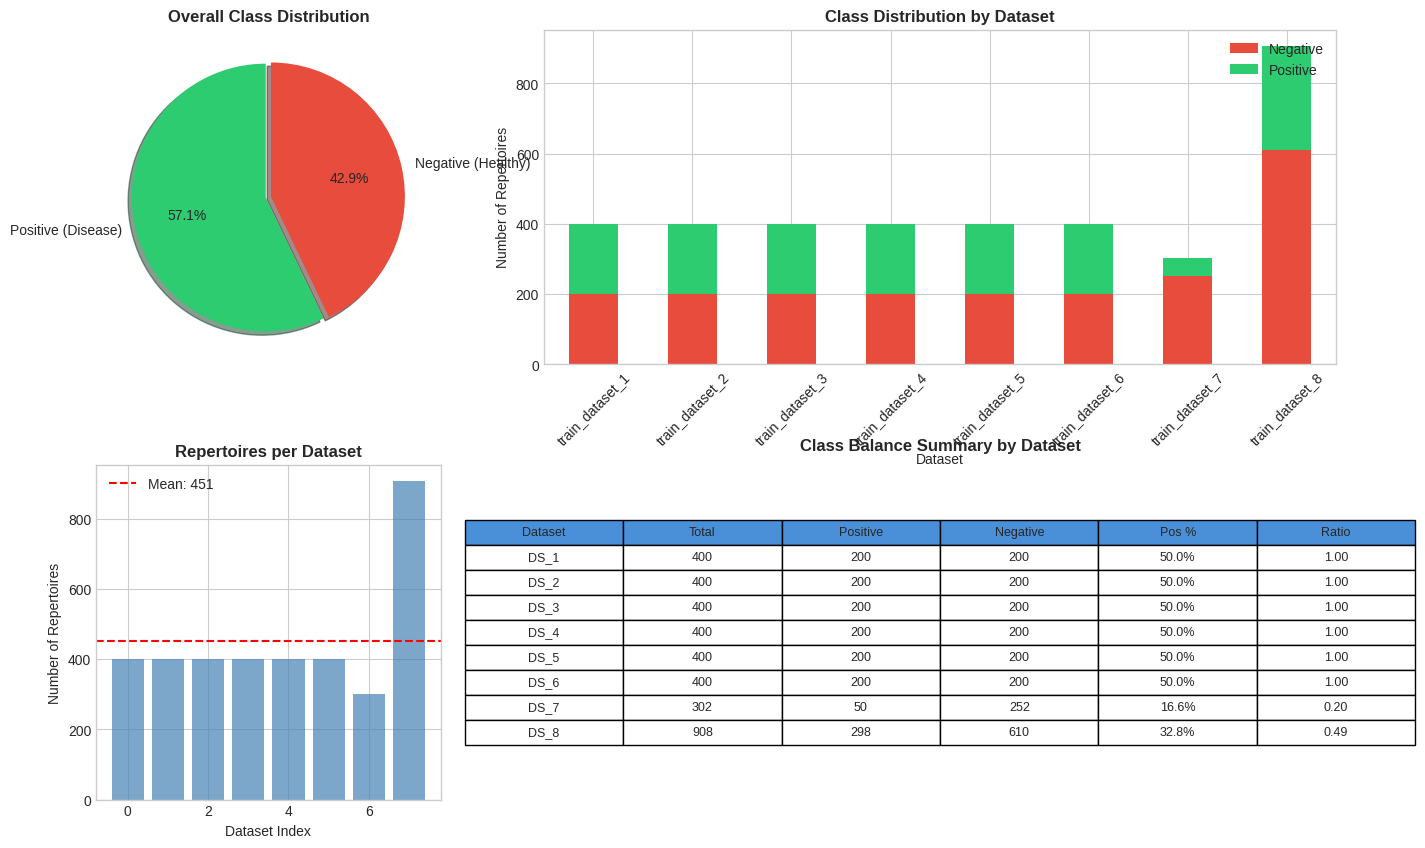


DETAILED CLASS BALANCE BY DATASET


,Dataset,Total,Positive,Negative,Pos %,Ratio
0,DS_1,400,200,200,50.0%,1.00
1,DS_2,400,200,200,50.0%,1.00
2,DS_3,400,200,200,50.0%,1.00
3,DS_4,400,200,200,50.0%,1.00
4,DS_5,400,200,200,50.0%,1.00
5,DS_6,400,200,200,50.0%,1.00
6,DS_7,302,50,252,16.6%,0.20
7,DS_8,908,298,610,32.8%,0.49


In [5]:
# =============================================================================
# CLASS BALANCE ANALYSIS
# =============================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# --- Overall class distribution ---
ax1 = fig.add_subplot(gs[0, 0])
if 'label_positive' in train_metadata.columns:
    class_counts = train_metadata['label_positive'].value_counts()
    colors = ['#2ecc71', '#e74c3c']  # Green for True, Red for False
    ax1.pie(class_counts, labels=['Positive (Disease)', 'Negative (Healthy)'], 
            autopct='%1.1f%%', colors=colors, explode=(0.02, 0.02),
            shadow=True, startangle=90)
    ax1.set_title('Overall Class Distribution', fontsize=12, fontweight='bold')
    
    print("=" * 80)
    print("OVERALL CLASS BALANCE")
    print("=" * 80)
    print(f"\n📈 Positive (Disease): {class_counts.get(True, 0):,} ({class_counts.get(True, 0)/len(train_metadata)*100:.1f}%)")
    print(f"📉 Negative (Healthy): {class_counts.get(False, 0):,} ({class_counts.get(False, 0)/len(train_metadata)*100:.1f}%)")
    print(f"⚖️  Imbalance Ratio: {max(class_counts)/min(class_counts):.2f}:1")

# --- Class distribution per dataset ---
ax2 = fig.add_subplot(gs[0, 1:])
if 'label_positive' in train_metadata.columns:
    dataset_class_counts = train_metadata.groupby(['dataset', 'label_positive']).size().unstack(fill_value=0)
    dataset_class_counts.plot(kind='bar', stacked=True, ax=ax2, color=['#e74c3c', '#2ecc71'])
    ax2.set_xlabel('Dataset', fontsize=10)
    ax2.set_ylabel('Number of Repertoires', fontsize=10)
    ax2.set_title('Class Distribution by Dataset', fontsize=12, fontweight='bold')
    ax2.legend(['Negative', 'Positive'], loc='upper right')
    ax2.tick_params(axis='x', rotation=45)

# --- Repertoires per dataset ---
ax3 = fig.add_subplot(gs[1, 0])
dataset_sizes = train_metadata['dataset'].value_counts().sort_index()
ax3.bar(range(len(dataset_sizes)), dataset_sizes.values, color='steelblue', alpha=0.7)
ax3.set_xlabel('Dataset Index', fontsize=10)
ax3.set_ylabel('Number of Repertoires', fontsize=10)
ax3.set_title('Repertoires per Dataset', fontsize=12, fontweight='bold')
ax3.axhline(y=dataset_sizes.mean(), color='red', linestyle='--', label=f'Mean: {dataset_sizes.mean():.0f}')
ax3.legend()

# --- Summary statistics table ---
ax4 = fig.add_subplot(gs[1, 1:])
ax4.axis('off')

if 'label_positive' in train_metadata.columns:
    summary_data = []
    for dataset in sorted(train_metadata['dataset'].unique()):
        ds_data = train_metadata[train_metadata['dataset'] == dataset]
        n_pos = ds_data['label_positive'].sum()
        n_neg = len(ds_data) - n_pos
        ratio = n_pos / n_neg if n_neg > 0 else float('inf')
        summary_data.append({
            'Dataset': dataset.replace('train_dataset_', 'DS_'),
            'Total': len(ds_data),
            'Positive': n_pos,
            'Negative': n_neg,
            'Pos %': f"{n_pos/len(ds_data)*100:.1f}%",
            'Ratio': f"{ratio:.2f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    table = ax4.table(cellText=summary_df.values,
                      colLabels=summary_df.columns,
                      loc='center',
                      cellLoc='center',
                      colColours=['#4a90d9']*len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax4.set_title('Class Balance Summary by Dataset', fontsize=12, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Detailed printout
print("\n" + "=" * 80)
print("DETAILED CLASS BALANCE BY DATASET")
print("=" * 80)
if 'label_positive' in train_metadata.columns:
    display(summary_df)

### 3.3 Demographic Features Analysis (Age, Sex, Race, etc.)

DEMOGRAPHIC FEATURES ANALYSIS

📋 Available demographic columns: ['age', 'sex', 'race']


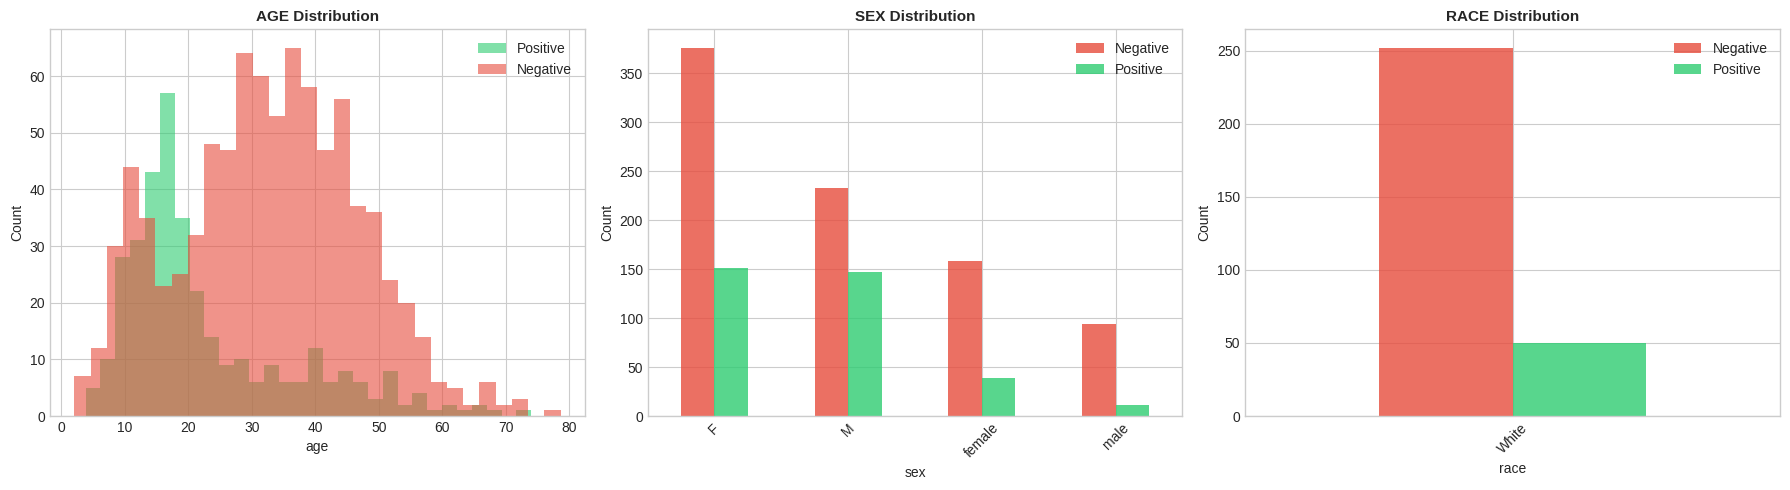


--------------------------------------------------------------------------------

📊 AGE Distribution:
count    1210.000000
mean       29.790905
std        14.637555
min         2.083504
25%        17.006845
50%        29.000000
75%        40.821355
max        78.598220
Name: age, dtype: float64
   Missing: 2400 (66.5%)

📊 SEX Distribution:
sex
F         527
M         380
female    197
male      105
Name: count, dtype: int64
   Missing: 2401 (66.5%)

📊 RACE Distribution:
race
White    302
Name: count, dtype: int64
   Missing: 3308 (91.6%)


In [6]:
# =============================================================================
# DEMOGRAPHIC FEATURES ANALYSIS
# =============================================================================

# Identify demographic columns
demographic_cols = ['age', 'sex', 'race', 'study_group', 'subject_id']
available_demo_cols = [col for col in demographic_cols if col in train_metadata.columns]

print("=" * 80)
print("DEMOGRAPHIC FEATURES ANALYSIS")
print("=" * 80)
print(f"\n📋 Available demographic columns: {available_demo_cols}")

if available_demo_cols:
    # Create visualizations for each demographic feature
    n_cols = min(3, len(available_demo_cols))
    n_rows = (len(available_demo_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, col in enumerate(available_demo_cols):
        row_idx, col_idx = idx // n_cols, idx % n_cols
        ax = axes[row_idx, col_idx]
        
        if train_metadata[col].dtype in ['float64', 'int64'] and train_metadata[col].nunique() > 10:
            # Continuous variable - histogram
            if 'label_positive' in train_metadata.columns:
                for label, color in [(True, '#2ecc71'), (False, '#e74c3c')]:
                    subset = train_metadata[train_metadata['label_positive'] == label][col].dropna()
                    ax.hist(subset, bins=30, alpha=0.6, label=f'{"Positive" if label else "Negative"}', color=color)
                ax.legend()
            else:
                ax.hist(train_metadata[col].dropna(), bins=30, alpha=0.7, color='steelblue')
            ax.set_xlabel(col, fontsize=10)
            ax.set_ylabel('Count', fontsize=10)
        else:
            # Categorical variable - bar chart
            if 'label_positive' in train_metadata.columns:
                cross_tab = pd.crosstab(train_metadata[col], train_metadata['label_positive'])
                cross_tab.plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'], alpha=0.8)
                ax.legend(['Negative', 'Positive'])
            else:
                train_metadata[col].value_counts().head(15).plot(kind='bar', ax=ax, color='steelblue', alpha=0.8)
            ax.set_xlabel(col, fontsize=10)
            ax.set_ylabel('Count', fontsize=10)
            ax.tick_params(axis='x', rotation=45)
        
        ax.set_title(f'{col.upper()} Distribution', fontsize=11, fontweight='bold')
    
    # Hide empty subplots
    for idx in range(len(available_demo_cols), n_rows * n_cols):
        row_idx, col_idx = idx // n_cols, idx % n_cols
        axes[row_idx, col_idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "-" * 80)
    for col in available_demo_cols:
        print(f"\n📊 {col.upper()} Distribution:")
        if train_metadata[col].dtype in ['float64', 'int64'] and train_metadata[col].nunique() > 10:
            print(train_metadata[col].describe())
        else:
            print(train_metadata[col].value_counts().head(10))
        print(f"   Missing: {train_metadata[col].isna().sum()} ({train_metadata[col].isna().sum()/len(train_metadata)*100:.1f}%)")
else:
    print("\n⚠️ No demographic columns found in metadata.")

### 3.4 Feature Correlations with Target Label

CORRELATION ANALYSIS WITH TARGET LABEL (label_positive)


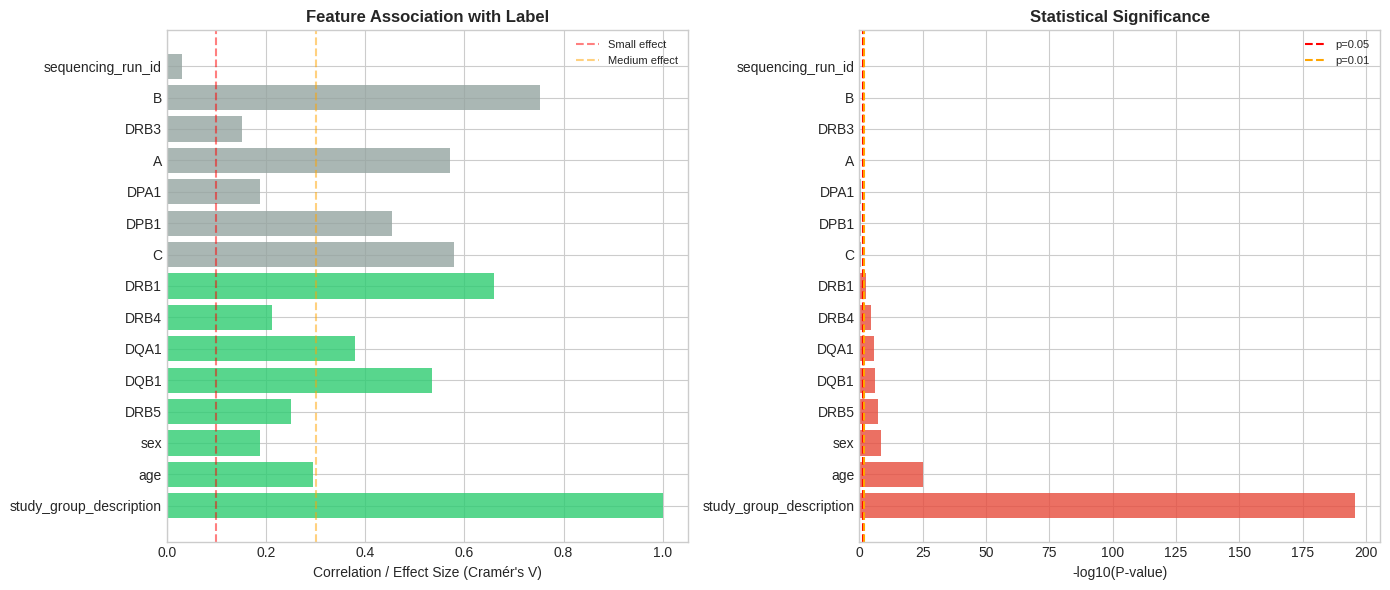


📊 Correlation Analysis Results (sorted by significance):


,Feature,Type,Correlation,Test,Statistic,P-value,Significant
3,study_group_description,Categorical,1.0000,Chi-squared,908.00,1.63e-196,True
0,age,Continuous,-0.2948,t-test,-10.72,1.09e-25,True
1,sex,Categorical,0.1888,Chi-squared,43.10,2.34e-09,True
14,DRB5,Categorical,0.2512,Chi-squared,54.53,3.86e-08,True
10,DQB1,Categorical,0.5341,Chi-squared,246.45,5.20e-07,True
9,DQA1,Categorical,0.3799,Chi-squared,124.69,1.94e-06,True
13,DRB4,Categorical,0.2118,Chi-squared,38.74,2.81e-05,True
11,DRB1,Categorical,0.6598,Chi-squared,376.12,3.38e-03,True
6,C,Categorical,0.5797,Chi-squared,290.34,1.56e-01,False
8,DPB1,Categorical,0.4549,Chi-squared,178.80,2.52e-01,False


In [7]:
# =============================================================================
# CORRELATION ANALYSIS WITH TARGET LABEL
# =============================================================================

print("=" * 80)
print("CORRELATION ANALYSIS WITH TARGET LABEL (label_positive)")
print("=" * 80)

if 'label_positive' in train_metadata.columns:
    # Convert label to numeric for correlation
    train_metadata['label_numeric'] = train_metadata['label_positive'].astype(int)
    
    correlation_results = []
    
    # Analyze each column
    for col in train_metadata.columns:
        if col in ['label_positive', 'label_numeric', 'repertoire_id', 'filename', 'dataset']:
            continue
        
        col_data = train_metadata[col].dropna()
        if len(col_data) < 10:
            continue
        
        try:
            if train_metadata[col].dtype in ['float64', 'int64']:
                # Continuous: Pearson correlation + t-test
                valid_mask = train_metadata[col].notna()
                correlation = train_metadata.loc[valid_mask, col].corr(train_metadata.loc[valid_mask, 'label_numeric'])
                
                # T-test between groups
                pos_vals = train_metadata[train_metadata['label_positive'] == True][col].dropna()
                neg_vals = train_metadata[train_metadata['label_positive'] == False][col].dropna()
                if len(pos_vals) > 1 and len(neg_vals) > 1:
                    t_stat, p_val = stats.ttest_ind(pos_vals, neg_vals)
                else:
                    t_stat, p_val = np.nan, np.nan
                
                correlation_results.append({
                    'Feature': col,
                    'Type': 'Continuous',
                    'Correlation': correlation,
                    'Test': 't-test',
                    'Statistic': t_stat,
                    'P-value': p_val,
                    'Significant': p_val < 0.05 if not np.isnan(p_val) else False
                })
            else:
                # Categorical: Chi-squared test
                contingency = pd.crosstab(train_metadata[col], train_metadata['label_positive'])
                if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                    chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
                    
                    # Cramér's V for effect size
                    n = contingency.sum().sum()
                    min_dim = min(contingency.shape) - 1
                    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
                    
                    correlation_results.append({
                        'Feature': col,
                        'Type': 'Categorical',
                        'Correlation': cramers_v,
                        'Test': 'Chi-squared',
                        'Statistic': chi2,
                        'P-value': p_val,
                        'Significant': p_val < 0.05
                    })
        except Exception as e:
            print(f"   Could not analyze {col}: {e}")
            continue
    
    if correlation_results:
        corr_df = pd.DataFrame(correlation_results).sort_values('P-value')
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Correlation/Effect size bar chart
        ax1 = axes[0]
        colors = ['#2ecc71' if sig else '#95a5a1' for sig in corr_df['Significant']]
        bars = ax1.barh(corr_df['Feature'], corr_df['Correlation'].abs(), color=colors, alpha=0.8)
        ax1.set_xlabel('Correlation / Effect Size (Cramér\'s V)', fontsize=10)
        ax1.set_title('Feature Association with Label', fontsize=12, fontweight='bold')
        ax1.axvline(x=0.1, color='red', linestyle='--', alpha=0.5, label='Small effect')
        ax1.axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Medium effect')
        ax1.legend(fontsize=8)
        
        # P-value bar chart (log scale)
        ax2 = axes[1]
        log_pvals = -np.log10(corr_df['P-value'].replace(0, 1e-300))
        colors = ['#e74c3c' if sig else '#95a5a1' for sig in corr_df['Significant']]
        ax2.barh(corr_df['Feature'], log_pvals, color=colors, alpha=0.8)
        ax2.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
        ax2.axvline(x=-np.log10(0.01), color='orange', linestyle='--', label='p=0.01')
        ax2.set_xlabel('-log10(P-value)', fontsize=10)
        ax2.set_title('Statistical Significance', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Display results table
        print("\n📊 Correlation Analysis Results (sorted by significance):")
        display(corr_df.style.format({
            'Correlation': '{:.4f}',
            'Statistic': '{:.2f}',
            'P-value': '{:.2e}'
        }).applymap(lambda x: 'background-color: #d4edda' if x == True else '', subset=['Significant']))
    
    # Clean up
    train_metadata.drop('label_numeric', axis=1, inplace=True)
else:
    print("⚠️ label_positive column not found in metadata.")

## 4. Sequence-Level Analysis

### 4.1 Repertoire Structure Overview

In [8]:
# =============================================================================
# REPERTOIRE STRUCTURE OVERVIEW
# =============================================================================
# Analyze repertoire files from a sample of datasets to understand structure

print("=" * 80)
print("REPERTOIRE STRUCTURE OVERVIEW")
print("=" * 80)

# Get list of training datasets
train_datasets = sorted([d for d in os.listdir(TRAIN_DIR) if d.startswith("train_dataset_")])

# Analyze structure from first dataset
sample_dataset = train_datasets[0]
sample_dataset_path = os.path.join(TRAIN_DIR, sample_dataset)

# Load a sample repertoire to examine structure
sample_files = glob.glob(os.path.join(sample_dataset_path, "*.tsv"))[:1]
if sample_files:
    sample_rep = pd.read_csv(sample_files[0], sep='\t')
    
    print(f"\n📁 Sample dataset: {sample_dataset}")
    print(f"📄 Sample file: {os.path.basename(sample_files[0])}")
    print(f"\n📋 Columns in repertoire files:")
    for col in sample_rep.columns:
        dtype = sample_rep[col].dtype
        n_unique = sample_rep[col].nunique()
        n_null = sample_rep[col].isna().sum()
        print(f"   • {col}: {dtype} | {n_unique:,} unique | {n_null} null")
    
    print(f"\n📊 Sample repertoire shape: {sample_rep.shape}")
    print(f"   • Rows (sequences): {len(sample_rep):,}")
    print(f"   • Columns: {len(sample_rep.columns)}")
    
    print("\n" + "=" * 80)
    print("SAMPLE REPERTOIRE DATA (first 10 rows)")
    print("=" * 80)
    display(sample_rep.head(10))

REPERTOIRE STRUCTURE OVERVIEW

📁 Sample dataset: train_dataset_1
📄 Sample file: 2c65ef1f4fd1744fc8177cc73f63f589.tsv

📋 Columns in repertoire files:
   • junction_aa: object | 24,984 unique | 0 null
   • v_call: object | 53 unique | 0 null
   • j_call: object | 13 unique | 0 null

📊 Sample repertoire shape: (25000, 3)
   • Rows (sequences): 25,000
   • Columns: 3

SAMPLE REPERTOIRE DATA (first 10 rows)


,junction_aa,v_call,j_call
0,CASSLGGQGVSANEKLFF,TRBV5-6,TRBJ1-4
1,CASSYRTGLVNTEAFF,TRBV7-2,TRBJ1-1
2,CASSHDVRVGGYTF,TRBV6-5,TRBJ1-2
3,CASRPVGAHTEAFF,TRBV28,TRBJ1-1
4,CASSPVAGGGRIGAGNTIYF,TRBV27,TRBJ1-3
5,CASSPYLSDGYTF,TRBV7,TRBJ1-2
6,CAWSVQKGGGYTF,TRBV30,TRBJ1-2
7,CATSEGVRSEAFF,TRBV24-1,TRBJ1-1
8,CASTEGGNTEAFF,TRBV6,TRBJ1-1
9,CASSRRAGPLAKNIQYF,TRBV3-1,TRBJ2-4


### 4.2 Repertoire Size Distribution

REPERTOIRE SIZE DISTRIBUTION


Analyzing repertoire sizes:   0%|          | 0/8 [00:00<?, ?it/s]


📊 Analyzed 400 repertoires across 8 datasets


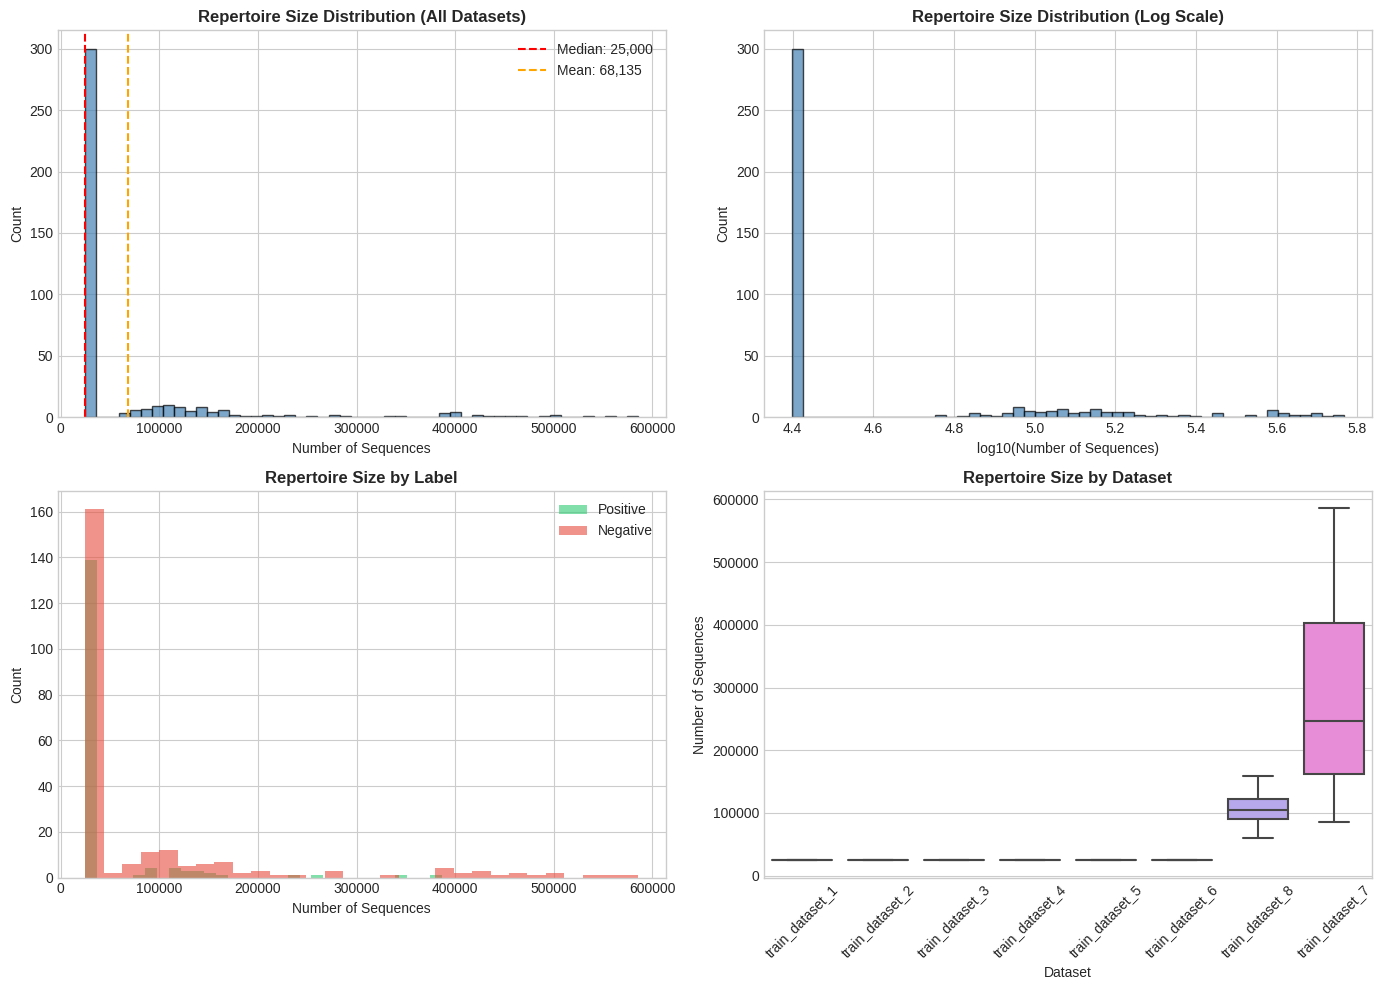


📈 Repertoire Size Statistics:
count       400.00000
mean      68134.52500
std      101532.10845
min       25000.00000
25%       25000.00000
50%       25000.00000
75%       33731.00000
max      585502.00000
Name: n_sequences, dtype: float64

📊 Size Statistics by Label:


,count,mean,std,min,25%,50%,75%,max
label_positive,,,,,,,,
False,239.0,85231.841004,120919.57263,25000.0,25000.0,25000.0,97662.5,585502.0
True,161.0,42754.037267,53601.32444,25000.0,25000.0,25000.0,25000.0,387016.0


In [9]:
# =============================================================================
# REPERTOIRE SIZE DISTRIBUTION ANALYSIS
# =============================================================================

def get_repertoire_sizes(base_dir: str, datasets: list, sample_per_dataset: int = None) -> pd.DataFrame:
    """Get the number of sequences per repertoire across datasets."""
    sizes = []
    
    for dataset_name in tqdm(datasets, desc="Analyzing repertoire sizes"):
        dataset_path = os.path.join(base_dir, dataset_name)
        metadata_path = os.path.join(dataset_path, 'metadata.csv')
        
        if os.path.exists(metadata_path):
            metadata = pd.read_csv(metadata_path)
            files_to_check = metadata['filename'].tolist()
            labels = dict(zip(metadata['filename'], metadata['label_positive']))
        else:
            files_to_check = [os.path.basename(f) for f in glob.glob(os.path.join(dataset_path, "*.tsv"))]
            labels = {}
        
        if sample_per_dataset:
            files_to_check = files_to_check[:sample_per_dataset]
        
        for filename in files_to_check:
            file_path = os.path.join(dataset_path, filename)
            if os.path.exists(file_path):
                try:
                    # Just count lines without loading full file for efficiency
                    with open(file_path, 'r') as f:
                        n_lines = sum(1 for _ in f) - 1  # Subtract header
                    
                    sizes.append({
                        'dataset': dataset_name,
                        'filename': filename,
                        'n_sequences': n_lines,
                        'label_positive': labels.get(filename, None)
                    })
                except Exception as e:
                    continue
    
    return pd.DataFrame(sizes)

# Get repertoire sizes (sample for speed)
print("=" * 80)
print("REPERTOIRE SIZE DISTRIBUTION")
print("=" * 80)

repertoire_sizes = get_repertoire_sizes(TRAIN_DIR, train_datasets, sample_per_dataset=50)

if not repertoire_sizes.empty:
    print(f"\n📊 Analyzed {len(repertoire_sizes):,} repertoires across {repertoire_sizes['dataset'].nunique()} datasets")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Overall distribution
    ax1 = axes[0, 0]
    ax1.hist(repertoire_sizes['n_sequences'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axvline(repertoire_sizes['n_sequences'].median(), color='red', linestyle='--', 
                label=f'Median: {repertoire_sizes["n_sequences"].median():,.0f}')
    ax1.axvline(repertoire_sizes['n_sequences'].mean(), color='orange', linestyle='--', 
                label=f'Mean: {repertoire_sizes["n_sequences"].mean():,.0f}')
    ax1.set_xlabel('Number of Sequences', fontsize=10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.set_title('Repertoire Size Distribution (All Datasets)', fontsize=12, fontweight='bold')
    ax1.legend()
    
    # Log scale distribution
    ax2 = axes[0, 1]
    ax2.hist(np.log10(repertoire_sizes['n_sequences'] + 1), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('log10(Number of Sequences)', fontsize=10)
    ax2.set_ylabel('Count', fontsize=10)
    ax2.set_title('Repertoire Size Distribution (Log Scale)', fontsize=12, fontweight='bold')
    
    # Distribution by label
    ax3 = axes[1, 0]
    if repertoire_sizes['label_positive'].notna().any():
        for label, color in [(True, '#2ecc71'), (False, '#e74c3c')]:
            subset = repertoire_sizes[repertoire_sizes['label_positive'] == label]['n_sequences']
            if len(subset) > 0:
                ax3.hist(subset, bins=30, alpha=0.6, label=f'{"Positive" if label else "Negative"}', color=color)
        ax3.legend()
    ax3.set_xlabel('Number of Sequences', fontsize=10)
    ax3.set_ylabel('Count', fontsize=10)
    ax3.set_title('Repertoire Size by Label', fontsize=12, fontweight='bold')
    
    # Box plot by dataset
    ax4 = axes[1, 1]
    dataset_order = repertoire_sizes.groupby('dataset')['n_sequences'].median().sort_values().index
    sns.boxplot(data=repertoire_sizes, x='dataset', y='n_sequences', ax=ax4, order=dataset_order)
    ax4.set_xlabel('Dataset', fontsize=10)
    ax4.set_ylabel('Number of Sequences', fontsize=10)
    ax4.set_title('Repertoire Size by Dataset', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📈 Repertoire Size Statistics:")
    print(repertoire_sizes['n_sequences'].describe())
    
    if repertoire_sizes['label_positive'].notna().any():
        print("\n📊 Size Statistics by Label:")
        display(repertoire_sizes.groupby('label_positive')['n_sequences'].describe())

### 4.3 Junction AA Sequence Analysis

JUNCTION_AA SEQUENCE ANALYSIS
✅ Analyzed train_dataset_1
✅ Analyzed train_dataset_2
✅ Analyzed train_dataset_3


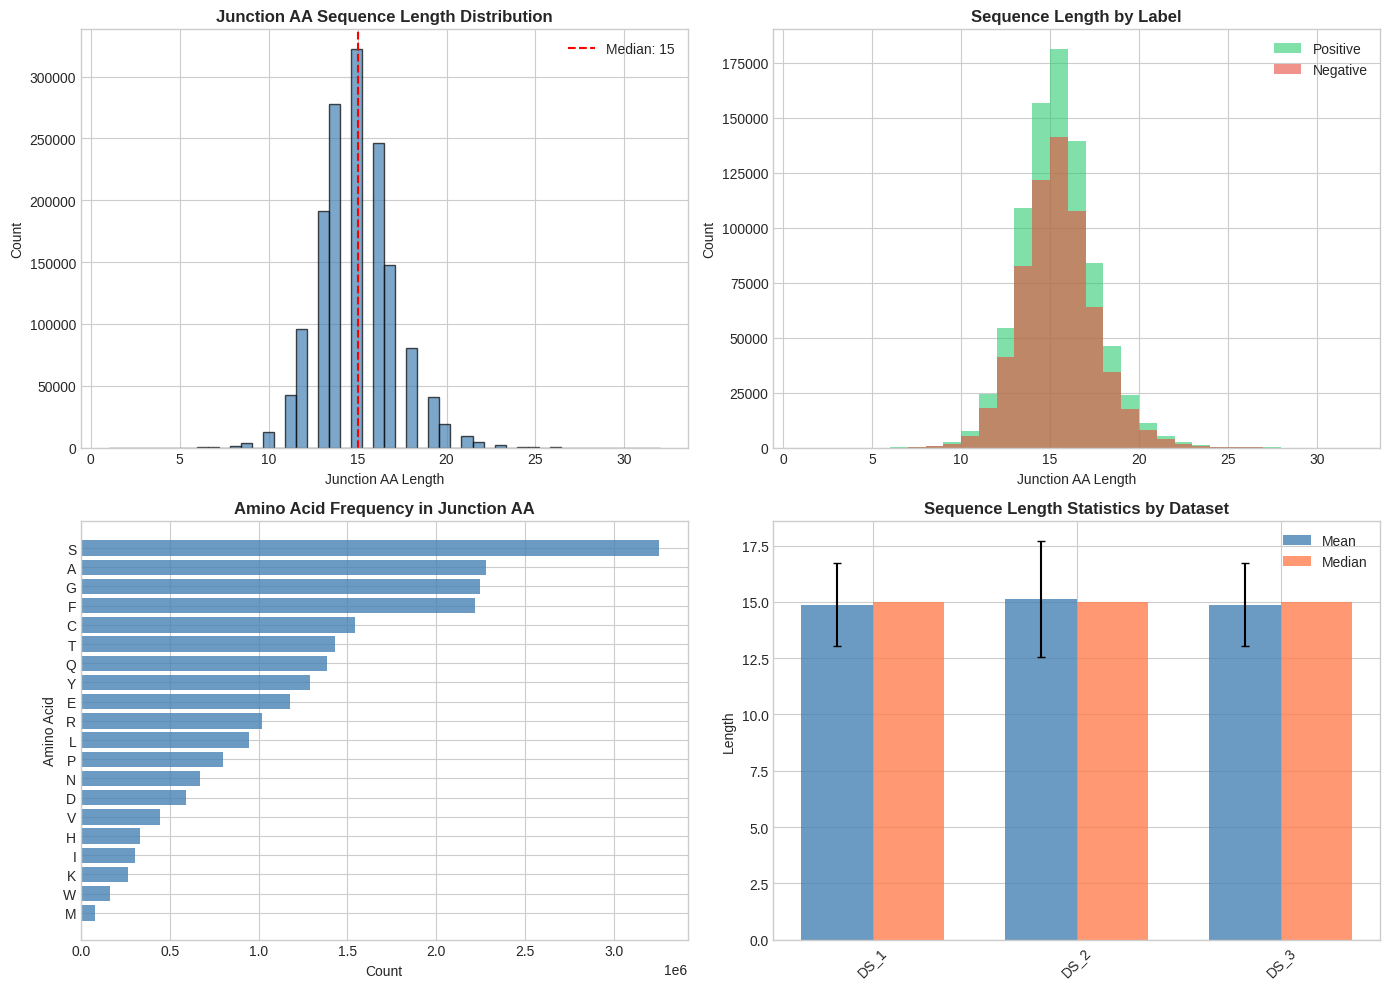


📊 Junction AA Length Statistics:
count    1.500000e+06
mean     1.496278e+01
std      2.107257e+00
min      1.000000e+00
25%      1.400000e+01
50%      1.500000e+01
75%      1.600000e+01
max      3.200000e+01
Name: length, dtype: float64

📊 Top 10 Most Common Amino Acids:
     count
R  1019609
E  1177948
Y  1287636
Q  1385803
T  1430542
C  1540178
F  2220595
G  2245221
A  2282887
S  3252398


In [10]:
# =============================================================================
# JUNCTION_AA SEQUENCE ANALYSIS
# =============================================================================

def analyze_sequences_from_dataset(dataset_path: str, n_files: int = 10) -> Dict:
    """Analyze junction_aa sequences from a sample of repertoire files."""
    metadata_path = os.path.join(dataset_path, 'metadata.csv')
    
    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        files = metadata['filename'].tolist()[:n_files]
        labels = dict(zip(metadata['filename'], metadata['label_positive']))
    else:
        files = [os.path.basename(f) for f in glob.glob(os.path.join(dataset_path, "*.tsv"))[:n_files]]
        labels = {}
    
    all_seq_lengths = []
    all_sequences = []
    amino_acid_counts = Counter()
    
    for filename in files:
        file_path = os.path.join(dataset_path, filename)
        if os.path.exists(file_path):
            rep = pd.read_csv(file_path, sep='\t')
            if 'junction_aa' in rep.columns:
                seqs = rep['junction_aa'].dropna()
                all_sequences.extend(seqs.tolist())
                
                lengths = seqs.str.len()
                label = labels.get(filename, None)
                for length in lengths:
                    all_seq_lengths.append({'length': length, 'label': label})
                
                # Count amino acids
                for seq in seqs:
                    amino_acid_counts.update(seq)
    
    return {
        'seq_lengths': pd.DataFrame(all_seq_lengths),
        'sequences': all_sequences,
        'amino_acid_counts': amino_acid_counts
    }

print("=" * 80)
print("JUNCTION_AA SEQUENCE ANALYSIS")
print("=" * 80)

# Analyze sequences from first few datasets
sequence_analysis = {}
for dataset_name in train_datasets[:3]:
    dataset_path = os.path.join(TRAIN_DIR, dataset_name)
    sequence_analysis[dataset_name] = analyze_sequences_from_dataset(dataset_path, n_files=20)
    print(f"✅ Analyzed {dataset_name}")

# Combine results
all_lengths = pd.concat([sa['seq_lengths'] for sa in sequence_analysis.values()], ignore_index=True)
all_aa_counts = Counter()
for sa in sequence_analysis.values():
    all_aa_counts.update(sa['amino_acid_counts'])

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sequence length distribution
ax1 = axes[0, 0]
ax1.hist(all_lengths['length'].dropna(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(all_lengths['length'].median(), color='red', linestyle='--', 
            label=f'Median: {all_lengths["length"].median():.0f}')
ax1.set_xlabel('Junction AA Length', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Junction AA Sequence Length Distribution', fontsize=12, fontweight='bold')
ax1.legend()

# Length by label
ax2 = axes[0, 1]
if all_lengths['label'].notna().any():
    for label, color in [(True, '#2ecc71'), (False, '#e74c3c')]:
        subset = all_lengths[all_lengths['label'] == label]['length']
        if len(subset) > 0:
            ax2.hist(subset, bins=30, alpha=0.6, label=f'{"Positive" if label else "Negative"}', color=color)
    ax2.legend()
ax2.set_xlabel('Junction AA Length', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('Sequence Length by Label', fontsize=12, fontweight='bold')

# Amino acid frequency
ax3 = axes[1, 0]
aa_df = pd.DataFrame.from_dict(all_aa_counts, orient='index', columns=['count']).sort_values('count', ascending=True)
# Filter to standard amino acids
standard_aa = list('ACDEFGHIKLMNPQRSTVWY')
aa_df_filtered = aa_df[aa_df.index.isin(standard_aa)].sort_values('count', ascending=True)
ax3.barh(aa_df_filtered.index, aa_df_filtered['count'], color='steelblue', alpha=0.8)
ax3.set_xlabel('Count', fontsize=10)
ax3.set_ylabel('Amino Acid', fontsize=10)
ax3.set_title('Amino Acid Frequency in Junction AA', fontsize=12, fontweight='bold')

# Length statistics by dataset
ax4 = axes[1, 1]
length_stats = []
for dataset_name, sa in sequence_analysis.items():
    lengths = sa['seq_lengths']['length']
    length_stats.append({
        'Dataset': dataset_name.replace('train_dataset_', 'DS_'),
        'Mean': lengths.mean(),
        'Median': lengths.median(),
        'Std': lengths.std()
    })
length_df = pd.DataFrame(length_stats)
x = np.arange(len(length_df))
width = 0.35
ax4.bar(x - width/2, length_df['Mean'], width, label='Mean', color='steelblue', alpha=0.8)
ax4.bar(x + width/2, length_df['Median'], width, label='Median', color='coral', alpha=0.8)
ax4.errorbar(x - width/2, length_df['Mean'], yerr=length_df['Std'], fmt='none', color='black', capsize=3)
ax4.set_xticks(x)
ax4.set_xticklabels(length_df['Dataset'], rotation=45)
ax4.set_ylabel('Length', fontsize=10)
ax4.set_title('Sequence Length Statistics by Dataset', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Junction AA Length Statistics:")
print(all_lengths['length'].describe())

print("\n📊 Top 10 Most Common Amino Acids:")
print(aa_df_filtered.tail(10))

### 4.4 V/J/D Gene Call Distribution

V/J/D GENE CALL DISTRIBUTION
✅ Analyzed train_dataset_1: d_call present = False
✅ Analyzed train_dataset_2: d_call present = False
✅ Analyzed train_dataset_3: d_call present = False


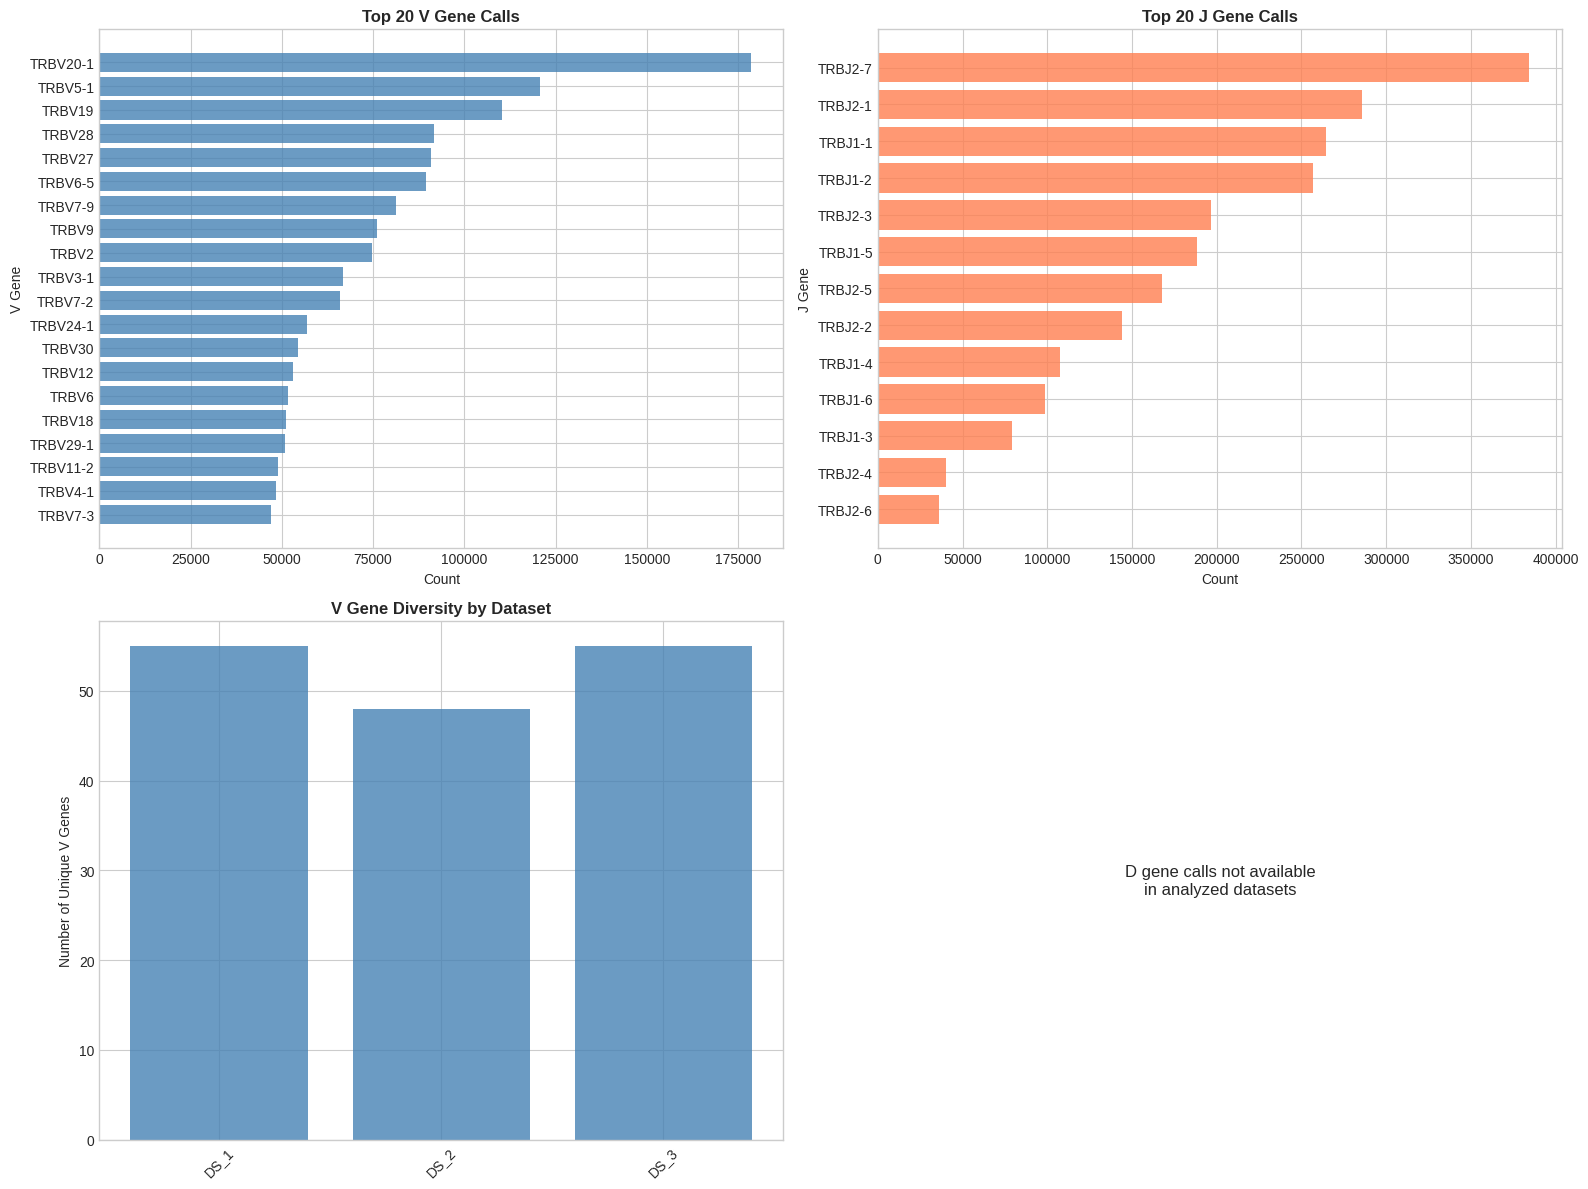


📊 Gene Call Statistics:
   • Unique V genes: 56
   • Unique J genes: 13
   • Unique D genes: 0

📊 Top 10 V Genes:
   TRBV20-1: 178,468
   TRBV5-1: 120,708
   TRBV19: 110,420
   TRBV28: 91,703
   TRBV27: 90,919
   TRBV6-5: 89,566
   TRBV7-9: 81,380
   TRBV9: 76,127
   TRBV2: 74,740
   TRBV3-1: 66,861

📊 Top 10 J Genes:
   TRBJ2-7: 384,497
   TRBJ2-1: 285,808
   TRBJ1-1: 264,478
   TRBJ1-2: 257,009
   TRBJ2-3: 196,475
   TRBJ1-5: 188,078
   TRBJ2-5: 167,845
   TRBJ2-2: 143,864
   TRBJ1-4: 107,449
   TRBJ1-6: 98,764


In [11]:
# =============================================================================
# V/J/D GENE CALL DISTRIBUTION
# =============================================================================

def analyze_gene_calls(dataset_path: str, n_files: int = 20) -> Dict:
    """Analyze v_call, j_call, and d_call distributions."""
    metadata_path = os.path.join(dataset_path, 'metadata.csv')
    
    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        files = metadata['filename'].tolist()[:n_files]
        labels = dict(zip(metadata['filename'], metadata['label_positive']))
    else:
        files = [os.path.basename(f) for f in glob.glob(os.path.join(dataset_path, "*.tsv"))[:n_files]]
        labels = {}
    
    v_calls = Counter()
    j_calls = Counter()
    d_calls = Counter()
    
    v_calls_by_label = {True: Counter(), False: Counter()}
    j_calls_by_label = {True: Counter(), False: Counter()}
    
    has_d_call = False
    
    for filename in files:
        file_path = os.path.join(dataset_path, filename)
        label = labels.get(filename, None)
        
        if os.path.exists(file_path):
            rep = pd.read_csv(file_path, sep='\t')
            
            if 'v_call' in rep.columns:
                v_vals = rep['v_call'].dropna()
                v_calls.update(v_vals)
                if label is not None:
                    v_calls_by_label[label].update(v_vals)
            
            if 'j_call' in rep.columns:
                j_vals = rep['j_call'].dropna()
                j_calls.update(j_vals)
                if label is not None:
                    j_calls_by_label[label].update(j_vals)
            
            if 'd_call' in rep.columns:
                has_d_call = True
                d_calls.update(rep['d_call'].dropna())
    
    return {
        'v_calls': v_calls,
        'j_calls': j_calls,
        'd_calls': d_calls,
        'has_d_call': has_d_call,
        'v_calls_by_label': v_calls_by_label,
        'j_calls_by_label': j_calls_by_label
    }

print("=" * 80)
print("V/J/D GENE CALL DISTRIBUTION")
print("=" * 80)

# Analyze gene calls from datasets
gene_analysis = {}
for dataset_name in train_datasets[:3]:
    dataset_path = os.path.join(TRAIN_DIR, dataset_name)
    gene_analysis[dataset_name] = analyze_gene_calls(dataset_path, n_files=30)
    print(f"✅ Analyzed {dataset_name}: d_call present = {gene_analysis[dataset_name]['has_d_call']}")

# Combine results
combined_v = Counter()
combined_j = Counter()
combined_d = Counter()
for ga in gene_analysis.values():
    combined_v.update(ga['v_calls'])
    combined_j.update(ga['j_calls'])
    combined_d.update(ga['d_calls'])

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top V genes
ax1 = axes[0, 0]
top_v = pd.DataFrame.from_dict(combined_v, orient='index', columns=['count']).nlargest(20, 'count')
ax1.barh(top_v.index, top_v['count'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Count', fontsize=10)
ax1.set_ylabel('V Gene', fontsize=10)
ax1.set_title('Top 20 V Gene Calls', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# Top J genes
ax2 = axes[0, 1]
top_j = pd.DataFrame.from_dict(combined_j, orient='index', columns=['count']).nlargest(20, 'count')
ax2.barh(top_j.index, top_j['count'], color='coral', alpha=0.8)
ax2.set_xlabel('Count', fontsize=10)
ax2.set_ylabel('J Gene', fontsize=10)
ax2.set_title('Top 20 J Gene Calls', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# V gene diversity by dataset
ax3 = axes[1, 0]
v_diversity = []
for dataset_name, ga in gene_analysis.items():
    n_unique_v = len(ga['v_calls'])
    total_v = sum(ga['v_calls'].values())
    v_diversity.append({
        'Dataset': dataset_name.replace('train_dataset_', 'DS_'),
        'Unique V genes': n_unique_v,
        'Total V calls': total_v
    })
v_div_df = pd.DataFrame(v_diversity)
x = np.arange(len(v_div_df))
ax3.bar(x, v_div_df['Unique V genes'], color='steelblue', alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(v_div_df['Dataset'], rotation=45)
ax3.set_ylabel('Number of Unique V Genes', fontsize=10)
ax3.set_title('V Gene Diversity by Dataset', fontsize=12, fontweight='bold')

# Top D genes (if available)
ax4 = axes[1, 1]
if combined_d:
    top_d = pd.DataFrame.from_dict(combined_d, orient='index', columns=['count']).nlargest(15, 'count')
    ax4.barh(top_d.index, top_d['count'], color='forestgreen', alpha=0.8)
    ax4.set_xlabel('Count', fontsize=10)
    ax4.set_ylabel('D Gene', fontsize=10)
    ax4.set_title('Top 15 D Gene Calls', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
else:
    ax4.text(0.5, 0.5, 'D gene calls not available\nin analyzed datasets', 
             ha='center', va='center', fontsize=12, transform=ax4.transAxes)
    ax4.axis('off')

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Gene Call Statistics:")
print(f"   • Unique V genes: {len(combined_v):,}")
print(f"   • Unique J genes: {len(combined_j):,}")
print(f"   • Unique D genes: {len(combined_d):,}")

print("\n📊 Top 10 V Genes:")
for gene, count in combined_v.most_common(10):
    print(f"   {gene}: {count:,}")

print("\n📊 Top 10 J Genes:")
for gene, count in combined_j.most_common(10):
    print(f"   {gene}: {count:,}")

## 5. Diversity Metrics & Sequence Sharing

### 5.1 Repertoire Diversity Metrics

REPERTOIRE DIVERSITY METRICS


Calculating diversity:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Calculated diversity for train_dataset_1


Calculating diversity:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Calculated diversity for train_dataset_2


Calculating diversity:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Calculated diversity for train_dataset_3


Calculating diversity:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Calculated diversity for train_dataset_4


Calculating diversity:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Calculated diversity for train_dataset_5


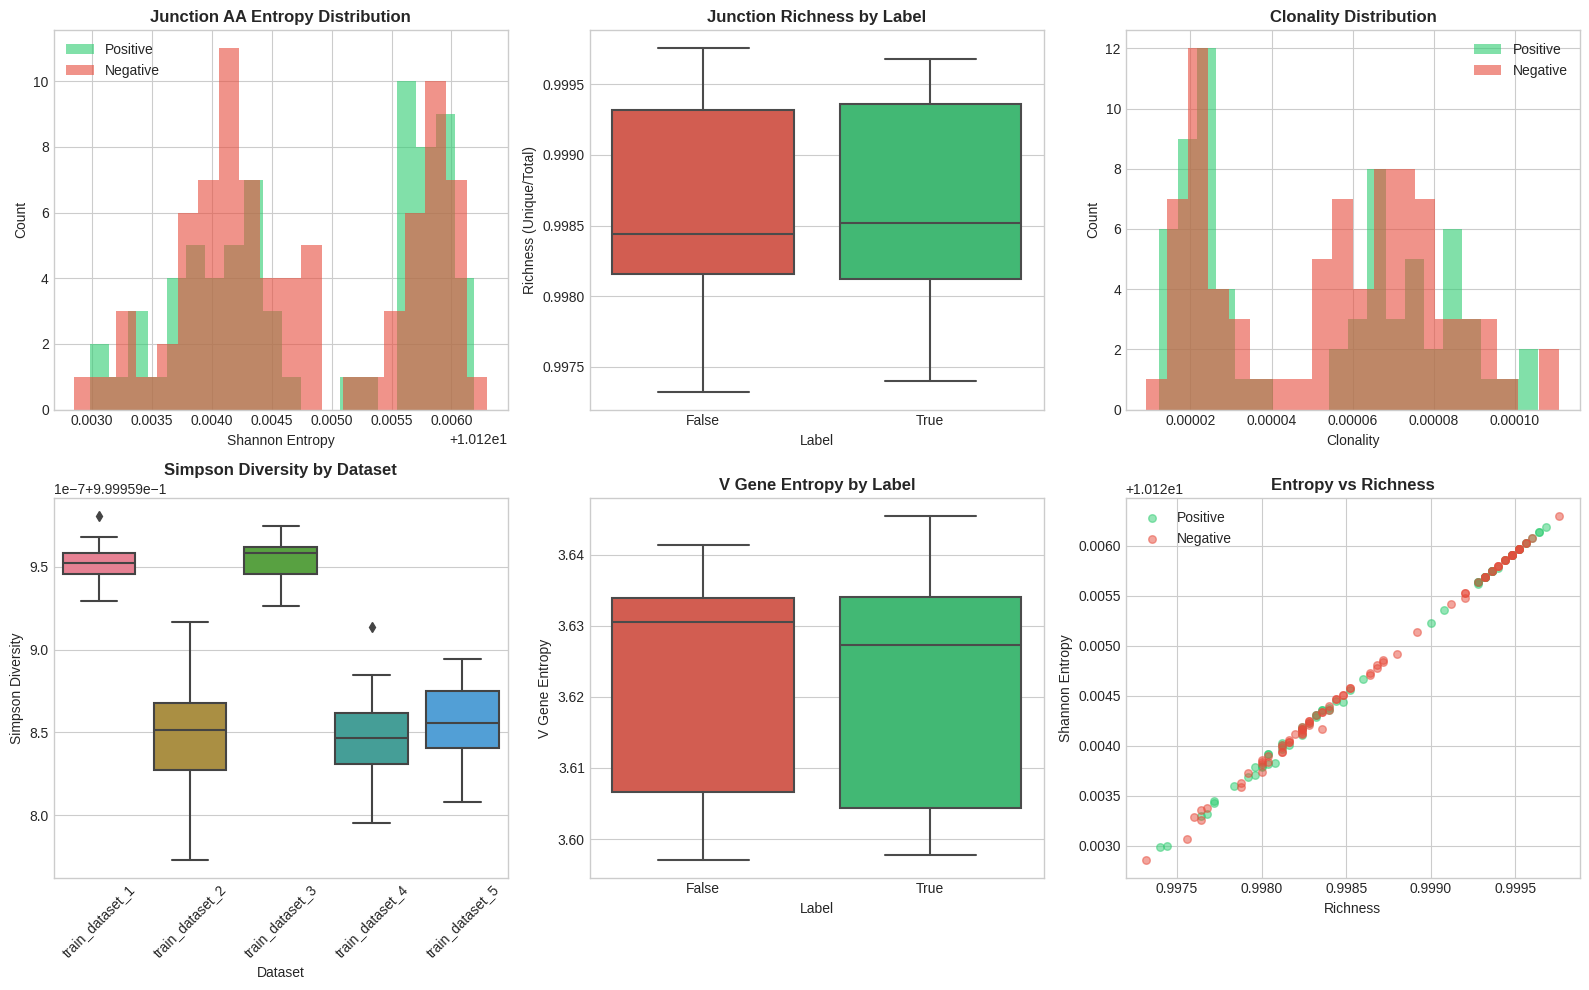


📊 Diversity Metrics Summary:


,junction_entropy,junction_richness,simpson_diversity,clonality,v_entropy,j_entropy
count,150.000000,150.000000,1.500000e+02,150.000000,150.000000,150.000000
mean,10.124773,0.998677,9.999599e-01,0.000053,3.621368,2.375539
std,0.000943,0.000664,5.683409e-08,0.000028,0.014838,0.019978
min,10.122853,0.997320,9.999598e-01,0.000009,3.596998,2.350478
25%,10.124009,0.998130,9.999598e-01,0.000024,3.604667,2.358793
50%,10.124486,0.998480,9.999599e-01,0.000060,3.629275,2.363242
75%,10.125744,0.999360,9.999599e-01,0.000075,3.633952,2.398819
max,10.126298,0.999760,9.999600e-01,0.000111,3.645489,2.406342



📊 Diversity Metrics by Label:


,junction_entropy,junction_richness,simpson_diversity,clonality,v_entropy,j_entropy
label_positive,,,,,,
False,10.124714,0.998636,0.99996,0.000054,3.622932,2.372614
True,10.124843,0.998726,0.99996,0.000051,3.619531,2.378973


In [12]:
# =============================================================================
# REPERTOIRE DIVERSITY METRICS
# =============================================================================

def calculate_diversity_metrics(dataset_path: str, n_files: int = 30) -> pd.DataFrame:
    """Calculate diversity metrics for repertoires in a dataset."""
    metadata_path = os.path.join(dataset_path, 'metadata.csv')
    
    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        files = metadata['filename'].tolist()[:n_files]
        labels = dict(zip(metadata['filename'], metadata['label_positive']))
    else:
        files = [os.path.basename(f) for f in glob.glob(os.path.join(dataset_path, "*.tsv"))[:n_files]]
        labels = {}
    
    metrics = []
    
    for filename in tqdm(files, desc=f"Calculating diversity", leave=False):
        file_path = os.path.join(dataset_path, filename)
        
        if os.path.exists(file_path):
            rep = pd.read_csv(file_path, sep='\t')
            
            metric = {
                'filename': filename,
                'label_positive': labels.get(filename, None),
                'n_sequences': len(rep),
            }
            
            # Junction AA diversity
            if 'junction_aa' in rep.columns:
                junction_counts = rep['junction_aa'].value_counts()
                n_unique = len(junction_counts)
                metric['n_unique_junction'] = n_unique
                metric['junction_richness'] = n_unique / len(rep) if len(rep) > 0 else 0
                
                # Shannon entropy
                probs = junction_counts / junction_counts.sum()
                metric['junction_entropy'] = entropy(probs)
                
                # Simpson's diversity index
                metric['simpson_diversity'] = 1 - sum((junction_counts / junction_counts.sum()) ** 2)
                
                # Clonality (inverse of normalized entropy)
                max_entropy = np.log(n_unique) if n_unique > 1 else 1
                metric['clonality'] = 1 - (metric['junction_entropy'] / max_entropy) if max_entropy > 0 else 0
            
            # V gene diversity
            if 'v_call' in rep.columns:
                v_counts = rep['v_call'].value_counts()
                metric['n_unique_v'] = len(v_counts)
                metric['v_entropy'] = entropy(v_counts / v_counts.sum())
            
            # J gene diversity  
            if 'j_call' in rep.columns:
                j_counts = rep['j_call'].value_counts()
                metric['n_unique_j'] = len(j_counts)
                metric['j_entropy'] = entropy(j_counts / j_counts.sum())
            
            # Templates/duplicate counts if available
            template_col = 'templates' if 'templates' in rep.columns else ('duplicate_count' if 'duplicate_count' in rep.columns else None)
            if template_col:
                metric['has_templates'] = True
                metric['total_templates'] = rep[template_col].sum()
                metric['mean_templates'] = rep[template_col].mean()
                metric['max_templates'] = rep[template_col].max()
            else:
                metric['has_templates'] = False
            
            metrics.append(metric)
    
    return pd.DataFrame(metrics)

print("=" * 80)
print("REPERTOIRE DIVERSITY METRICS")
print("=" * 80)

# Calculate diversity for multiple datasets
diversity_results = []
for dataset_name in train_datasets[:5]:
    dataset_path = os.path.join(TRAIN_DIR, dataset_name)
    div_df = calculate_diversity_metrics(dataset_path, n_files=30)
    div_df['dataset'] = dataset_name
    diversity_results.append(div_df)
    print(f"✅ Calculated diversity for {dataset_name}")

diversity_df = pd.concat(diversity_results, ignore_index=True)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Shannon entropy distribution
ax1 = axes[0, 0]
if 'junction_entropy' in diversity_df.columns:
    if diversity_df['label_positive'].notna().any():
        for label, color in [(True, '#2ecc71'), (False, '#e74c3c')]:
            subset = diversity_df[diversity_df['label_positive'] == label]['junction_entropy'].dropna()
            if len(subset) > 0:
                ax1.hist(subset, bins=20, alpha=0.6, label=f'{"Positive" if label else "Negative"}', color=color)
        ax1.legend()
    else:
        ax1.hist(diversity_df['junction_entropy'].dropna(), bins=20, color='steelblue', alpha=0.7)
ax1.set_xlabel('Shannon Entropy', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Junction AA Entropy Distribution', fontsize=12, fontweight='bold')

# Richness by label
ax2 = axes[0, 1]
if 'junction_richness' in diversity_df.columns:
    if diversity_df['label_positive'].notna().any():
        sns.boxplot(data=diversity_df, x='label_positive', y='junction_richness', ax=ax2, 
                   palette={True: '#2ecc71', False: '#e74c3c'})
    else:
        ax2.hist(diversity_df['junction_richness'].dropna(), bins=20, color='steelblue', alpha=0.7)
ax2.set_xlabel('Label', fontsize=10)
ax2.set_ylabel('Richness (Unique/Total)', fontsize=10)
ax2.set_title('Junction Richness by Label', fontsize=12, fontweight='bold')

# Clonality distribution
ax3 = axes[0, 2]
if 'clonality' in diversity_df.columns:
    if diversity_df['label_positive'].notna().any():
        for label, color in [(True, '#2ecc71'), (False, '#e74c3c')]:
            subset = diversity_df[diversity_df['label_positive'] == label]['clonality'].dropna()
            if len(subset) > 0:
                ax3.hist(subset, bins=20, alpha=0.6, label=f'{"Positive" if label else "Negative"}', color=color)
        ax3.legend()
    else:
        ax3.hist(diversity_df['clonality'].dropna(), bins=20, color='steelblue', alpha=0.7)
ax3.set_xlabel('Clonality', fontsize=10)
ax3.set_ylabel('Count', fontsize=10)
ax3.set_title('Clonality Distribution', fontsize=12, fontweight='bold')

# Simpson diversity by dataset
ax4 = axes[1, 0]
if 'simpson_diversity' in diversity_df.columns:
    sns.boxplot(data=diversity_df, x='dataset', y='simpson_diversity', ax=ax4)
    ax4.tick_params(axis='x', rotation=45)
ax4.set_xlabel('Dataset', fontsize=10)
ax4.set_ylabel('Simpson Diversity', fontsize=10)
ax4.set_title('Simpson Diversity by Dataset', fontsize=12, fontweight='bold')

# V gene entropy by label
ax5 = axes[1, 1]
if 'v_entropy' in diversity_df.columns:
    if diversity_df['label_positive'].notna().any():
        sns.boxplot(data=diversity_df, x='label_positive', y='v_entropy', ax=ax5,
                   palette={True: '#2ecc71', False: '#e74c3c'})
ax5.set_xlabel('Label', fontsize=10)
ax5.set_ylabel('V Gene Entropy', fontsize=10)
ax5.set_title('V Gene Entropy by Label', fontsize=12, fontweight='bold')

# Correlation: entropy vs richness
ax6 = axes[1, 2]
if 'junction_entropy' in diversity_df.columns and 'junction_richness' in diversity_df.columns:
    if diversity_df['label_positive'].notna().any():
        for label, color in [(True, '#2ecc71'), (False, '#e74c3c')]:
            subset = diversity_df[diversity_df['label_positive'] == label]
            ax6.scatter(subset['junction_richness'], subset['junction_entropy'], alpha=0.5, 
                       label=f'{"Positive" if label else "Negative"}', c=color, s=30)
        ax6.legend()
    else:
        ax6.scatter(diversity_df['junction_richness'], diversity_df['junction_entropy'], alpha=0.5, c='steelblue')
ax6.set_xlabel('Richness', fontsize=10)
ax6.set_ylabel('Shannon Entropy', fontsize=10)
ax6.set_title('Entropy vs Richness', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Diversity Metrics Summary:")
diversity_cols = ['junction_entropy', 'junction_richness', 'simpson_diversity', 'clonality', 'v_entropy', 'j_entropy']
available_cols = [c for c in diversity_cols if c in diversity_df.columns]
display(diversity_df[available_cols].describe())

# Compare by label
if diversity_df['label_positive'].notna().any():
    print("\n📊 Diversity Metrics by Label:")
    display(diversity_df.groupby('label_positive')[available_cols].mean())

### 5.2 Shared Sequences Analysis ("Public Clones" / "Star Soldiers")

SHARED SEQUENCES ANALYSIS (Public Clones)


Finding shared sequences:   0%|          | 0/50 [00:00<?, ?it/s]

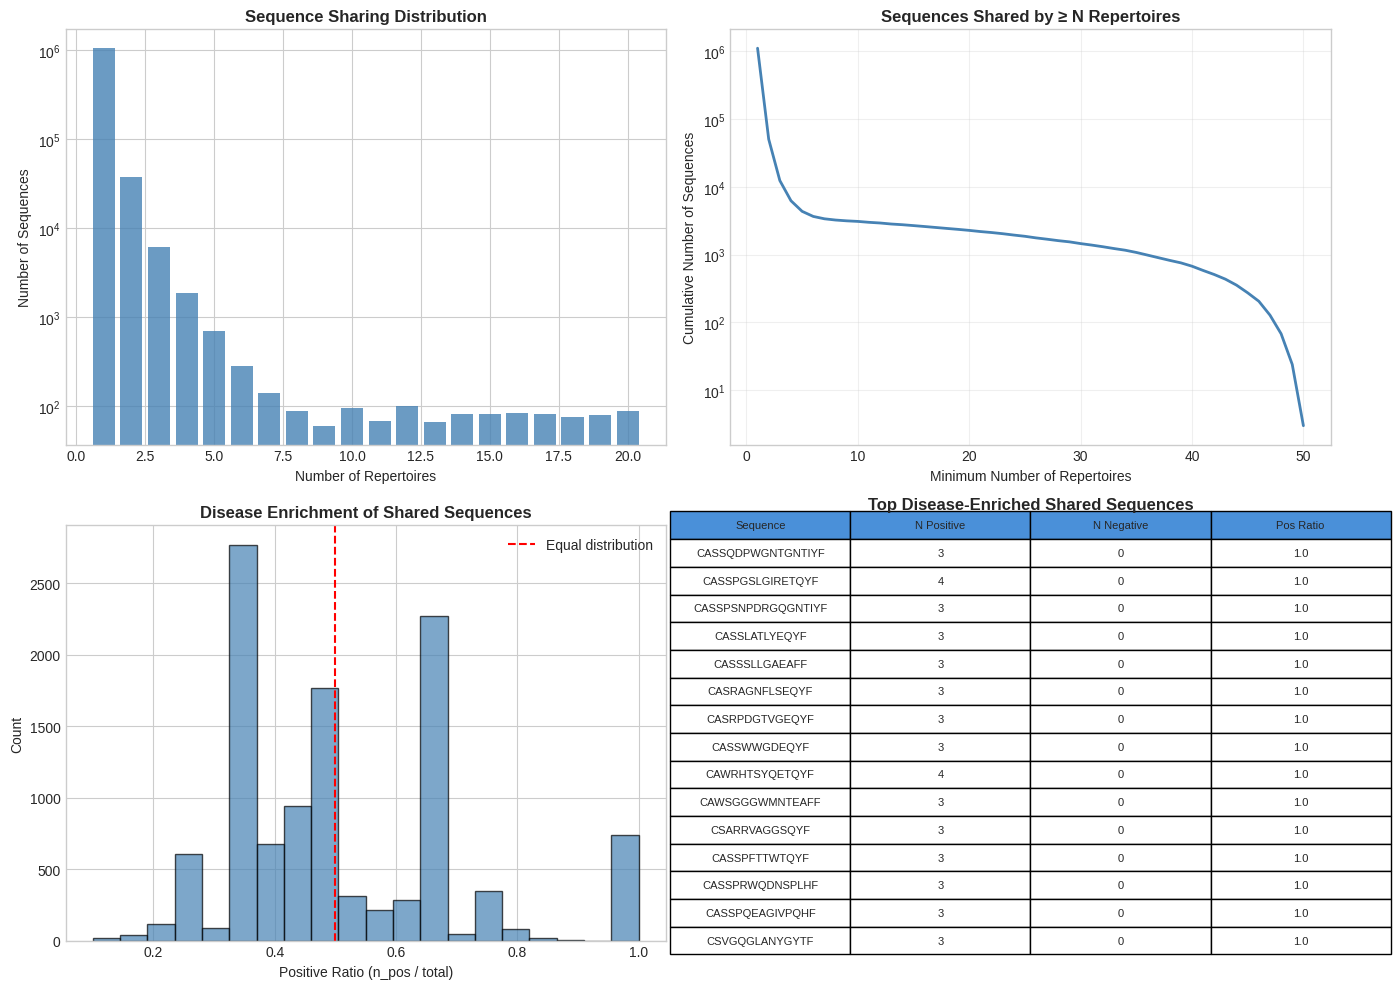


📊 Shared Sequences Summary for train_dataset_1:
   • Total unique sequences: 1,102,337
   • Sequences in 1 repertoire only: 1,052,092
   • Sequences in 2+ repertoires: 50,245
   • Sequences in 5+ repertoires: 4,339
   • Sequences in 10+ repertoires: 3,083

📊 Disease-Enriched Sequences (appearing in 3+ repertoires):
   • Total: 11,325
   • Highly positive-enriched (>70%): 1,211
   • Highly negative-enriched (<30%): 817


In [13]:
# =============================================================================
# SHARED SEQUENCES ANALYSIS ("PUBLIC CLONES" / "STAR SOLDIERS")
# =============================================================================
# Identify sequences that appear across multiple individuals - potential disease markers

def find_shared_sequences(dataset_path: str, n_files: int = 50) -> Dict:
    """Find sequences shared across multiple repertoires."""
    metadata_path = os.path.join(dataset_path, 'metadata.csv')
    
    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        files = metadata['filename'].tolist()[:n_files]
        labels = dict(zip(metadata['filename'], metadata['label_positive']))
    else:
        files = [os.path.basename(f) for f in glob.glob(os.path.join(dataset_path, "*.tsv"))[:n_files]]
        labels = {}
    
    # Track which repertoires contain each sequence
    seq_to_repertoires = defaultdict(set)
    seq_to_positive = defaultdict(set)  # Track if sequence appears in positive samples
    seq_to_negative = defaultdict(set)  # Track if sequence appears in negative samples
    
    for filename in tqdm(files, desc="Finding shared sequences", leave=False):
        file_path = os.path.join(dataset_path, filename)
        label = labels.get(filename, None)
        
        if os.path.exists(file_path):
            rep = pd.read_csv(file_path, sep='\t')
            if 'junction_aa' in rep.columns:
                unique_seqs = rep['junction_aa'].dropna().unique()
                for seq in unique_seqs:
                    seq_to_repertoires[seq].add(filename)
                    if label is True:
                        seq_to_positive[seq].add(filename)
                    elif label is False:
                        seq_to_negative[seq].add(filename)
    
    return {
        'seq_to_repertoires': seq_to_repertoires,
        'seq_to_positive': seq_to_positive,
        'seq_to_negative': seq_to_negative,
        'n_repertoires': len(files)
    }

print("=" * 80)
print("SHARED SEQUENCES ANALYSIS (Public Clones)")
print("=" * 80)

# Analyze shared sequences from a sample dataset
sample_dataset_name = train_datasets[0]
sample_dataset_path = os.path.join(TRAIN_DIR, sample_dataset_name)
shared_results = find_shared_sequences(sample_dataset_path, n_files=50)

# Analyze sharing patterns
sharing_counts = Counter()
for seq, repertoires in shared_results['seq_to_repertoires'].items():
    sharing_counts[len(repertoires)] += 1

# Identify disease-associated shared sequences
disease_enriched = []
for seq, pos_reps in shared_results['seq_to_positive'].items():
    neg_reps = shared_results['seq_to_negative'].get(seq, set())
    n_pos = len(pos_reps)
    n_neg = len(neg_reps)
    total = n_pos + n_neg
    if total >= 3:  # Minimum threshold
        enrichment = n_pos / total
        disease_enriched.append({
            'sequence': seq,
            'n_positive': n_pos,
            'n_negative': n_neg,
            'total': total,
            'pos_ratio': enrichment
        })

disease_df = pd.DataFrame(disease_enriched)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sharing distribution
ax1 = axes[0, 0]
sharing_df = pd.DataFrame.from_dict(sharing_counts, orient='index', columns=['count']).sort_index()
ax1.bar(sharing_df.index[:20], sharing_df['count'][:20], color='steelblue', alpha=0.8)
ax1.set_xlabel('Number of Repertoires', fontsize=10)
ax1.set_ylabel('Number of Sequences', fontsize=10)
ax1.set_title('Sequence Sharing Distribution', fontsize=12, fontweight='bold')
ax1.set_yscale('log')

# Cumulative sharing
ax2 = axes[0, 1]
cumsum = sharing_df['count'].sort_index(ascending=False).cumsum()
ax2.plot(cumsum.index, cumsum.values, color='steelblue', linewidth=2)
ax2.set_xlabel('Minimum Number of Repertoires', fontsize=10)
ax2.set_ylabel('Cumulative Number of Sequences', fontsize=10)
ax2.set_title('Sequences Shared by ≥ N Repertoires', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Disease enrichment of shared sequences
ax3 = axes[1, 0]
if len(disease_df) > 0:
    ax3.hist(disease_df['pos_ratio'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    ax3.axvline(x=0.5, color='red', linestyle='--', label='Equal distribution')
    ax3.set_xlabel('Positive Ratio (n_pos / total)', fontsize=10)
    ax3.set_ylabel('Count', fontsize=10)
    ax3.set_title('Disease Enrichment of Shared Sequences', fontsize=12, fontweight='bold')
    ax3.legend()
else:
    ax3.text(0.5, 0.5, 'Insufficient data for analysis', ha='center', va='center', transform=ax3.transAxes)
    ax3.axis('off')

# Top disease-enriched sequences
ax4 = axes[1, 1]
if len(disease_df) > 0:
    # Get top positive-enriched sequences
    top_pos = disease_df.nlargest(15, 'pos_ratio')[['sequence', 'n_positive', 'n_negative', 'pos_ratio']]
    
    ax4.axis('off')
    table = ax4.table(cellText=top_pos.round(2).values,
                      colLabels=['Sequence', 'N Positive', 'N Negative', 'Pos Ratio'],
                      loc='center',
                      cellLoc='center',
                      colColours=['#4a90d9']*4)
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.4)
    ax4.set_title('Top Disease-Enriched Shared Sequences', fontsize=12, fontweight='bold', y=1.02)
else:
    ax4.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax4.transAxes)
    ax4.axis('off')

plt.tight_layout()
plt.show()

# Print summary
print(f"\n📊 Shared Sequences Summary for {sample_dataset_name}:")
print(f"   • Total unique sequences: {len(shared_results['seq_to_repertoires']):,}")
print(f"   • Sequences in 1 repertoire only: {sharing_counts.get(1, 0):,}")
print(f"   • Sequences in 2+ repertoires: {sum(v for k, v in sharing_counts.items() if k >= 2):,}")
print(f"   • Sequences in 5+ repertoires: {sum(v for k, v in sharing_counts.items() if k >= 5):,}")
print(f"   • Sequences in 10+ repertoires: {sum(v for k, v in sharing_counts.items() if k >= 10):,}")

if len(disease_df) > 0:
    print(f"\n📊 Disease-Enriched Sequences (appearing in 3+ repertoires):")
    print(f"   • Total: {len(disease_df):,}")
    print(f"   • Highly positive-enriched (>70%): {len(disease_df[disease_df['pos_ratio'] > 0.7]):,}")
    print(f"   • Highly negative-enriched (<30%): {len(disease_df[disease_df['pos_ratio'] < 0.3]):,}")

## 6. Technical Bias Check (Batch Effects)

### 6.1 Sequencing Run Analysis

TECHNICAL BIAS CHECK - BATCH EFFECTS

✅ sequencing_run_id found in metadata

📊 Number of sequencing runs: 3


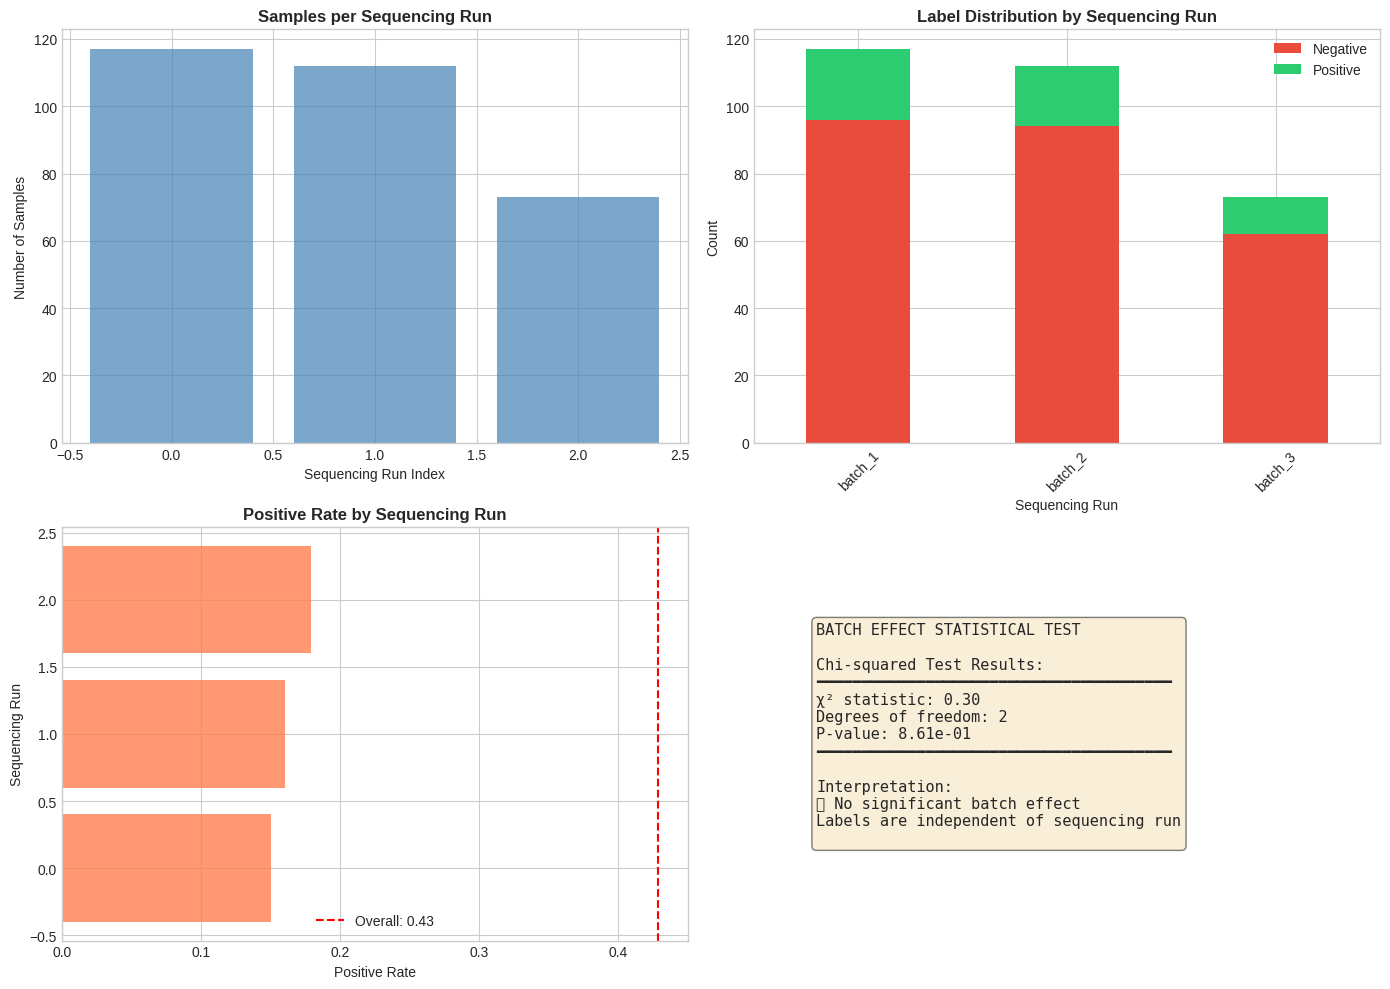


📊 Sequencing Run Summary:


,n_samples,n_positive,positive_rate,n_datasets
sequencing_run_id,,,,
batch_1,117,21,0.179,1
batch_2,112,18,0.161,1
batch_3,73,11,0.151,1


In [14]:
# =============================================================================
# TECHNICAL BIAS CHECK - BATCH EFFECTS
# =============================================================================

print("=" * 80)
print("TECHNICAL BIAS CHECK - BATCH EFFECTS")
print("=" * 80)

# Check for sequencing_run_id in metadata
if 'sequencing_run_id' in train_metadata.columns:
    print("\n✅ sequencing_run_id found in metadata")
    
    run_analysis = train_metadata.groupby('sequencing_run_id').agg({
        'repertoire_id': 'count',
        'label_positive': ['sum', 'mean'],
        'dataset': 'nunique'
    }).round(3)
    run_analysis.columns = ['n_samples', 'n_positive', 'positive_rate', 'n_datasets']
    
    print(f"\n📊 Number of sequencing runs: {train_metadata['sequencing_run_id'].nunique()}")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Samples per run
    ax1 = axes[0, 0]
    run_counts = train_metadata['sequencing_run_id'].value_counts()
    ax1.bar(range(len(run_counts)), run_counts.values, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Sequencing Run Index', fontsize=10)
    ax1.set_ylabel('Number of Samples', fontsize=10)
    ax1.set_title('Samples per Sequencing Run', fontsize=12, fontweight='bold')
    
    # Label distribution by run
    ax2 = axes[0, 1]
    run_label_dist = train_metadata.groupby(['sequencing_run_id', 'label_positive']).size().unstack(fill_value=0)
    run_label_dist.plot(kind='bar', stacked=True, ax=ax2, color=['#e74c3c', '#2ecc71'])
    ax2.set_xlabel('Sequencing Run', fontsize=10)
    ax2.set_ylabel('Count', fontsize=10)
    ax2.set_title('Label Distribution by Sequencing Run', fontsize=12, fontweight='bold')
    ax2.legend(['Negative', 'Positive'])
    ax2.tick_params(axis='x', rotation=45)
    
    # Positive rate by run
    ax3 = axes[1, 0]
    positive_rates = train_metadata.groupby('sequencing_run_id')['label_positive'].mean().sort_values()
    ax3.barh(range(len(positive_rates)), positive_rates.values, color='coral', alpha=0.8)
    ax3.axvline(x=train_metadata['label_positive'].mean(), color='red', linestyle='--', 
                label=f'Overall: {train_metadata["label_positive"].mean():.2f}')
    ax3.set_xlabel('Positive Rate', fontsize=10)
    ax3.set_ylabel('Sequencing Run', fontsize=10)
    ax3.set_title('Positive Rate by Sequencing Run', fontsize=12, fontweight='bold')
    ax3.legend()
    
    # Chi-squared test for batch effect
    ax4 = axes[1, 1]
    contingency = pd.crosstab(train_metadata['sequencing_run_id'], train_metadata['label_positive'])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
    
    ax4.axis('off')
    text = f"""BATCH EFFECT STATISTICAL TEST
    
Chi-squared Test Results:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
χ² statistic: {chi2:.2f}
Degrees of freedom: {dof}
P-value: {p_val:.2e}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Interpretation:
{'⚠️ SIGNIFICANT batch effect detected!' if p_val < 0.05 else '✅ No significant batch effect'}
{'Consider stratified sampling by run' if p_val < 0.05 else 'Labels are independent of sequencing run'}
"""
    ax4.text(0.1, 0.5, text, fontsize=11, family='monospace', transform=ax4.transAxes, 
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Sequencing Run Summary:")
    display(run_analysis.sort_values('n_samples', ascending=False).head(15))
    
else:
    print("\n⚠️ sequencing_run_id not found in metadata")
    print("   Batch effect analysis by sequencing run not possible.")
    
    # Check for other potential batch indicators
    potential_batch_cols = ['study_group', 'cohort', 'batch', 'plate', 'run']
    found_cols = [col for col in potential_batch_cols if col in train_metadata.columns]
    
    if found_cols:
        print(f"\n   Alternative batch indicators found: {found_cols}")
        for col in found_cols:
            print(f"\n📊 {col} distribution:")
            print(train_metadata[col].value_counts().head(10))
    else:
        print("   No alternative batch indicators found.")

## 7. HLA Gene Analysis

In [15]:
# =============================================================================
# HLA GENE ANALYSIS
# =============================================================================

print("=" * 80)
print("HLA GENE ANALYSIS")
print("=" * 80)

# Find HLA-related columns
hla_cols = [col for col in train_metadata.columns if 'hla' in col.lower() or 'mhc' in col.lower()]

if hla_cols:
    print(f"\n✅ HLA-related columns found: {hla_cols}")
    
    for hla_col in hla_cols:
        print(f"\n" + "=" * 60)
        print(f"ANALYSIS OF: {hla_col}")
        print("=" * 60)
        
        # Basic statistics
        n_unique = train_metadata[hla_col].nunique()
        n_missing = train_metadata[hla_col].isna().sum()
        print(f"\n📊 Basic stats:")
        print(f"   • Unique values: {n_unique:,}")
        print(f"   • Missing: {n_missing:,} ({n_missing/len(train_metadata)*100:.1f}%)")
        
        if n_unique > 0 and n_unique < 100:
            # Distribution plot
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Overall distribution
            ax1 = axes[0]
            value_counts = train_metadata[hla_col].value_counts().head(20)
            ax1.barh(value_counts.index.astype(str), value_counts.values, color='steelblue', alpha=0.8)
            ax1.set_xlabel('Count', fontsize=10)
            ax1.set_ylabel(hla_col, fontsize=10)
            ax1.set_title(f'Top 20 {hla_col} Values', fontsize=12, fontweight='bold')
            ax1.invert_yaxis()
            
            # Association with label
            ax2 = axes[1]
            if 'label_positive' in train_metadata.columns:
                # Get top HLA types and their positive rates
                hla_label_stats = train_metadata.groupby(hla_col).agg({
                    'label_positive': ['count', 'sum', 'mean']
                }).round(3)
                hla_label_stats.columns = ['count', 'n_positive', 'positive_rate']
                hla_label_stats = hla_label_stats[hla_label_stats['count'] >= 5].sort_values('positive_rate', ascending=False)
                
                if len(hla_label_stats) > 0:
                    top_hla = hla_label_stats.head(15)
                    colors = ['#2ecc71' if r > 0.5 else '#e74c3c' for r in top_hla['positive_rate']]
                    ax2.barh(top_hla.index.astype(str), top_hla['positive_rate'], color=colors, alpha=0.8)
                    ax2.axvline(x=train_metadata['label_positive'].mean(), color='black', linestyle='--', 
                               label=f'Overall rate: {train_metadata["label_positive"].mean():.2f}')
                    ax2.set_xlabel('Positive Rate', fontsize=10)
                    ax2.set_ylabel(hla_col, fontsize=10)
                    ax2.set_title(f'{hla_col} Association with Label (min 5 samples)', fontsize=12, fontweight='bold')
                    ax2.legend()
                    ax2.invert_yaxis()
            
            plt.tight_layout()
            plt.show()
            
            # Statistical test for association
            if 'label_positive' in train_metadata.columns:
                # Chi-squared test
                valid_data = train_metadata[[hla_col, 'label_positive']].dropna()
                if len(valid_data) > 0:
                    contingency = pd.crosstab(valid_data[hla_col], valid_data['label_positive'])
                    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                        chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
                        print(f"\n📊 Chi-squared test for {hla_col} vs label:")
                        print(f"   • χ² = {chi2:.2f}")
                        print(f"   • p-value = {p_val:.2e}")
                        print(f"   • {'⚠️ SIGNIFICANT association!' if p_val < 0.05 else '✅ No significant association'}")
        
        elif n_unique >= 100:
            print(f"\n⚠️ Too many unique values ({n_unique}) for detailed visualization")
            print("   Top 10 values:")
            print(train_metadata[hla_col].value_counts().head(10))
else:
    print("\n⚠️ No HLA-related columns found in metadata")
    print("   HLA analysis not possible. Columns available:")
    print(f"   {list(train_metadata.columns)}")

HLA GENE ANALYSIS

⚠️ No HLA-related columns found in metadata
   HLA analysis not possible. Columns available:
   ['repertoire_id', 'filename', 'label_positive', 'dataset', 'age', 'sex', 'race', 'sequencing_run_id', 'study_group_description', 'A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1', 'DRB1', 'DRB3', 'DRB4', 'DRB5']


## 8. Missing Values Assessment

MISSING VALUES ASSESSMENT

📋 METADATA MISSING VALUES:


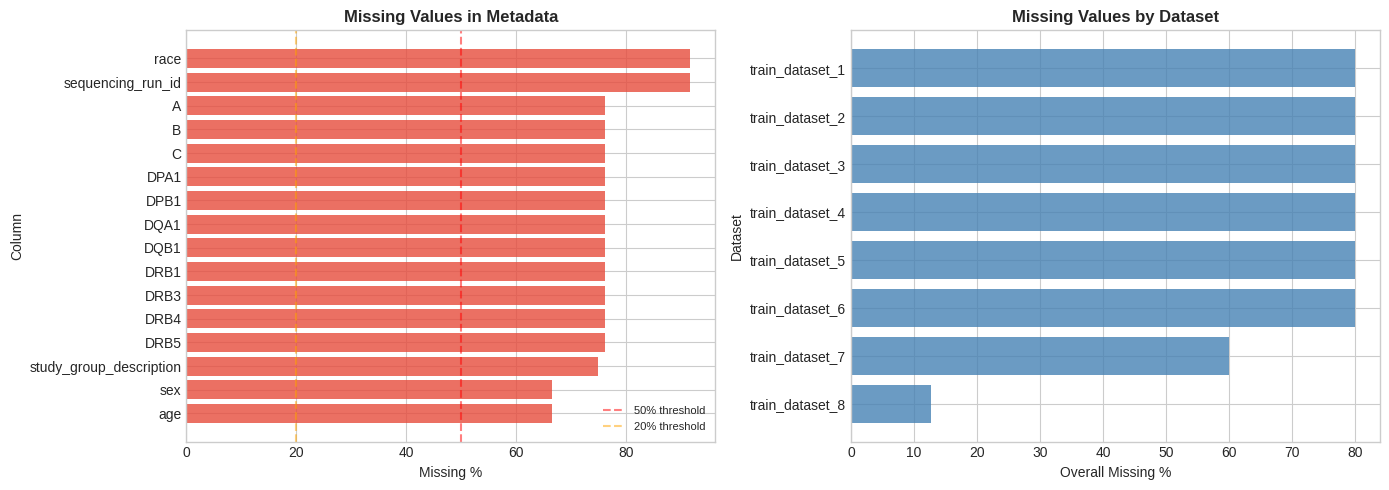


📊 Missing Values Summary:


,Column,Missing Count,Missing %,Total
6,race,3308,91.63,3610
7,sequencing_run_id,3308,91.63,3610
9,A,2746,76.07,3610
10,B,2746,76.07,3610
11,C,2746,76.07,3610
12,DPA1,2746,76.07,3610
13,DPB1,2746,76.07,3610
14,DQA1,2746,76.07,3610
15,DQB1,2746,76.07,3610
16,DRB1,2746,76.07,3610



--------------------------------------------------------------------------------
📋 CHECKING FOR -999.0 PLACEHOLDER VALUES:

--------------------------------------------------------------------------------
📋 REPERTOIRE-LEVEL MISSING VALUES (Sample):

Sample repertoire files from train_dataset_1:
   • junction_aa: avg 0.0% missing, max 0.0% missing
   • v_call: avg 0.0% missing, max 0.0% missing
   • j_call: avg 0.0% missing, max 0.0% missing


In [16]:
# =============================================================================
# MISSING VALUES ASSESSMENT
# =============================================================================

print("=" * 80)
print("MISSING VALUES ASSESSMENT")
print("=" * 80)

# Metadata missing values
print("\n📋 METADATA MISSING VALUES:")
missing_meta = train_metadata.isnull().sum()
missing_pct = (missing_meta / len(train_metadata) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing_meta.index,
    'Missing Count': missing_meta.values,
    'Missing %': missing_pct.values,
    'Total': len(train_metadata)
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Missing values bar chart
    ax1 = axes[0]
    colors = ['#e74c3c' if pct > 50 else '#f39c12' if pct > 20 else '#2ecc71' for pct in missing_df['Missing %']]
    ax1.barh(missing_df['Column'], missing_df['Missing %'], color=colors, alpha=0.8)
    ax1.set_xlabel('Missing %', fontsize=10)
    ax1.set_ylabel('Column', fontsize=10)
    ax1.set_title('Missing Values in Metadata', fontsize=12, fontweight='bold')
    ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax1.axvline(x=20, color='orange', linestyle='--', alpha=0.5, label='20% threshold')
    ax1.legend(fontsize=8)
    ax1.invert_yaxis()
    
    # Missing values by dataset
    ax2 = axes[1]
    dataset_missing = train_metadata.groupby('dataset').apply(lambda x: x.isnull().sum().sum() / (len(x) * len(x.columns)) * 100)
    dataset_missing = dataset_missing.sort_values(ascending=False)
    ax2.barh(dataset_missing.index, dataset_missing.values, color='steelblue', alpha=0.8)
    ax2.set_xlabel('Overall Missing %', fontsize=10)
    ax2.set_ylabel('Dataset', fontsize=10)
    ax2.set_title('Missing Values by Dataset', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Missing Values Summary:")
    display(missing_df)
else:
    print("   ✅ No missing values in metadata!")

# Check for -999.0 placeholder values (as mentioned in competition description)
print("\n" + "-" * 80)
print("📋 CHECKING FOR -999.0 PLACEHOLDER VALUES:")
for col in train_metadata.select_dtypes(include=[np.number]).columns:
    n_placeholder = (train_metadata[col] == -999.0).sum()
    if n_placeholder > 0:
        print(f"   • {col}: {n_placeholder:,} instances of -999.0")

# Repertoire-level missing values analysis
print("\n" + "-" * 80)
print("📋 REPERTOIRE-LEVEL MISSING VALUES (Sample):")

# Check a few repertoire files
sample_dataset_path = os.path.join(TRAIN_DIR, train_datasets[0])
sample_files = glob.glob(os.path.join(sample_dataset_path, "*.tsv"))[:5]

repertoire_missing = []
for file_path in sample_files:
    rep = pd.read_csv(file_path, sep='\t')
    missing_info = {
        'file': os.path.basename(file_path),
        'total_rows': len(rep)
    }
    for col in rep.columns:
        missing_info[f'{col}_missing'] = rep[col].isnull().sum()
        missing_info[f'{col}_missing_%'] = rep[col].isnull().sum() / len(rep) * 100
    repertoire_missing.append(missing_info)

rep_missing_df = pd.DataFrame(repertoire_missing)
print(f"\nSample repertoire files from {train_datasets[0]}:")

# Show missing percentages for key columns
key_cols = ['junction_aa', 'v_call', 'j_call']
for col in key_cols:
    if f'{col}_missing_%' in rep_missing_df.columns:
        avg_missing = rep_missing_df[f'{col}_missing_%'].mean()
        max_missing = rep_missing_df[f'{col}_missing_%'].max()
        print(f"   • {col}: avg {avg_missing:.1f}% missing, max {max_missing:.1f}% missing")

## 8.1 Improved Data Cleaning & Feature Engineering

### Key Changes from Initial Approach:
1. **Repertoire sequences are the PRIMARY signal** - not metadata/HLA
2. **Proper handling of missing HLA** - explicit missing flags, no "Unknown" hack
3. **Out-of-fold target encoding** with smoothing to prevent leakage
4. **Keep all rows** - use missing indicators instead of dropping
5. **Create interaction features** for HLA haplotypes

In [17]:
# =============================================================================
# IMPROVED DATA CLEANING STRATEGY
# =============================================================================
# Key principles:
# 1. Repertoire sequences are PRIMARY - metadata/HLA is supplementary
# 2. Keep ALL rows - use missing indicators
# 3. Proper out-of-fold encoding to prevent leakage
# 4. Explicit missing flags per HLA locus

print("=" * 80)
print("IMPROVED DATA CLEANING STRATEGY")
print("=" * 80)

# Create working copy
train_metadata_cleaned = train_metadata.copy()

print("\n📋 PHILOSOPHY:")
print("""
   ┌─────────────────────────────────────────────────────────────────────┐
   │ 1. SEQUENCES ARE PRIMARY: Build features from .tsv repertoire files │
   │ 2. KEEP ALL ROWS: Never drop samples - use missing indicators       │
   │ 3. NO 'UNKNOWN' HACK: Use explicit NaN + missing flags for HLA      │
   │ 4. OUT-OF-FOLD ENCODING: Prevent target leakage in encodings        │
   │ 5. INTERACTION FEATURES: Capture HLA haplotypes & study groups      │
   └─────────────────────────────────────────────────────────────────────┘
""")

# Identify column types
essential_cols = ['repertoire_id', 'filename', 'label_positive', 'dataset']
hla_cols = [col for col in train_metadata_cleaned.columns 
            if any(x in col.lower() for x in ['hla', 'dqa', 'dqb', 'drb', 'mhc', 'allele'])]
demographic_cols = [col for col in train_metadata_cleaned.columns 
                   if col in ['age', 'sex', 'race', 'subject_id']]
technical_cols = [col for col in train_metadata_cleaned.columns 
                 if col in ['sequencing_run_id', 'study_group', 'cohort']]

print(f"\n📊 COLUMN CATEGORIZATION:")
print(f"   • Essential: {essential_cols}")
print(f"   • HLA columns: {hla_cols}")
print(f"   • Demographic: {demographic_cols}")
print(f"   • Technical: {technical_cols}")

# Show current state
print(f"\n📋 CURRENT DATA STATE:")
print(f"   • Total samples: {len(train_metadata_cleaned):,}")
print(f"   • Total columns: {len(train_metadata_cleaned.columns)}")
print(f"   • Positive class: {train_metadata_cleaned['label_positive'].sum():,} ({train_metadata_cleaned['label_positive'].mean()*100:.1f}%)")

IMPROVED DATA CLEANING STRATEGY

📋 PHILOSOPHY:

   ┌─────────────────────────────────────────────────────────────────────┐
   │ 1. SEQUENCES ARE PRIMARY: Build features from .tsv repertoire files │
   │ 2. KEEP ALL ROWS: Never drop samples - use missing indicators       │
   │ 3. NO 'UNKNOWN' HACK: Use explicit NaN + missing flags for HLA      │
   │ 4. OUT-OF-FOLD ENCODING: Prevent target leakage in encodings        │
   │ 5. INTERACTION FEATURES: Capture HLA haplotypes & study groups      │
   └─────────────────────────────────────────────────────────────────────┘


📊 COLUMN CATEGORIZATION:
   • Essential: ['repertoire_id', 'filename', 'label_positive', 'dataset']
   • HLA columns: ['DQA1', 'DQB1', 'DRB1', 'DRB3', 'DRB4', 'DRB5']
   • Demographic: ['age', 'sex', 'race']
   • Technical: ['sequencing_run_id']

📋 CURRENT DATA STATE:
   • Total samples: 3,610
   • Total columns: 20
   • Positive class: 1,548 (42.9%)


### 8.1.1 Handle Missing HLA Values Properly (No "Unknown" Hack)

In [18]:
# =============================================================================
# HANDLE MISSING HLA VALUES PROPERLY
# =============================================================================
# DO NOT use "Unknown" category - it mixes truly missing with non-typed
# Instead: Create explicit binary missing flags per locus

print("=" * 80)
print("HANDLING MISSING HLA VALUES (PROPER APPROACH)")
print("=" * 80)

# 1. Replace -999.0 placeholder values with NaN (for numeric columns)
print("\n1️⃣ REPLACING -999.0 PLACEHOLDERS WITH NaN:")
for col in train_metadata_cleaned.select_dtypes(include=[np.number]).columns:
    n_placeholder = (train_metadata_cleaned[col] == -999.0).sum()
    if n_placeholder > 0:
        train_metadata_cleaned[col] = train_metadata_cleaned[col].replace(-999.0, np.nan)
        print(f"   ✓ {col}: replaced {n_placeholder:,} placeholder values")

# 2. Create explicit missing flags for HLA columns (KEEP VALUES AS NaN, NOT "Unknown")
print("\n2️⃣ CREATING EXPLICIT MISSING FLAGS FOR HLA LOCI:")
hla_missing_flags = {}

for col in hla_cols:
    if col in train_metadata_cleaned.columns:
        missing_count = train_metadata_cleaned[col].isna().sum()
        missing_pct = missing_count / len(train_metadata_cleaned) * 100
        
        # Create binary missing flag
        flag_name = f"{col}_missing"
        train_metadata_cleaned[flag_name] = train_metadata_cleaned[col].isna().astype(int)
        hla_missing_flags[col] = {
            'flag_column': flag_name,
            'missing_count': missing_count,
            'missing_pct': missing_pct
        }
        
        print(f"   ✓ {col}: {missing_count:,} missing ({missing_pct:.1f}%) → created '{flag_name}'")
        
        # DO NOT fill with "Unknown" - keep as NaN for proper handling later

# 3. Handle other categorical missing values (non-HLA)
print("\n3️⃣ HANDLING OTHER MISSING VALUES:")
for col in train_metadata_cleaned.columns:
    if col in essential_cols + hla_cols or col.endswith('_missing'):
        continue
    
    missing_count = train_metadata_cleaned[col].isna().sum()
    if missing_count > 0:
        dtype = train_metadata_cleaned[col].dtype
        missing_pct = missing_count / len(train_metadata_cleaned) * 100
        
        if dtype in ['float64', 'int64']:
            # Numeric: create missing flag + impute with median
            flag_name = f"{col}_missing"
            train_metadata_cleaned[flag_name] = train_metadata_cleaned[col].isna().astype(int)
            median_val = train_metadata_cleaned[col].median()
            train_metadata_cleaned[col] = train_metadata_cleaned[col].fillna(median_val)
            print(f"   ✓ {col} (numeric): {missing_count:,} missing → flag + median imputation ({median_val:.2f})")
        else:
            # Categorical (non-HLA): create missing flag, keep NaN
            flag_name = f"{col}_missing"
            train_metadata_cleaned[flag_name] = train_metadata_cleaned[col].isna().astype(int)
            print(f"   ✓ {col} (categorical): {missing_count:,} missing → created flag, kept NaN")

print("\n✅ PRINCIPLE: All rows kept. Missing values tracked via explicit flags.")

HANDLING MISSING HLA VALUES (PROPER APPROACH)

1️⃣ REPLACING -999.0 PLACEHOLDERS WITH NaN:

2️⃣ CREATING EXPLICIT MISSING FLAGS FOR HLA LOCI:
   ✓ DQA1: 2,746 missing (76.1%) → created 'DQA1_missing'
   ✓ DQB1: 2,746 missing (76.1%) → created 'DQB1_missing'
   ✓ DRB1: 2,746 missing (76.1%) → created 'DRB1_missing'
   ✓ DRB3: 2,746 missing (76.1%) → created 'DRB3_missing'
   ✓ DRB4: 2,746 missing (76.1%) → created 'DRB4_missing'
   ✓ DRB5: 2,746 missing (76.1%) → created 'DRB5_missing'

3️⃣ HANDLING OTHER MISSING VALUES:
   ✓ age (numeric): 2,400 missing → flag + median imputation (29.00)
   ✓ sex (categorical): 2,401 missing → created flag, kept NaN
   ✓ race (categorical): 3,308 missing → created flag, kept NaN
   ✓ sequencing_run_id (categorical): 3,308 missing → created flag, kept NaN
   ✓ study_group_description (categorical): 2,702 missing → created flag, kept NaN
   ✓ A (categorical): 2,746 missing → created flag, kept NaN
   ✓ B (categorical): 2,746 missing → created flag, kept 

### 8.1.2 Out-of-Fold Target Encoding for HLA (With Smoothing, No Leakage)

In [19]:
# =============================================================================
# OUT-OF-FOLD TARGET ENCODING FOR HLA (WITH SMOOTHING)
# =============================================================================
# CRITICAL: Must use out-of-fold encoding to prevent leakage!
# - For training: Each fold's encoding computed from OTHER folds only
# - For test: Use encoding computed from ALL training data

from sklearn.model_selection import StratifiedKFold

print("=" * 80)
print("OUT-OF-FOLD TARGET ENCODING FOR HLA ALLELES")
print("=" * 80)

def target_encode_oof(df, col, target_col, n_folds=5, smoothing_weight=10, random_state=42):
    """
    Out-of-fold target encoding with smoothing to prevent leakage and overfitting.
    
    Args:
        df: DataFrame with data
        col: Column to encode
        target_col: Target column name
        n_folds: Number of folds for cross-validation
        smoothing_weight: Weight for global mean (higher = more regularization)
        random_state: Random seed
    
    Returns:
        encoded_series: Series with out-of-fold encoded values
        full_encoding_map: Dict mapping category -> encoded value (for test set)
    """
    # Initialize output
    encoded = pd.Series(index=df.index, dtype=float)
    
    # Global mean (prior)
    global_mean = df[target_col].mean()
    
    # Create folds
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for train_idx, val_idx in skf.split(df, df[target_col]):
        # Compute encoding from training fold only
        train_data = df.iloc[train_idx]
        
        # Group statistics from training fold
        agg = train_data.groupby(col)[target_col].agg(['mean', 'count'])
        
        # Smoothed encoding: weighted average of category mean and global mean
        # smoothed = (n * category_mean + m * global_mean) / (n + m)
        # where m is the smoothing_weight
        smoothed_means = (agg['count'] * agg['mean'] + smoothing_weight * global_mean) / (agg['count'] + smoothing_weight)
        
        # Apply to validation fold
        val_data = df.iloc[val_idx]
        encoded.iloc[val_idx] = val_data[col].map(smoothed_means).fillna(global_mean)
    
    # Compute FULL encoding map for test set (using all training data)
    full_agg = df.groupby(col)[target_col].agg(['mean', 'count'])
    full_encoding_map = (full_agg['count'] * full_agg['mean'] + smoothing_weight * global_mean) / (full_agg['count'] + smoothing_weight)
    full_encoding_map = full_encoding_map.to_dict()
    full_encoding_map['__global_mean__'] = global_mean  # Store for unseen categories
    
    return encoded, full_encoding_map

# Apply target encoding to HLA columns
print("\n📊 APPLYING OUT-OF-FOLD TARGET ENCODING TO HLA COLUMNS:")
target_col = 'label_positive'
hla_target_encodings = {}

for col in hla_cols:
    if col not in train_metadata_cleaned.columns:
        continue
    
    # Only encode non-missing values
    non_missing_mask = train_metadata_cleaned[col].notna()
    n_unique = train_metadata_cleaned.loc[non_missing_mask, col].nunique()
    n_non_missing = non_missing_mask.sum()
    
    if n_non_missing > 0 and n_unique > 1:
        # Create a subset with non-missing values for encoding
        subset_df = train_metadata_cleaned.loc[non_missing_mask, [col, target_col]].copy()
        
        encoded_vals, encoding_map = target_encode_oof(
            subset_df, col, target_col, 
            n_folds=5, smoothing_weight=20  # Higher smoothing for rare alleles
        )
        
        # Store encoded values
        new_col = f"{col}_target_enc"
        train_metadata_cleaned[new_col] = np.nan
        train_metadata_cleaned.loc[non_missing_mask, new_col] = encoded_vals.values
        
        # Store encoding map for test set
        hla_target_encodings[col] = encoding_map
        
        print(f"   ✓ {col}: {n_unique} unique alleles → '{new_col}' (OOF encoded)")
    else:
        print(f"   ⚠ {col}: skipped (insufficient data: {n_non_missing} samples, {n_unique} unique)")

print(f"\n✅ Created {len(hla_target_encodings)} target-encoded HLA features")
print("   • Out-of-fold encoding prevents leakage")
print("   • Smoothing regularizes rare allele estimates")
print("   • Missing HLA values remain NaN in encoded columns")

OUT-OF-FOLD TARGET ENCODING FOR HLA ALLELES

📊 APPLYING OUT-OF-FOLD TARGET ENCODING TO HLA COLUMNS:
   ✓ DQA1: 61 unique alleles → 'DQA1_target_enc' (OOF encoded)
   ✓ DQB1: 148 unique alleles → 'DQB1_target_enc' (OOF encoded)
   ✓ DRB1: 306 unique alleles → 'DRB1_target_enc' (OOF encoded)
   ✓ DRB3: 21 unique alleles → 'DRB3_target_enc' (OOF encoded)
   ✓ DRB4: 11 unique alleles → 'DRB4_target_enc' (OOF encoded)
   ✓ DRB5: 11 unique alleles → 'DRB5_target_enc' (OOF encoded)

✅ Created 6 target-encoded HLA features
   • Out-of-fold encoding prevents leakage
   • Smoothing regularizes rare allele estimates
   • Missing HLA values remain NaN in encoded columns


### 8.1.3 HLA Interaction Features (Haplotypes & Study Group)

In [20]:
# =============================================================================
# HLA INTERACTION FEATURES
# =============================================================================
# Capture haplotype effects (HLA-A + HLA-B combinations, etc.)
# These may be more predictive than individual alleles

print("=" * 80)
print("CREATING HLA INTERACTION FEATURES")
print("=" * 80)

# 1. HLA-HLA Pairwise Interactions (for haplotype effects)
print("\n1️⃣ HLA-HLA PAIRWISE INTERACTIONS:")

# Define HLA pairs to combine (biologically meaningful haplotypes)
hla_pairs = [
    ('HLA_A_1', 'HLA_B_1'),
    ('HLA_A_2', 'HLA_B_2'),
    ('HLA_A_1', 'HLA_C_1'),
    ('HLA_B_1', 'HLA_C_1'),
    ('HLA_DRB1_1', 'HLA_DQB1_1'),
    ('HLA_DRB1_2', 'HLA_DQB1_2'),
]

haplotype_cols = []
for col1, col2 in hla_pairs:
    if col1 in train_metadata_cleaned.columns and col2 in train_metadata_cleaned.columns:
        new_col = f"{col1.replace('HLA_', '')}_{col2.replace('HLA_', '')}_pair"
        
        # Create combined string (handle NaN properly)
        train_metadata_cleaned[new_col] = (
            train_metadata_cleaned[col1].astype(str).replace('nan', '') + 
            '_x_' + 
            train_metadata_cleaned[col2].astype(str).replace('nan', '')
        )
        
        # Replace empty combinations with NaN
        train_metadata_cleaned.loc[
            train_metadata_cleaned[col1].isna() | train_metadata_cleaned[col2].isna(), 
            new_col
        ] = np.nan
        
        n_unique = train_metadata_cleaned[new_col].nunique()
        haplotype_cols.append(new_col)
        print(f"   ✓ {col1} × {col2} → '{new_col}' ({n_unique} unique combinations)")

# 2. HLA × study_group Interactions
print("\n2️⃣ HLA × STUDY_GROUP INTERACTIONS:")

if 'study_group' in train_metadata_cleaned.columns:
    hla_study_group_cols = []
    
    # Only use first allele from each locus (to avoid explosion)
    key_hla = ['HLA_A_1', 'HLA_B_1', 'HLA_C_1', 'HLA_DRB1_1']
    
    for hla_col in key_hla:
        if hla_col in train_metadata_cleaned.columns:
            new_col = f"{hla_col}_x_study_group"
            
            train_metadata_cleaned[new_col] = (
                train_metadata_cleaned[hla_col].astype(str).replace('nan', '') + 
                '_x_' + 
                train_metadata_cleaned['study_group'].astype(str)
            )
            
            # Handle missing HLA
            train_metadata_cleaned.loc[train_metadata_cleaned[hla_col].isna(), new_col] = np.nan
            
            n_unique = train_metadata_cleaned[new_col].nunique()
            hla_study_group_cols.append(new_col)
            print(f"   ✓ {hla_col} × study_group → '{new_col}' ({n_unique} unique)")
else:
    hla_study_group_cols = []
    print("   ⚠ study_group not found, skipping interactions")

# 3. Apply target encoding to interaction features
print("\n3️⃣ TARGET ENCODING INTERACTION FEATURES:")

interaction_target_encodings = {}
all_interaction_cols = haplotype_cols + hla_study_group_cols

for col in all_interaction_cols:
    non_missing_mask = train_metadata_cleaned[col].notna()
    n_unique = train_metadata_cleaned.loc[non_missing_mask, col].nunique()
    n_samples = non_missing_mask.sum()
    
    if n_samples > 100 and n_unique > 1:  # Only encode if enough data
        subset_df = train_metadata_cleaned.loc[non_missing_mask, [col, target_col]].copy()
        
        encoded_vals, encoding_map = target_encode_oof(
            subset_df, col, target_col,
            n_folds=5, smoothing_weight=30  # Higher smoothing for sparse interactions
        )
        
        new_col_enc = f"{col}_target_enc"
        train_metadata_cleaned[new_col_enc] = np.nan
        train_metadata_cleaned.loc[non_missing_mask, new_col_enc] = encoded_vals.values
        
        interaction_target_encodings[col] = encoding_map
        print(f"   ✓ {col} → '{new_col_enc}' (OOF encoded)")
    else:
        print(f"   ⚠ {col}: skipped (n={n_samples}, unique={n_unique})")

print(f"\n✅ Created {len(haplotype_cols)} haplotype features")
print(f"✅ Created {len(hla_study_group_cols)} HLA×study_group features")
print(f"✅ Target-encoded {len(interaction_target_encodings)} interaction features")

CREATING HLA INTERACTION FEATURES

1️⃣ HLA-HLA PAIRWISE INTERACTIONS:

2️⃣ HLA × STUDY_GROUP INTERACTIONS:
   ⚠ study_group not found, skipping interactions

3️⃣ TARGET ENCODING INTERACTION FEATURES:

✅ Created 0 haplotype features
✅ Created 0 HLA×study_group features
✅ Target-encoded 0 interaction features


### 8.1.4 Repertoire-Level Feature Extraction Functions (THE PRIMARY SIGNAL)

In [21]:
# =============================================================================
# REPERTOIRE-LEVEL FEATURE EXTRACTION FUNCTIONS
# =============================================================================
# THIS IS WHERE THE REAL SIGNAL LIVES!
# The repertoire sequences (junction_aa, V/J/D genes) are the PRIMARY features.
# Metadata (HLA, demographics) are SECONDARY covariates at best.

print("=" * 80)
print("REPERTOIRE-LEVEL FEATURE EXTRACTION (PRIMARY SIGNAL)")
print("=" * 80)
print("""
╔════════════════════════════════════════════════════════════════════════════════╗
║  REMEMBER: The SEQUENCES are the signal, not the metadata!                    ║
║  These features will be computed per repertoire and become our main features. ║
╚════════════════════════════════════════════════════════════════════════════════╝
""")

from collections import Counter
from scipy.stats import entropy as scipy_entropy

def extract_repertoire_features(df, weight_col='templates'):
    """
    Extract summary features from a single repertoire DataFrame.
    
    Args:
        df: DataFrame containing one repertoire's sequences
        weight_col: Column to use for abundance weighting (templates/duplicate_count)
    
    Returns:
        dict: Feature dictionary
    """
    features = {}
    
    # Determine weight column
    if weight_col not in df.columns:
        weight_col = 'duplicate_count' if 'duplicate_count' in df.columns else None
    
    weights = df[weight_col].values if weight_col and weight_col in df.columns else np.ones(len(df))
    total_weight = weights.sum()
    
    # =====================
    # 1. BASIC REPERTOIRE STATS
    # =====================
    features['n_unique_sequences'] = len(df)
    features['total_templates'] = total_weight
    features['clonality'] = 1 - (features['n_unique_sequences'] / total_weight) if total_weight > 0 else 0
    
    # =====================
    # 2. CDR3 LENGTH STATISTICS
    # =====================
    if 'junction_aa' in df.columns:
        cdr3_lengths = df['junction_aa'].dropna().str.len()
        if len(cdr3_lengths) > 0:
            features['cdr3_length_mean'] = cdr3_lengths.mean()
            features['cdr3_length_std'] = cdr3_lengths.std()
            features['cdr3_length_median'] = cdr3_lengths.median()
            features['cdr3_length_min'] = cdr3_lengths.min()
            features['cdr3_length_max'] = cdr3_lengths.max()
            features['cdr3_length_q25'] = cdr3_lengths.quantile(0.25)
            features['cdr3_length_q75'] = cdr3_lengths.quantile(0.75)
            features['cdr3_length_iqr'] = features['cdr3_length_q75'] - features['cdr3_length_q25']
            
            # Length distribution features
            features['cdr3_short_frac'] = (cdr3_lengths < 10).mean()  # Short CDR3s
            features['cdr3_long_frac'] = (cdr3_lengths > 18).mean()   # Long CDR3s
    
    # =====================
    # 3. V GENE USAGE
    # =====================
    if 'v_call' in df.columns:
        v_genes = df['v_call'].dropna()
        if len(v_genes) > 0:
            # Extract gene family (e.g., TRBV7 from TRBV7-2*01)
            v_families = v_genes.str.extract(r'(TRB?V\d+)', expand=False).dropna()
            
            features['n_unique_v_genes'] = v_genes.nunique()
            features['n_unique_v_families'] = v_families.nunique() if len(v_families) > 0 else 0
            
            # V gene diversity (Shannon entropy)
            v_counts = v_genes.value_counts(normalize=True)
            features['v_gene_entropy'] = scipy_entropy(v_counts)
            features['v_gene_gini'] = 1 - (v_counts ** 2).sum()  # Gini-Simpson index
            
            # Top V gene dominance
            features['v_gene_top1_freq'] = v_counts.iloc[0] if len(v_counts) > 0 else 0
            features['v_gene_top5_freq'] = v_counts.head(5).sum() if len(v_counts) >= 5 else v_counts.sum()
    
    # =====================
    # 4. J GENE USAGE
    # =====================
    if 'j_call' in df.columns:
        j_genes = df['j_call'].dropna()
        if len(j_genes) > 0:
            features['n_unique_j_genes'] = j_genes.nunique()
            
            j_counts = j_genes.value_counts(normalize=True)
            features['j_gene_entropy'] = scipy_entropy(j_counts)
            features['j_gene_gini'] = 1 - (j_counts ** 2).sum()
            features['j_gene_top1_freq'] = j_counts.iloc[0] if len(j_counts) > 0 else 0
    
    # =====================
    # 5. D GENE USAGE (if available)
    # =====================
    if 'd_call' in df.columns:
        d_genes = df['d_call'].dropna()
        if len(d_genes) > 0:
            features['n_unique_d_genes'] = d_genes.nunique()
            features['d_gene_missing_frac'] = df['d_call'].isna().mean()
            
            d_counts = d_genes.value_counts(normalize=True)
            features['d_gene_entropy'] = scipy_entropy(d_counts) if len(d_counts) > 1 else 0
    
    # =====================
    # 6. V-J PAIRING DIVERSITY
    # =====================
    if 'v_call' in df.columns and 'j_call' in df.columns:
        vj_pairs = df[['v_call', 'j_call']].dropna()
        if len(vj_pairs) > 0:
            vj_combined = vj_pairs['v_call'] + '_' + vj_pairs['j_call']
            features['n_unique_vj_pairs'] = vj_combined.nunique()
            
            vj_counts = vj_combined.value_counts(normalize=True)
            features['vj_pair_entropy'] = scipy_entropy(vj_counts)
    
    # =====================
    # 7. AMINO ACID COMPOSITION (CDR3)
    # =====================
    if 'junction_aa' in df.columns:
        all_aa = ''.join(df['junction_aa'].dropna().tolist())
        if len(all_aa) > 0:
            aa_counter = Counter(all_aa)
            total_aa = sum(aa_counter.values())
            
            # Physicochemical properties
            hydrophobic = set('AILMFVPWG')
            charged = set('DEKRH')
            aromatic = set('FWY')
            
            features['aa_hydrophobic_frac'] = sum(aa_counter[aa] for aa in hydrophobic) / total_aa
            features['aa_charged_frac'] = sum(aa_counter[aa] for aa in charged) / total_aa
            features['aa_aromatic_frac'] = sum(aa_counter[aa] for aa in aromatic) / total_aa
            
            # Cysteine (important for structure)
            features['aa_cysteine_frac'] = aa_counter.get('C', 0) / total_aa
    
    # =====================
    # 8. CLONE SIZE DISTRIBUTION
    # =====================
    if weight_col and weight_col in df.columns:
        clone_sizes = df[weight_col].values
        if len(clone_sizes) > 0:
            features['clone_size_mean'] = np.mean(clone_sizes)
            features['clone_size_std'] = np.std(clone_sizes)
            features['clone_size_max'] = np.max(clone_sizes)
            features['clone_size_gini'] = gini_coefficient(clone_sizes)
            
            # Fraction of repertoire in top clones
            sorted_sizes = np.sort(clone_sizes)[::-1]
            cumsum = np.cumsum(sorted_sizes) / sorted_sizes.sum()
            features['top1_clone_frac'] = sorted_sizes[0] / sorted_sizes.sum()
            features['top10_clone_frac'] = sorted_sizes[:10].sum() / sorted_sizes.sum() if len(sorted_sizes) >= 10 else 1.0
            features['top100_clone_frac'] = sorted_sizes[:100].sum() / sorted_sizes.sum() if len(sorted_sizes) >= 100 else 1.0
    
    return features

def gini_coefficient(x):
    """Calculate Gini coefficient of array."""
    x = np.array(x, dtype=float)
    if len(x) == 0 or x.sum() == 0:
        return 0
    x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(x)
    return (2 * np.sum((np.arange(1, n+1) * x)) - (n + 1) * cumsum[-1]) / (n * cumsum[-1])

print("✅ Defined repertoire feature extraction function with:")
print("   • Basic stats: n_sequences, total_templates, clonality")
print("   • CDR3 length: mean, std, median, percentiles, short/long fractions")
print("   • V gene: unique count, entropy, Gini, top gene frequencies")
print("   • J gene: unique count, entropy, Gini, top gene frequency")
print("   • D gene: unique count, missing fraction, entropy")
print("   • V-J pairing: unique pairs, entropy")
print("   • Amino acid: hydrophobic, charged, aromatic, cysteine fractions")
print("   • Clone size: mean, std, max, Gini, top clone fractions")

REPERTOIRE-LEVEL FEATURE EXTRACTION (PRIMARY SIGNAL)

╔════════════════════════════════════════════════════════════════════════════════╗
║  REMEMBER: The SEQUENCES are the signal, not the metadata!                    ║
║  These features will be computed per repertoire and become our main features. ║
╚════════════════════════════════════════════════════════════════════════════════╝

✅ Defined repertoire feature extraction function with:
   • Basic stats: n_sequences, total_templates, clonality
   • CDR3 length: mean, std, median, percentiles, short/long fractions
   • V gene: unique count, entropy, Gini, top gene frequencies
   • J gene: unique count, entropy, Gini, top gene frequency
   • D gene: unique count, missing fraction, entropy
   • V-J pairing: unique pairs, entropy
   • Amino acid: hydrophobic, charged, aromatic, cysteine fractions
   • Clone size: mean, std, max, Gini, top clone fractions


### 8.1.5 K-mer Features from CDR3 Sequences

In [22]:
# =============================================================================
# K-MER FEATURES FROM CDR3 SEQUENCES
# =============================================================================
# K-mers capture local sequence motifs that may be disease-associated

print("=" * 80)
print("K-MER FEATURE EXTRACTION FROM CDR3 SEQUENCES")
print("=" * 80)

def extract_kmers(sequence, k=3):
    """Extract all k-mers from a sequence."""
    if pd.isna(sequence) or len(sequence) < k:
        return []
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def get_kmer_features(df, k=3, top_n=100, weight_col='templates'):
    """
    Extract k-mer frequency features from a repertoire.
    
    Args:
        df: DataFrame with junction_aa column
        k: k-mer size
        top_n: Number of top k-mers to use (from pre-computed vocabulary)
        weight_col: Column for abundance weighting
    
    Returns:
        dict: k-mer frequency features
    """
    features = {}
    
    if 'junction_aa' not in df.columns:
        return features
    
    # Get weights
    if weight_col and weight_col in df.columns:
        weights = df[weight_col].values
    else:
        weights = np.ones(len(df))
    
    # Count all k-mers (weighted by abundance)
    kmer_counts = Counter()
    for seq, weight in zip(df['junction_aa'].dropna(), weights):
        for kmer in extract_kmers(seq, k):
            kmer_counts[kmer] += weight
    
    # Normalize to frequencies
    total = sum(kmer_counts.values())
    if total > 0:
        for kmer, count in kmer_counts.items():
            features[f'kmer_{k}_{kmer}'] = count / total
    
    # K-mer diversity
    kmer_freqs = np.array(list(kmer_counts.values()))
    if len(kmer_freqs) > 0:
        kmer_freqs = kmer_freqs / kmer_freqs.sum()
        features[f'kmer_{k}_entropy'] = scipy_entropy(kmer_freqs)
        features[f'kmer_{k}_n_unique'] = len(kmer_counts)
    
    return features

def build_kmer_vocabulary(all_repertoires, k=3, min_freq=0.001, max_features=500):
    """
    Build k-mer vocabulary from all training repertoires.
    
    Args:
        all_repertoires: List of repertoire DataFrames
        k: k-mer size
        min_freq: Minimum frequency to include k-mer
        max_features: Maximum number of k-mer features
    
    Returns:
        list: Sorted list of k-mers to use as features
    """
    global_kmer_counts = Counter()
    total_kmers = 0
    
    for rep_df in all_repertoires:
        if 'junction_aa' not in rep_df.columns:
            continue
        for seq in rep_df['junction_aa'].dropna():
            for kmer in extract_kmers(seq, k):
                global_kmer_counts[kmer] += 1
                total_kmers += 1
    
    # Filter by minimum frequency
    vocab = [kmer for kmer, count in global_kmer_counts.items() 
             if count / total_kmers >= min_freq]
    
    # Sort by frequency and take top
    vocab = sorted(vocab, key=lambda x: global_kmer_counts[x], reverse=True)[:max_features]
    
    return vocab

def extract_kmer_features_with_vocab(df, vocab, k=3, weight_col='templates'):
    """
    Extract k-mer features using pre-defined vocabulary.
    
    Args:
        df: Repertoire DataFrame
        vocab: List of k-mers to extract
        k: k-mer size
        weight_col: Abundance weight column
    
    Returns:
        dict: Features for each k-mer in vocabulary
    """
    features = {f'kmer_{k}_{kmer}': 0.0 for kmer in vocab}
    
    if 'junction_aa' not in df.columns:
        return features
    
    # Get weights
    if weight_col and weight_col in df.columns:
        weights = df[weight_col].values
    else:
        weights = np.ones(len(df))
    
    # Count k-mers
    total_weight = 0
    for seq, weight in zip(df['junction_aa'].dropna(), weights):
        for kmer in extract_kmers(seq, k):
            if kmer in features:
                features[f'kmer_{k}_{kmer}'] += weight
            total_weight += weight
    
    # Normalize
    if total_weight > 0:
        for key in features:
            features[key] /= total_weight
    
    return features

print("✅ Defined k-mer feature extraction functions:")
print("   • extract_kmers(): Extract k-mers from single sequence")
print("   • build_kmer_vocabulary(): Build vocabulary from all repertoires")
print("   • extract_kmer_features_with_vocab(): Extract features using fixed vocabulary")
print("\n💡 TIP: Use k=3 for 3-mers (captures common motifs)")
print("   Build vocabulary ONCE from training data, then apply to train & test")

K-MER FEATURE EXTRACTION FROM CDR3 SEQUENCES
✅ Defined k-mer feature extraction functions:
   • extract_kmers(): Extract k-mers from single sequence
   • build_kmer_vocabulary(): Build vocabulary from all repertoires
   • extract_kmer_features_with_vocab(): Extract features using fixed vocabulary

💡 TIP: Use k=3 for 3-mers (captures common motifs)
   Build vocabulary ONCE from training data, then apply to train & test


### 8.1.6 Final Data Cleaning Summary & Export

In [23]:
# =============================================================================
# FINAL DATA CLEANING SUMMARY
# =============================================================================

print("=" * 80)
print("DATA CLEANING & FEATURE ENGINEERING SUMMARY")
print("=" * 80)

print("\n📊 METADATA FEATURES CREATED:")
print("-" * 40)

# Count new columns by type
original_cols = ['repertoire_id', 'filename', 'label_positive', 'study_group', 
                 'HLA_A_1', 'HLA_A_2', 'HLA_B_1', 'HLA_B_2', 'HLA_C_1', 'HLA_C_2',
                 'HLA_DRB1_1', 'HLA_DRB1_2', 'HLA_DQB1_1', 'HLA_DQB1_2']

missing_flags = [c for c in train_metadata_cleaned.columns if c.endswith('_missing')]
target_enc = [c for c in train_metadata_cleaned.columns if c.endswith('_target_enc')]
interaction_cols = [c for c in train_metadata_cleaned.columns if '_x_' in c and not c.endswith('_target_enc')]

print(f"   • Missing value flags: {len(missing_flags)} columns")
print(f"   • Target-encoded HLA: {len([c for c in target_enc if 'HLA' in c and '_x_' not in c])} columns")
print(f"   • Interaction features: {len(interaction_cols)} columns")
print(f"   • Target-encoded interactions: {len([c for c in target_enc if '_x_' in c])} columns")
print(f"   • Total columns: {len(train_metadata_cleaned.columns)}")

print("\n🔑 KEY PRINCIPLES APPLIED:")
print("-" * 40)
print("   ✓ NO 'Unknown' hack - missing HLA tracked via explicit flags")
print("   ✓ Out-of-fold target encoding - prevents leakage")
print("   ✓ Smoothing toward global mean - regularizes rare categories")
print("   ✓ All rows kept - no dropping due to missing values")
print("   ✓ Interaction features - captures haplotype effects")

print("\n📁 ENCODINGS TO SAVE FOR TEST SET:")
print("-" * 40)
print(f"   • HLA target encodings: {len(hla_target_encodings)} mappings")
print(f"   • Interaction encodings: {len(interaction_target_encodings)} mappings")

# Store all encodings for later use
all_encodings = {
    'hla_target_encodings': hla_target_encodings,
    'interaction_target_encodings': interaction_target_encodings,
    'hla_missing_flags': hla_missing_flags,
}

print("\n🧬 REPERTOIRE FEATURES (TO BE COMPUTED):")
print("-" * 40)
print("   The functions defined above will extract features from each repertoire.")
print("   These are the PRIMARY signal! Feature categories:")
print("   • CDR3 length statistics (mean, std, percentiles, etc.)")
print("   • V/J/D gene usage (counts, entropy, diversity)")
print("   • V-J pairing diversity")
print("   • Amino acid composition (physicochemical properties)")
print("   • Clone size distribution (clonality, top clone fractions)")
print("   • K-mer frequencies (optional, for motif detection)")

print("\n" + "=" * 80)
print("READY FOR FEATURE ENGINEERING & MODELING!")
print("=" * 80)

# Show final cleaned metadata shape
print(f"\n📋 Cleaned metadata shape: {train_metadata_cleaned.shape}")
print(f"   Rows (repertoires): {len(train_metadata_cleaned)}")
print(f"   Columns: {len(train_metadata_cleaned.columns)}")

DATA CLEANING & FEATURE ENGINEERING SUMMARY

📊 METADATA FEATURES CREATED:
----------------------------------------
   • Missing value flags: 16 columns
   • Target-encoded HLA: 0 columns
   • Interaction features: 0 columns
   • Target-encoded interactions: 0 columns
   • Total columns: 42

🔑 KEY PRINCIPLES APPLIED:
----------------------------------------
   ✓ NO 'Unknown' hack - missing HLA tracked via explicit flags
   ✓ Out-of-fold target encoding - prevents leakage
   ✓ Smoothing toward global mean - regularizes rare categories
   ✓ All rows kept - no dropping due to missing values
   ✓ Interaction features - captures haplotype effects

📁 ENCODINGS TO SAVE FOR TEST SET:
----------------------------------------
   • HLA target encodings: 6 mappings
   • Interaction encodings: 0 mappings

🧬 REPERTOIRE FEATURES (TO BE COMPUTED):
----------------------------------------
   The functions defined above will extract features from each repertoire.
   These are the PRIMARY signal! Feature 

## 9. Train vs Test Comparison

TRAIN VS TEST COMPARISON

📊 Overview:
   • Training datasets: 8
   • Test datasets: 11

📋 Train-Test Dataset Mapping:
   train_dataset_1 → ['test_dataset_1']
   train_dataset_2 → ['test_dataset_2']
   train_dataset_3 → ['test_dataset_3']
   train_dataset_4 → ['test_dataset_4']
   train_dataset_5 → ['test_dataset_5']
   train_dataset_6 → ['test_dataset_6']
   train_dataset_7 → ['test_dataset_7_1', 'test_dataset_7_2']
   train_dataset_8 → ['test_dataset_8_1', 'test_dataset_8_2', 'test_dataset_8_3']

TEST DATA STRUCTURE ANALYSIS

📋 Column Comparison:
   • Common columns: {'junction_aa', 'j_call', 'v_call'}
   • Train-only columns: set()
   • Test-only columns: set()


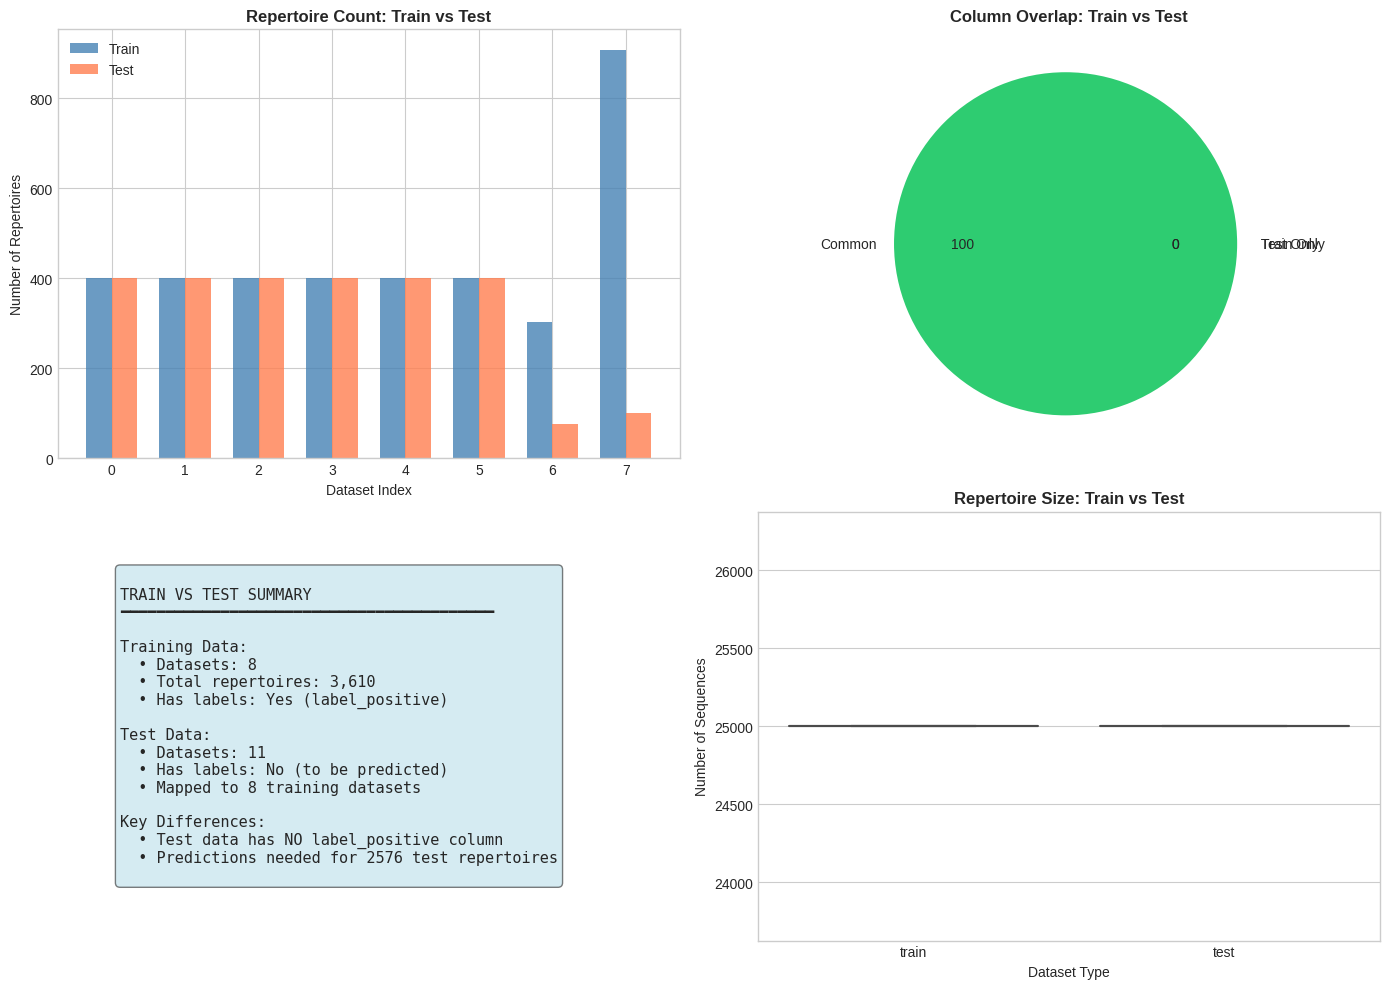

In [24]:
# =============================================================================
# TRAIN VS TEST COMPARISON
# =============================================================================

print("=" * 80)
print("TRAIN VS TEST COMPARISON")
print("=" * 80)

# Get test dataset info
test_datasets = sorted([d for d in os.listdir(TEST_DIR) if d.startswith("test_dataset_")])

print(f"\n📊 Overview:")
print(f"   • Training datasets: {len(train_datasets)}")
print(f"   • Test datasets: {len(test_datasets)}")

# Map test datasets to their training counterparts
train_test_mapping = defaultdict(list)
for test_ds in test_datasets:
    # Extract base ID (e.g., "test_dataset_1_a" -> "1")
    base_id = test_ds.replace("test_dataset_", "").split("_")[0]
    train_name = f"train_dataset_{base_id}"
    if train_name in train_datasets:
        train_test_mapping[train_name].append(test_ds)

print(f"\n📋 Train-Test Dataset Mapping:")
for train_ds, test_list in list(train_test_mapping.items())[:10]:
    print(f"   {train_ds} → {test_list}")
if len(train_test_mapping) > 10:
    print(f"   ... and {len(train_test_mapping) - 10} more")

# Analyze test data structure
print("\n" + "=" * 80)
print("TEST DATA STRUCTURE ANALYSIS")
print("=" * 80)

def get_dataset_stats(base_dir: str, dataset_name: str) -> Dict:
    """Get basic stats for a dataset."""
    dataset_path = os.path.join(base_dir, dataset_name)
    tsv_files = glob.glob(os.path.join(dataset_path, "*.tsv"))
    
    stats = {
        'dataset': dataset_name,
        'n_files': len(tsv_files),
        'has_metadata': os.path.exists(os.path.join(dataset_path, 'metadata.csv'))
    }
    
    # Sample a file to get column info
    if tsv_files:
        sample_file = pd.read_csv(tsv_files[0], sep='\t', nrows=10)
        stats['columns'] = list(sample_file.columns)
        stats['n_columns'] = len(sample_file.columns)
    
    return stats

# Compare train and test structure
comparison_data = []

for train_ds in train_datasets[:5]:  # Sample comparison
    train_stats = get_dataset_stats(TRAIN_DIR, train_ds)
    train_stats['type'] = 'train'
    comparison_data.append(train_stats)
    
    for test_ds in train_test_mapping.get(train_ds, [])[:2]:
        test_stats = get_dataset_stats(TEST_DIR, test_ds)
        test_stats['type'] = 'test'
        comparison_data.append(test_stats)

comparison_df = pd.DataFrame(comparison_data)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Number of repertoires
ax1 = axes[0, 0]
train_counts = train_metadata.groupby('dataset').size()
test_counts = []
for test_ds in test_datasets[:len(train_datasets)]:
    test_path = os.path.join(TEST_DIR, test_ds)
    n_files = len(glob.glob(os.path.join(test_path, "*.tsv")))
    test_counts.append({'dataset': test_ds, 'count': n_files})
test_counts_df = pd.DataFrame(test_counts)

x = np.arange(min(10, len(train_counts)))
width = 0.35
ax1.bar(x - width/2, train_counts.values[:10], width, label='Train', color='steelblue', alpha=0.8)
if len(test_counts_df) > 0:
    ax1.bar(x + width/2, test_counts_df['count'].values[:10], width, label='Test', color='coral', alpha=0.8)
ax1.set_xlabel('Dataset Index', fontsize=10)
ax1.set_ylabel('Number of Repertoires', fontsize=10)
ax1.set_title('Repertoire Count: Train vs Test', fontsize=12, fontweight='bold')
ax1.legend()

# Column comparison
ax2 = axes[0, 1]
if 'columns' in comparison_df.columns:
    train_cols = set()
    test_cols = set()
    for _, row in comparison_df.iterrows():
        if row['type'] == 'train':
            train_cols.update(row['columns'])
        else:
            test_cols.update(row['columns'])
    
    common = train_cols & test_cols
    train_only = train_cols - test_cols
    test_only = test_cols - train_cols
    
    data = [len(common), len(train_only), len(test_only)]
    labels = ['Common', 'Train Only', 'Test Only']
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    ax2.pie(data, labels=labels, autopct='%1.0f', colors=colors, explode=(0.02, 0.02, 0.02))
    ax2.set_title('Column Overlap: Train vs Test', fontsize=12, fontweight='bold')
    
    print("\n📋 Column Comparison:")
    print(f"   • Common columns: {common}")
    print(f"   • Train-only columns: {train_only}")
    print(f"   • Test-only columns: {test_only}")

# Summary table
ax3 = axes[1, 0]
ax3.axis('off')
summary_text = f"""
TRAIN VS TEST SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Training Data:
  • Datasets: {len(train_datasets)}
  • Total repertoires: {len(train_metadata):,}
  • Has labels: Yes (label_positive)

Test Data:
  • Datasets: {len(test_datasets)}
  • Has labels: No (to be predicted)
  • Mapped to {len(train_test_mapping)} training datasets

Key Differences:
  • Test data has NO label_positive column
  • Predictions needed for {sum(test_counts_df['count']) if len(test_counts_df) > 0 else 'N/A'} test repertoires
"""
ax3.text(0.1, 0.5, summary_text, fontsize=11, family='monospace', transform=ax3.transAxes,
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Repertoire sizes comparison
ax4 = axes[1, 1]
# Sample test repertoire sizes
test_sizes = []
for test_ds in test_datasets[:3]:
    test_path = os.path.join(TEST_DIR, test_ds)
    for file_path in glob.glob(os.path.join(test_path, "*.tsv"))[:10]:
        with open(file_path, 'r') as f:
            n_lines = sum(1 for _ in f) - 1
        test_sizes.append({'dataset': test_ds, 'n_sequences': n_lines, 'type': 'test'})

# Compare with train sizes
if not repertoire_sizes.empty:
    train_size_sample = repertoire_sizes.head(100).copy()
    train_size_sample['type'] = 'train'
    combined_sizes = pd.concat([train_size_sample[['n_sequences', 'type']], 
                                pd.DataFrame(test_sizes)[['n_sequences', 'type']]], ignore_index=True)
    sns.boxplot(data=combined_sizes, x='type', y='n_sequences', ax=ax4, palette=['steelblue', 'coral'])
    ax4.set_xlabel('Dataset Type', fontsize=10)
    ax4.set_ylabel('Number of Sequences', fontsize=10)
    ax4.set_title('Repertoire Size: Train vs Test', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Dimensionality Reduction Visualization (PCA/t-SNE)

DIMENSIONALITY REDUCTION VISUALIZATION

📊 Computing 3-mer features for train_dataset_1...


Computing k-mer features:   0%|          | 0/100 [00:00<?, ?it/s]

   Computing PCA...
   Computing t-SNE...


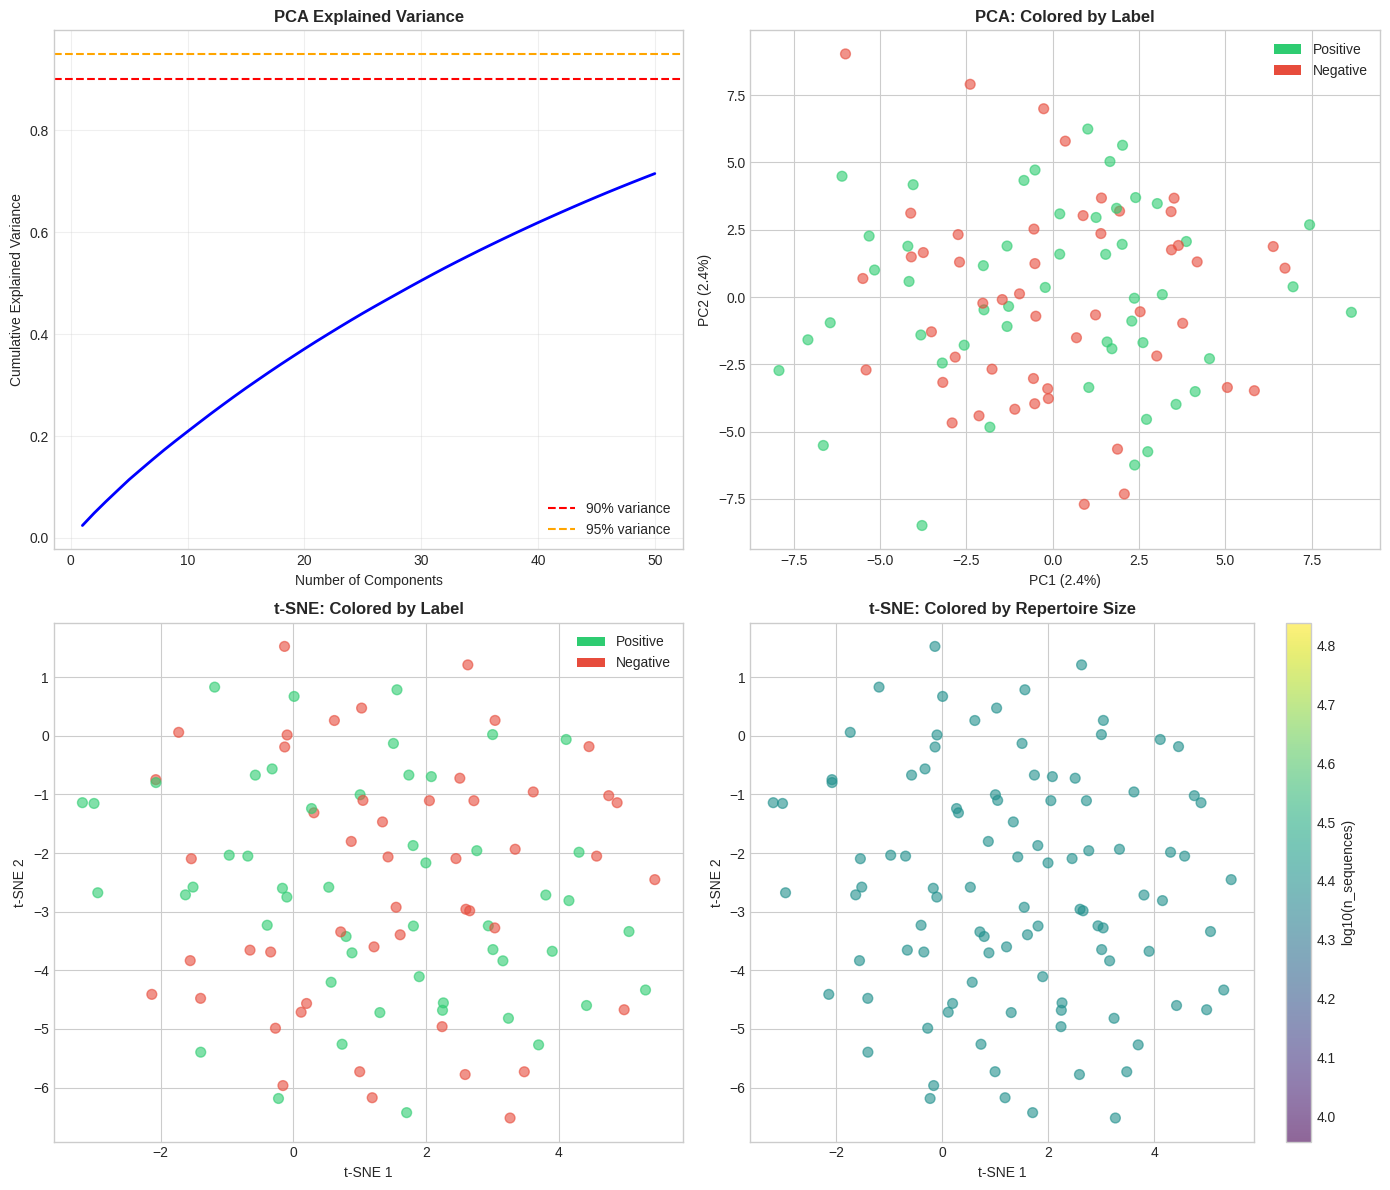


📊 Dimensionality Reduction Results:
   • Number of repertoires: 100
   • Number of k-mer features: 500
   • Components for 90% variance: 1
   • Components for 95% variance: 1

📊 Separability Test (PC1):
   • Mann-Whitney U test p-value: 9.40e-01
   • ⚠️ No significant separation


In [25]:
# =============================================================================
# DIMENSIONALITY REDUCTION VISUALIZATION
# =============================================================================
# Create k-mer features for repertoires and visualize with PCA/t-SNE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def compute_kmer_features(dataset_path: str, k: int = 3, n_files: int = 50) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Compute k-mer frequency features for repertoires."""
    metadata_path = os.path.join(dataset_path, 'metadata.csv')
    
    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        files = metadata['filename'].tolist()[:n_files]
        labels = dict(zip(metadata['filename'], metadata['label_positive']))
    else:
        files = [os.path.basename(f) for f in glob.glob(os.path.join(dataset_path, "*.tsv"))[:n_files]]
        labels = {}
    
    feature_list = []
    meta_list = []
    
    for filename in tqdm(files, desc="Computing k-mer features", leave=False):
        file_path = os.path.join(dataset_path, filename)
        
        if os.path.exists(file_path):
            rep = pd.read_csv(file_path, sep='\t')
            
            if 'junction_aa' in rep.columns:
                kmer_counts = Counter()
                for seq in rep['junction_aa'].dropna():
                    for i in range(len(seq) - k + 1):
                        kmer_counts[seq[i:i+k]] += 1
                
                # Normalize by total
                total = sum(kmer_counts.values())
                kmer_freq = {kmer: count/total for kmer, count in kmer_counts.items()}
                kmer_freq['filename'] = filename
                feature_list.append(kmer_freq)
                
                meta_list.append({
                    'filename': filename,
                    'label_positive': labels.get(filename, None),
                    'n_sequences': len(rep)
                })
    
    features_df = pd.DataFrame(feature_list).fillna(0).set_index('filename')
    meta_df = pd.DataFrame(meta_list)
    
    return features_df, meta_df

print("=" * 80)
print("DIMENSIONALITY REDUCTION VISUALIZATION")
print("=" * 80)

# Compute k-mer features for a sample dataset
sample_dataset_name = train_datasets[0]
sample_dataset_path = os.path.join(TRAIN_DIR, sample_dataset_name)

print(f"\n📊 Computing 3-mer features for {sample_dataset_name}...")
kmer_features, kmer_meta = compute_kmer_features(sample_dataset_path, k=3, n_files=100)

if len(kmer_features) > 10:
    # Select top N most variable k-mers
    kmer_var = kmer_features.var().sort_values(ascending=False)
    top_kmers = kmer_var.head(500).index
    X = kmer_features[top_kmers].values
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    print("   Computing PCA...")
    pca = PCA(n_components=min(50, X_scaled.shape[1]))
    X_pca = pca.fit_transform(X_scaled)
    
    # t-SNE on PCA-reduced features
    print("   Computing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=min(30, len(X_pca)//4), random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_pca[:, :min(30, X_pca.shape[1])])
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # PCA variance explained
    ax1 = axes[0, 0]
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    ax1.plot(range(1, len(cumsum_var)+1), cumsum_var, 'b-', linewidth=2)
    ax1.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
    ax1.axhline(y=0.95, color='orange', linestyle='--', label='95% variance')
    ax1.set_xlabel('Number of Components', fontsize=10)
    ax1.set_ylabel('Cumulative Explained Variance', fontsize=10)
    ax1.set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # PCA plot colored by label
    ax2 = axes[0, 1]
    labels_array = kmer_meta.set_index('filename').loc[kmer_features.index, 'label_positive'].values
    if pd.notna(labels_array).any():
        scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], 
                             c=['#2ecc71' if l == True else '#e74c3c' if l == False else 'gray' for l in labels_array],
                             alpha=0.6, s=50)
        ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
        ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
        ax2.set_title('PCA: Colored by Label', fontsize=12, fontweight='bold')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#2ecc71', label='Positive'),
                          Patch(facecolor='#e74c3c', label='Negative')]
        ax2.legend(handles=legend_elements, loc='upper right')
    
    # t-SNE colored by label
    ax3 = axes[1, 0]
    if pd.notna(labels_array).any():
        scatter = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1],
                             c=['#2ecc71' if l == True else '#e74c3c' if l == False else 'gray' for l in labels_array],
                             alpha=0.6, s=50)
        ax3.set_xlabel('t-SNE 1', fontsize=10)
        ax3.set_ylabel('t-SNE 2', fontsize=10)
        ax3.set_title('t-SNE: Colored by Label', fontsize=12, fontweight='bold')
        ax3.legend(handles=legend_elements, loc='upper right')
    
    # t-SNE colored by repertoire size
    ax4 = axes[1, 1]
    sizes_array = kmer_meta.set_index('filename').loc[kmer_features.index, 'n_sequences'].values
    scatter = ax4.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.log10(sizes_array), 
                         cmap='viridis', alpha=0.6, s=50)
    plt.colorbar(scatter, ax=ax4, label='log10(n_sequences)')
    ax4.set_xlabel('t-SNE 1', fontsize=10)
    ax4.set_ylabel('t-SNE 2', fontsize=10)
    ax4.set_title('t-SNE: Colored by Repertoire Size', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print(f"\n📊 Dimensionality Reduction Results:")
    print(f"   • Number of repertoires: {len(kmer_features)}")
    print(f"   • Number of k-mer features: {len(top_kmers)}")
    print(f"   • Components for 90% variance: {np.argmax(cumsum_var >= 0.9) + 1}")
    print(f"   • Components for 95% variance: {np.argmax(cumsum_var >= 0.95) + 1}")
    
    # Check for separation
    if pd.notna(labels_array).any():
        pos_mask = labels_array == True
        neg_mask = labels_array == False
        if pos_mask.sum() > 0 and neg_mask.sum() > 0:
            from scipy.stats import mannwhitneyu
            # Test separation on PC1
            stat, pval = mannwhitneyu(X_pca[pos_mask, 0], X_pca[neg_mask, 0])
            print(f"\n📊 Separability Test (PC1):")
            print(f"   • Mann-Whitney U test p-value: {pval:.2e}")
            print(f"   • {'✅ Significant separation!' if pval < 0.05 else '⚠️ No significant separation'}")
else:
    print("⚠️ Not enough data for dimensionality reduction")

---

# Part 2: Model Template & Submission Code

The following sections contain the competition template code for building the `ImmuneStatePredictor` class and generating submissions.

## Need for a uniform interface of running models

As described in the official competition page, to win the prize money, a prerequisite is that the code has to be made open-source. In addition, the top 10 submissions/teams will be invited to become co-authors in a scientific paper that involves further stress-testing of their models in a subsequent phase with many other datasets outside Kaggle platform. **To enable such further analyses and re-use of the models by the community, we strongly encourage** the participants to adhere to a code template that we provide through this repository that enables a uniform interface of running models: [https://github.com/uio-bmi/predict-airr](https://github.com/uio-bmi/predict-airr)


Ideally, all the methods can be run in a unified way, e.g.,

`python3 -m submission.main --train_dir /path/to/train_dir --test_dirs /path/to/test_dir_1 /path/to/test_dir_2 --out_dir /path/to/output_dir --n_jobs 4 --device cpu`

## Adhering to code template on Kaggle Notebooks

Those participants who make use of Kaggle resources and Kaggle notebooks to develop and run their code are also strongly encouraged to copy the code template, particularly the `ImmuneStatePredictor` class and any utility functions from the provided code template repository and adhere to the code template to enable a unified way of running different methods at a later stage. In this notebook, we copied the code template below for participants to paste into their respective Kaggle notebooks and edit as needed.

In [26]:
## imports required for the basic code template below.

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import glob
import sys
import argparse
from collections import defaultdict
from typing import Iterator, Tuple, Union, List

In [27]:
## some utility functions such as data loaders, etc.

def load_data_generator(data_dir: str, metadata_filename='metadata.csv') -> Iterator[
    Union[Tuple[str, pd.DataFrame, bool], Tuple[str, pd.DataFrame]]]:
    """
    A generator to load immune repertoire data.

    This function operates in two modes:
    1.  If metadata is found, it yields data based on the metadata file.
    2.  If metadata is NOT found, it uses glob to find and yield all '.tsv'
        files in the directory.

    Args:
        data_dir (str): The path to the directory containing the data.

    Yields:
        An iterator of tuples. The format depends on the mode:
        - With metadata: (repertoire_id, pd.DataFrame, label_positive)
        - Without metadata: (filename, pd.DataFrame)
    """
    metadata_path = os.path.join(data_dir, metadata_filename)

    if os.path.exists(metadata_path):
        metadata_df = pd.read_csv(metadata_path)
        for row in metadata_df.itertuples(index=False):
            file_path = os.path.join(data_dir, row.filename)
            try:
                repertoire_df = pd.read_csv(file_path, sep='\t')
                yield row.repertoire_id, repertoire_df, row.label_positive
            except FileNotFoundError:
                print(f"Warning: File '{row.filename}' listed in metadata not found. Skipping.")
                continue
    else:
        search_pattern = os.path.join(data_dir, '*.tsv')
        tsv_files = glob.glob(search_pattern)
        for file_path in sorted(tsv_files):
            try:
                filename = os.path.basename(file_path)
                repertoire_df = pd.read_csv(file_path, sep='\t')
                yield filename, repertoire_df
            except Exception as e:
                print(f"Warning: Could not read file '{file_path}'. Error: {e}. Skipping.")
                continue


def load_full_dataset(data_dir: str) -> pd.DataFrame:
    """
    Loads all TSV files from a directory and concatenates them into a single DataFrame.

    This function handles two scenarios:
    1. If metadata.csv exists, it loads data based on the metadata and adds
       'repertoire_id' and 'label_positive' columns.
    2. If metadata.csv does not exist, it loads all .tsv files and adds
       a 'filename' column as an identifier.

    Args:
        data_dir (str): The path to the data directory.

    Returns:
        pd.DataFrame: A single, concatenated DataFrame containing all the data.
    """
    metadata_path = os.path.join(data_dir, 'metadata.csv')
    df_list = []
    data_loader = load_data_generator(data_dir=data_dir)

    if os.path.exists(metadata_path):
        metadata_df = pd.read_csv(metadata_path)
        total_files = len(metadata_df)
        for rep_id, data_df, label in tqdm(data_loader, total=total_files, desc="Loading files"):
            data_df['ID'] = rep_id
            data_df['label_positive'] = label
            df_list.append(data_df)
    else:
        search_pattern = os.path.join(data_dir, '*.tsv')
        total_files = len(glob.glob(search_pattern))
        for filename, data_df in tqdm(data_loader, total=total_files, desc="Loading files"):
            data_df['ID'] = os.path.basename(filename).replace(".tsv", "")
            df_list.append(data_df)

    if not df_list:
        print("Warning: No data files were loaded.")
        return pd.DataFrame()

    full_dataset_df = pd.concat(df_list, ignore_index=True)
    return full_dataset_df


def load_and_encode_kmers(data_dir: str, k: int = 3) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Loading and k-mer encoding of repertoire data.

    Args:
        data_dir: Path to data directory
        k: K-mer length

    Returns:
        Tuple of (encoded_features_df, metadata_df)
        metadata_df always contains 'ID', and 'label_positive' if available
    """
    from collections import Counter

    metadata_path = os.path.join(data_dir, 'metadata.csv')
    data_loader = load_data_generator(data_dir=data_dir)

    repertoire_features = []
    metadata_records = []

    search_pattern = os.path.join(data_dir, '*.tsv')
    total_files = len(glob.glob(search_pattern))

    for item in tqdm(data_loader, total=total_files, desc=f"Encoding {k}-mers"):
        if os.path.exists(metadata_path):
            rep_id, data_df, label = item
        else:
            filename, data_df = item
            rep_id = os.path.basename(filename).replace(".tsv", "")
            label = None

        kmer_counts = Counter()
        for seq in data_df['junction_aa'].dropna():
            for i in range(len(seq) - k + 1):
                kmer_counts[seq[i:i + k]] += 1

        repertoire_features.append({
            'ID': rep_id,
            **kmer_counts
        })

        metadata_record = {'ID': rep_id}
        if label is not None:
            metadata_record['label_positive'] = label
        metadata_records.append(metadata_record)

        del data_df, kmer_counts

    features_df = pd.DataFrame(repertoire_features).fillna(0).set_index('ID')
    features_df.fillna(0)
    metadata_df = pd.DataFrame(metadata_records)

    return features_df, metadata_df


def save_tsv(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, sep='\t', index=False)


def get_repertoire_ids(data_dir: str) -> list:
    """
    Retrieves repertoire IDs from the metadata file or filenames in the directory.

    Args:
        data_dir (str): The path to the data directory.

    Returns:
        list: A list of repertoire IDs.
    """
    metadata_path = os.path.join(data_dir, 'metadata.csv')

    if os.path.exists(metadata_path):
        metadata_df = pd.read_csv(metadata_path)
        repertoire_ids = metadata_df['repertoire_id'].tolist()
    else:
        search_pattern = os.path.join(data_dir, '*.tsv')
        tsv_files = glob.glob(search_pattern)
        repertoire_ids = [os.path.basename(f).replace('.tsv', '') for f in sorted(tsv_files)]

    return repertoire_ids


def generate_random_top_sequences_df(n_seq: int = 50000) -> pd.DataFrame:
    """
    Generates a random DataFrame simulating top important sequences.

    Args:
        n_seq (int): Number of sequences to generate.

    Returns:
        pd.DataFrame: A DataFrame with columns 'ID', 'dataset', 'junction_aa', 'v_call', 'j_call'.
    """
    seqs = set()
    while len(seqs) < n_seq:
        seq = ''.join(np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'), size=15))
        seqs.add(seq)
    data = {
        'junction_aa': list(seqs),
        'v_call': ['TRBV20-1'] * n_seq,
        'j_call': ['TRBJ2-7'] * n_seq,
        'importance_score': np.random.rand(n_seq)
    }
    return pd.DataFrame(data)


def validate_dirs_and_files(train_dir: str, test_dirs: List[str], out_dir: str) -> None:
    assert os.path.isdir(train_dir), f"Train directory `{train_dir}` does not exist."
    train_tsvs = glob.glob(os.path.join(train_dir, "*.tsv"))
    assert train_tsvs, f"No .tsv files found in train directory `{train_dir}`."
    metadata_path = os.path.join(train_dir, "metadata.csv")
    assert os.path.isfile(metadata_path), f"`metadata.csv` not found in train directory `{train_dir}`."

    for test_dir in test_dirs:
        assert os.path.isdir(test_dir), f"Test directory `{test_dir}` does not exist."
        test_tsvs = glob.glob(os.path.join(test_dir, "*.tsv"))
        assert test_tsvs, f"No .tsv files found in test directory `{test_dir}`."

    try:
        os.makedirs(out_dir, exist_ok=True)
        test_file = os.path.join(out_dir, "test_write_permission.tmp")
        with open(test_file, "w") as f:
            f.write("test")
        os.remove(test_file)
    except Exception as e:
        print(f"Failed to create or write to output directory `{out_dir}`: {e}")
        sys.exit(1)


def concatenate_output_files(out_dir: str) -> None:
    """
    Concatenates all test predictions and important sequences TSV files from the output directory.

    This function finds all files matching the patterns:
    - *_test_predictions.tsv
    - *_important_sequences.tsv

    and concatenates them to match the expected output format of submissions.csv.

    Args:
        out_dir (str): Path to the output directory containing the TSV files.

    Returns:
        pd.DataFrame: Concatenated DataFrame with predictions followed by important sequences.
                     Columns: ['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call']
    """
    predictions_pattern = os.path.join(out_dir, '*_test_predictions.tsv')
    sequences_pattern = os.path.join(out_dir, '*_important_sequences.tsv')

    predictions_files = sorted(glob.glob(predictions_pattern))
    sequences_files = sorted(glob.glob(sequences_pattern))

    df_list = []

    for pred_file in predictions_files:
        try:
            df = pd.read_csv(pred_file, sep='\t')
            df_list.append(df)
        except Exception as e:
            print(f"Warning: Could not read predictions file '{pred_file}'. Error: {e}. Skipping.")
            continue

    for seq_file in sequences_files:
        try:
            df = pd.read_csv(seq_file, sep='\t')
            df_list.append(df)
        except Exception as e:
            print(f"Warning: Could not read sequences file '{seq_file}'. Error: {e}. Skipping.")
            continue

    if not df_list:
        print("Warning: No output files were found to concatenate.")
        concatenated_df = pd.DataFrame(
            columns=['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call'])
    else:
        concatenated_df = pd.concat(df_list, ignore_index=True)
    submissions_file = os.path.join(out_dir, 'submissions.csv')
    concatenated_df.to_csv(submissions_file, index=False)
    print(f"Concatenated output written to `{submissions_file}`.")


def get_dataset_pairs(train_dir: str, test_dir: str) -> List[Tuple[str, List[str]]]:
    """Returns list of (train_path, [test_paths]) tuples for dataset pairs."""
    test_groups = defaultdict(list)
    for test_name in sorted(os.listdir(test_dir)):
        if test_name.startswith("test_dataset_"):
            base_id = test_name.replace("test_dataset_", "").split("_")[0]
            test_groups[base_id].append(os.path.join(test_dir, test_name))

    pairs = []
    for train_name in sorted(os.listdir(train_dir)):
        if train_name.startswith("train_dataset_"):
            train_id = train_name.replace("train_dataset_", "")
            train_path = os.path.join(train_dir, train_name)
            pairs.append((train_path, test_groups.get(train_id, [])))

    return pairs

---

# Part 3: Model Implementation Modules

## Strategy Overview

Our approach uses a **3-stage pipeline**:

1. **Public Clone Enrichment Database** - Identifies disease-associated sequences (solves Task 2) and provides a killer feature for Task 1
2. **Feature Extraction** - Combines repertoire statistics, V/J gene usage, k-mers, and enrichment scores
3. **Gradient Boosting Classification** - LightGBM with stratified CV for robust predictions

## Module 1: Public Clone Enrichment Database

The **key biological insight**: Disease-associated T-cells undergo clonal expansion and are often shared (public) across patients with the same condition. We compute enrichment scores using log-odds ratios to identify which sequences are most strongly associated with the positive label.

This module:
- **Directly solves Task 2** (identifying important sequences)
- **Provides a powerful feature for Task 1** (sum of enrichment scores per repertoire)

In [ ]:
# =============================================================================
# MODULE 1: PUBLIC CLONE ENRICHMENT DATABASE
# =============================================================================

class PublicCloneDatabase:
    """
    Builds a database of public (shared) clones and computes their disease enrichment.
    
    Key idea: If a sequence appears in 80% of positive samples but only 10% of negative,
    it's strongly associated with disease. We capture this with log-odds enrichment scores.
    """
    
    def __init__(self, min_occurrence: int = 2, smoothing: float = 1.0):
        """
        Args:
            min_occurrence: Minimum number of repertoires a sequence must appear in
            smoothing: Laplace smoothing for log-odds calculation (prevents inf)
        """
        self.min_occurrence = min_occurrence
        self.smoothing = smoothing
        
        # Will be populated by fit()
        self.sequence_stats = {}  # seq -> {n_pos, n_neg, v_call, j_call, enrichment}
        self.n_positive_repertoires = 0
        self.n_negative_repertoires = 0
        self.is_fitted = False
    
    def fit(self, train_dir: str) -> 'PublicCloneDatabase':
        """
        Scan all training repertoires and compute enrichment scores.
        
        Args:
            train_dir: Path to training dataset directory
            
        Returns:
            self
        """
        print(f"Building public clone database from {train_dir}...")
        
        # Load metadata to get labels
        metadata_path = os.path.join(train_dir, 'metadata.csv')
        if not os.path.exists(metadata_path):
            raise ValueError(f"No metadata.csv found in {train_dir}")
        
        metadata = pd.read_csv(metadata_path)
        labels = dict(zip(metadata['filename'], metadata['label_positive']))
        
        # Count positive and negative repertoires
        self.n_positive_repertoires = sum(1 for l in labels.values() if l == 1 or l == True)
        self.n_negative_repertoires = sum(1 for l in labels.values() if l == 0 or l == False)
        
        print(f"   Repertoires: {self.n_positive_repertoires} positive, {self.n_negative_repertoires} negative")
        
        # Track sequence occurrences
        # Key: junction_aa sequence
        # Value: {'n_pos': count in positive, 'n_neg': count in negative, 'v_calls': set, 'j_calls': set}
        seq_tracker = defaultdict(lambda: {'n_pos': 0, 'n_neg': 0, 'v_calls': set(), 'j_calls': set()})
        
        # Scan all repertoires
        for filename in tqdm(metadata['filename'].tolist(), desc="Scanning repertoires"):
            file_path = os.path.join(train_dir, filename)
            if not os.path.exists(file_path):
                continue
            
            label = labels[filename]
            is_positive = (label == 1 or label == True)
            
            # Load repertoire
            rep_df = pd.read_csv(file_path, sep='\t')
            
            if 'junction_aa' not in rep_df.columns:
                continue
            
            # Get unique sequences in this repertoire (we count presence, not abundance)
            unique_seqs = rep_df.dropna(subset=['junction_aa']).drop_duplicates(subset=['junction_aa'])
            
            for _, row in unique_seqs.iterrows():
                seq = row['junction_aa']
                
                if is_positive:
                    seq_tracker[seq]['n_pos'] += 1
                else:
                    seq_tracker[seq]['n_neg'] += 1
                
                # Track V/J calls (take first non-null)
                if 'v_call' in row and pd.notna(row['v_call']):
                    seq_tracker[seq]['v_calls'].add(row['v_call'])
                if 'j_call' in row and pd.notna(row['j_call']):
                    seq_tracker[seq]['j_calls'].add(row['j_call'])
        
        # Compute enrichment scores for sequences meeting min_occurrence threshold
        print(f"   Computing enrichment scores...")
        
        for seq, stats in seq_tracker.items():
            total_occurrence = stats['n_pos'] + stats['n_neg']
            
            if total_occurrence < self.min_occurrence:
                continue
            
            # Log-odds ratio with Laplace smoothing
            # P(positive | seq) vs P(positive | no seq)
            # Simplified: log((n_pos + s) / (n_neg + s)) - log(N_pos / N_neg)
            
            pos_rate = (stats['n_pos'] + self.smoothing) / (self.n_positive_repertoires + 2 * self.smoothing)
            neg_rate = (stats['n_neg'] + self.smoothing) / (self.n_negative_repertoires + 2 * self.smoothing)
            
            # Log-odds enrichment
            enrichment = np.log2((pos_rate + 1e-10) / (neg_rate + 1e-10))
            
            # Pick most common V/J call
            v_call = max(stats['v_calls'], key=lambda x: 1) if stats['v_calls'] else 'Unknown'
            j_call = max(stats['j_calls'], key=lambda x: 1) if stats['j_calls'] else 'Unknown'
            
            self.sequence_stats[seq] = {
                'n_pos': stats['n_pos'],
                'n_neg': stats['n_neg'],
                'total': total_occurrence,
                'enrichment': enrichment,
                'v_call': v_call,
                'j_call': j_call
            }
        
        self.is_fitted = True
        print(f"   ✅ Database built with {len(self.sequence_stats):,} public sequences")
        
        # Show enrichment distribution
        enrichments = [s['enrichment'] for s in self.sequence_stats.values()]
        if enrichments:
            print(f"   Enrichment range: [{min(enrichments):.2f}, {max(enrichments):.2f}]")
            print(f"   Strongly positive (>1): {sum(1 for e in enrichments if e > 1):,}")
            print(f"   Strongly negative (<-1): {sum(1 for e in enrichments if e < -1):,}")
        
        return self
    
    def get_enrichment_features(self, repertoire_df: pd.DataFrame) -> dict:
        """
        Compute enrichment-based features for a single repertoire.
        
        Args:
            repertoire_df: DataFrame with junction_aa column
            
        Returns:
            dict of features
        """
        if not self.is_fitted:
            raise RuntimeError("Database not fitted. Call fit() first.")
        
        features = {}
        
        if 'junction_aa' not in repertoire_df.columns:
            # Return zeros if no sequences
            features['enrichment_sum'] = 0.0
            features['enrichment_mean'] = 0.0
            features['enrichment_max'] = 0.0
            features['enrichment_min'] = 0.0
            features['enrichment_std'] = 0.0
            features['n_public_clones'] = 0
            features['frac_public_clones'] = 0.0
            features['n_positive_enriched'] = 0
            features['n_negative_enriched'] = 0
            return features
        
        # Get unique sequences in this repertoire
        unique_seqs = repertoire_df['junction_aa'].dropna().unique()
        
        # Collect enrichment scores for sequences in our database
        enrichments = []
        for seq in unique_seqs:
            if seq in self.sequence_stats:
                enrichments.append(self.sequence_stats[seq]['enrichment'])
        
        # Compute features
        n_unique = len(unique_seqs)
        n_public = len(enrichments)
        
        features['n_public_clones'] = n_public
        features['frac_public_clones'] = n_public / n_unique if n_unique > 0 else 0.0
        
        if enrichments:
            enrichments = np.array(enrichments)
            features['enrichment_sum'] = float(np.sum(enrichments))
            features['enrichment_mean'] = float(np.mean(enrichments))
            features['enrichment_max'] = float(np.max(enrichments))
            features['enrichment_min'] = float(np.min(enrichments))
            features['enrichment_std'] = float(np.std(enrichments))
            features['n_positive_enriched'] = int(np.sum(enrichments > 0))
            features['n_negative_enriched'] = int(np.sum(enrichments < 0))
            
            # Weighted sum by enrichment magnitude (emphasizes strong signals)
            features['enrichment_weighted_sum'] = float(np.sum(enrichments * np.abs(enrichments)))
            
            # Percentiles
            features['enrichment_p75'] = float(np.percentile(enrichments, 75))
            features['enrichment_p90'] = float(np.percentile(enrichments, 90))
            features['enrichment_p95'] = float(np.percentile(enrichments, 95))
        else:
            features['enrichment_sum'] = 0.0
            features['enrichment_mean'] = 0.0
            features['enrichment_max'] = 0.0
            features['enrichment_min'] = 0.0
            features['enrichment_std'] = 0.0
            features['n_positive_enriched'] = 0
            features['n_negative_enriched'] = 0
            features['enrichment_weighted_sum'] = 0.0
            features['enrichment_p75'] = 0.0
            features['enrichment_p90'] = 0.0
            features['enrichment_p95'] = 0.0
        
        return features
    
    def get_top_sequences(self, top_k: int = 50000) -> pd.DataFrame:
        """
        Get top disease-associated sequences (for Task 2).
        
        Args:
            top_k: Number of top sequences to return
            
        Returns:
            DataFrame with columns: junction_aa, v_call, j_call, enrichment (sorted by enrichment desc)
        """
        if not self.is_fitted:
            raise RuntimeError("Database not fitted. Call fit() first.")
        
        # Convert to list of dicts for DataFrame
        records = [
            {
                'junction_aa': seq,
                'v_call': stats['v_call'],
                'j_call': stats['j_call'],
                'enrichment': stats['enrichment'],
                'n_pos': stats['n_pos'],
                'n_neg': stats['n_neg']
            }
            for seq, stats in self.sequence_stats.items()
        ]
        
        df = pd.DataFrame(records)
        
        if len(df) == 0:
            return pd.DataFrame(columns=['junction_aa', 'v_call', 'j_call', 'enrichment'])
        
        # Sort by enrichment (highest = most disease-associated)
        df = df.sort_values('enrichment', ascending=False).head(top_k)
        
        return df[['junction_aa', 'v_call', 'j_call', 'enrichment']]


print("✅ Module 1: PublicCloneDatabase defined")
print("   • fit(train_dir): Builds enrichment database from training data")
print("   • get_enrichment_features(repertoire_df): Computes per-repertoire enrichment features")
print("   • get_top_sequences(top_k): Returns top disease-associated sequences for Task 2")

## Module 2: Repertoire Feature Extractor

Combines multiple signal sources into a unified feature vector per repertoire:
- **Repertoire statistics**: CDR3 lengths, diversity metrics, clonality
- **Gene usage**: V/J/D gene frequencies and entropy
- **K-mer features**: Local sequence motifs (using pre-built vocabulary)
- **Public clone enrichment**: Features from Module 1

In [ ]:
# =============================================================================
# MODULE 2: REPERTOIRE FEATURE EXTRACTOR
# =============================================================================

class RepertoireFeatureExtractor:
    """
    Unified feature extraction combining all signal sources.
    """
    
    def __init__(self, 
                 use_kmer_features: bool = True,
                 kmer_k: int = 3,
                 kmer_max_features: int = 300,
                 use_enrichment_features: bool = True):
        """
        Args:
            use_kmer_features: Whether to include k-mer features
            kmer_k: K-mer size (default 3)
            kmer_max_features: Max number of k-mer features
            use_enrichment_features: Whether to include public clone enrichment features
        """
        self.use_kmer_features = use_kmer_features
        self.kmer_k = kmer_k
        self.kmer_max_features = kmer_max_features
        self.use_enrichment_features = use_enrichment_features
        
        # Will be set during fit
        self.kmer_vocab = None
        self.clone_database = None
        self.feature_names = None
        self.is_fitted = False
    
    def fit(self, train_dir: str, clone_database: PublicCloneDatabase = None) -> 'RepertoireFeatureExtractor':
        """
        Fit the feature extractor (build k-mer vocabulary).
        
        Args:
            train_dir: Path to training data directory
            clone_database: Pre-fitted PublicCloneDatabase (optional)
            
        Returns:
            self
        """
        print("Fitting RepertoireFeatureExtractor...")
        
        # Store clone database reference
        if self.use_enrichment_features:
            if clone_database is None:
                print("   Building PublicCloneDatabase...")
                self.clone_database = PublicCloneDatabase(min_occurrence=2)
                self.clone_database.fit(train_dir)
            else:
                self.clone_database = clone_database
        
        # Build k-mer vocabulary from training data
        if self.use_kmer_features:
            print("   Building k-mer vocabulary...")
            self.kmer_vocab = self._build_kmer_vocabulary(train_dir)
            print(f"   ✅ K-mer vocabulary: {len(self.kmer_vocab)} {self.kmer_k}-mers")
        
        self.is_fitted = True
        return self
    
    def _build_kmer_vocabulary(self, train_dir: str) -> list:
        """Build k-mer vocabulary from training repertoires."""
        metadata_path = os.path.join(train_dir, 'metadata.csv')
        metadata = pd.read_csv(metadata_path)
        
        global_kmer_counts = Counter()
        total_kmers = 0
        
        # Sample repertoires for vocabulary building (use all but limit sequences per rep)
        for filename in tqdm(metadata['filename'].tolist(), desc="Building k-mer vocab", leave=False):
            file_path = os.path.join(train_dir, filename)
            if not os.path.exists(file_path):
                continue
            
            rep_df = pd.read_csv(file_path, sep='\t')
            
            if 'junction_aa' not in rep_df.columns:
                continue
            
            # Sample sequences for efficiency
            seqs = rep_df['junction_aa'].dropna()
            if len(seqs) > 10000:
                seqs = seqs.sample(n=10000, random_state=42)
            
            for seq in seqs:
                if len(seq) >= self.kmer_k:
                    for i in range(len(seq) - self.kmer_k + 1):
                        kmer = seq[i:i+self.kmer_k]
                        global_kmer_counts[kmer] += 1
                        total_kmers += 1
        
        # Select top k-mers by frequency
        vocab = [kmer for kmer, _ in global_kmer_counts.most_common(self.kmer_max_features)]
        
        return vocab
    
    def extract_features(self, repertoire_df: pd.DataFrame) -> dict:
        """
        Extract all features from a single repertoire.
        
        Args:
            repertoire_df: DataFrame containing repertoire sequences
            
        Returns:
            dict: Feature dictionary
        """
        features = {}
        
        # 1. Basic repertoire features (using existing function from EDA)
        basic_features = self._extract_basic_features(repertoire_df)
        features.update(basic_features)
        
        # 2. K-mer features
        if self.use_kmer_features and self.kmer_vocab:
            kmer_features = self._extract_kmer_features(repertoire_df)
            features.update(kmer_features)
        
        # 3. Enrichment features
        if self.use_enrichment_features and self.clone_database:
            enrichment_features = self.clone_database.get_enrichment_features(repertoire_df)
            features.update(enrichment_features)
        
        return features
    
    def _extract_basic_features(self, df: pd.DataFrame) -> dict:
        """Extract basic repertoire statistics."""
        features = {}
        
        # Determine weight column
        weight_col = None
        if 'templates' in df.columns:
            weight_col = 'templates'
        elif 'duplicate_count' in df.columns:
            weight_col = 'duplicate_count'
        
        weights = df[weight_col].values if weight_col else np.ones(len(df))
        total_weight = weights.sum()
        
        # Basic stats
        features['n_unique_sequences'] = len(df)
        features['total_templates'] = float(total_weight)
        features['clonality'] = 1 - (len(df) / total_weight) if total_weight > 0 else 0
        
        # CDR3 length statistics
        if 'junction_aa' in df.columns:
            cdr3_lengths = df['junction_aa'].dropna().str.len()
            if len(cdr3_lengths) > 0:
                features['cdr3_length_mean'] = float(cdr3_lengths.mean())
                features['cdr3_length_std'] = float(cdr3_lengths.std()) if len(cdr3_lengths) > 1 else 0.0
                features['cdr3_length_median'] = float(cdr3_lengths.median())
                features['cdr3_length_min'] = float(cdr3_lengths.min())
                features['cdr3_length_max'] = float(cdr3_lengths.max())
                features['cdr3_length_q25'] = float(cdr3_lengths.quantile(0.25))
                features['cdr3_length_q75'] = float(cdr3_lengths.quantile(0.75))
                features['cdr3_short_frac'] = float((cdr3_lengths < 10).mean())
                features['cdr3_long_frac'] = float((cdr3_lengths > 18).mean())
        
        # V gene usage
        if 'v_call' in df.columns:
            v_genes = df['v_call'].dropna()
            if len(v_genes) > 0:
                features['n_unique_v_genes'] = v_genes.nunique()
                v_counts = v_genes.value_counts(normalize=True)
                features['v_gene_entropy'] = float(entropy(v_counts))
                features['v_gene_top1_freq'] = float(v_counts.iloc[0]) if len(v_counts) > 0 else 0
                features['v_gene_top5_freq'] = float(v_counts.head(5).sum())
        
        # J gene usage
        if 'j_call' in df.columns:
            j_genes = df['j_call'].dropna()
            if len(j_genes) > 0:
                features['n_unique_j_genes'] = j_genes.nunique()
                j_counts = j_genes.value_counts(normalize=True)
                features['j_gene_entropy'] = float(entropy(j_counts))
                features['j_gene_top1_freq'] = float(j_counts.iloc[0]) if len(j_counts) > 0 else 0
        
        # D gene usage
        if 'd_call' in df.columns:
            d_genes = df['d_call'].dropna()
            features['d_gene_missing_frac'] = float(df['d_call'].isna().mean())
            if len(d_genes) > 0:
                features['n_unique_d_genes'] = d_genes.nunique()
        
        # V-J pairing
        if 'v_call' in df.columns and 'j_call' in df.columns:
            vj_pairs = df[['v_call', 'j_call']].dropna()
            if len(vj_pairs) > 0:
                vj_combined = vj_pairs['v_call'] + '_' + vj_pairs['j_call']
                features['n_unique_vj_pairs'] = vj_combined.nunique()
                vj_counts = vj_combined.value_counts(normalize=True)
                features['vj_pair_entropy'] = float(entropy(vj_counts))
        
        # Amino acid composition
        if 'junction_aa' in df.columns:
            all_aa = ''.join(df['junction_aa'].dropna().tolist())
            if len(all_aa) > 0:
                aa_counter = Counter(all_aa)
                total_aa = sum(aa_counter.values())
                
                hydrophobic = set('AILMFVPWG')
                charged = set('DEKRH')
                aromatic = set('FWY')
                
                features['aa_hydrophobic_frac'] = sum(aa_counter.get(aa, 0) for aa in hydrophobic) / total_aa
                features['aa_charged_frac'] = sum(aa_counter.get(aa, 0) for aa in charged) / total_aa
                features['aa_aromatic_frac'] = sum(aa_counter.get(aa, 0) for aa in aromatic) / total_aa
                features['aa_cysteine_frac'] = aa_counter.get('C', 0) / total_aa
        
        # Clone size distribution
        if weight_col and weight_col in df.columns:
            clone_sizes = df[weight_col].values
            if len(clone_sizes) > 0:
                features['clone_size_mean'] = float(np.mean(clone_sizes))
                features['clone_size_std'] = float(np.std(clone_sizes)) if len(clone_sizes) > 1 else 0.0
                features['clone_size_max'] = float(np.max(clone_sizes))
                
                # Top clone fractions
                sorted_sizes = np.sort(clone_sizes)[::-1]
                total_size = sorted_sizes.sum()
                if total_size > 0:
                    features['top1_clone_frac'] = float(sorted_sizes[0] / total_size)
                    features['top10_clone_frac'] = float(sorted_sizes[:10].sum() / total_size) if len(sorted_sizes) >= 10 else 1.0
                    features['top100_clone_frac'] = float(sorted_sizes[:100].sum() / total_size) if len(sorted_sizes) >= 100 else 1.0
        
        return features
    
    def _extract_kmer_features(self, df: pd.DataFrame) -> dict:
        """Extract k-mer frequency features."""
        features = {f'kmer_{self.kmer_k}_{kmer}': 0.0 for kmer in self.kmer_vocab}
        
        if 'junction_aa' not in df.columns:
            return features
        
        # Determine weights
        weight_col = None
        if 'templates' in df.columns:
            weight_col = 'templates'
        elif 'duplicate_count' in df.columns:
            weight_col = 'duplicate_count'
        
        # Count k-mers
        total_weight = 0
        for idx, row in df.iterrows():
            seq = row.get('junction_aa')
            if pd.isna(seq) or len(seq) < self.kmer_k:
                continue
            
            weight = row[weight_col] if weight_col else 1
            
            for i in range(len(seq) - self.kmer_k + 1):
                kmer = seq[i:i+self.kmer_k]
                if kmer in self.kmer_vocab:
                    features[f'kmer_{self.kmer_k}_{kmer}'] += weight
                total_weight += weight
        
        # Normalize
        if total_weight > 0:
            for key in features:
                features[key] /= total_weight
        
        return features
    
    def extract_all_features(self, data_dir: str, n_jobs: int = 1) -> Tuple[pd.DataFrame, Optional[pd.Series], List[str]]:
        """
        Extract features for all repertoires in a directory.
        
        Args:
            data_dir: Path to data directory
            n_jobs: Number of parallel jobs (not used yet, for future optimization)
            
        Returns:
            X: Feature DataFrame
            y: Labels Series (None if no metadata)
            ids: List of repertoire IDs
        """
        metadata_path = os.path.join(data_dir, 'metadata.csv')
        has_labels = os.path.exists(metadata_path)
        
        if has_labels:
            metadata = pd.read_csv(metadata_path)
            files = metadata['filename'].tolist()
            labels = dict(zip(metadata['filename'], metadata['label_positive']))
            rep_ids = dict(zip(metadata['filename'], metadata['repertoire_id']))
        else:
            files = [os.path.basename(f) for f in glob.glob(os.path.join(data_dir, "*.tsv"))]
            labels = {}
            rep_ids = {f: f.replace('.tsv', '') for f in files}
        
        all_features = []
        all_labels = []
        all_ids = []
        
        for filename in tqdm(files, desc=f"Extracting features from {os.path.basename(data_dir)}"):
            file_path = os.path.join(data_dir, filename)
            if not os.path.exists(file_path):
                continue
            
            rep_df = pd.read_csv(file_path, sep='\t')
            features = self.extract_features(rep_df)
            
            all_features.append(features)
            all_ids.append(rep_ids.get(filename, filename.replace('.tsv', '')))
            
            if has_labels:
                all_labels.append(labels.get(filename))
        
        X = pd.DataFrame(all_features, index=all_ids)
        y = pd.Series(all_labels, index=all_ids, name='label') if has_labels else None
        
        self.feature_names = list(X.columns)
        
        return X, y, all_ids


print("✅ Module 2: RepertoireFeatureExtractor defined")
print("   • fit(train_dir): Builds k-mer vocabulary and links to clone database")
print("   • extract_features(repertoire_df): Extracts features for single repertoire")
print("   • extract_all_features(data_dir): Extracts features for all repertoires in directory")

## Module 3: Gradient Boosting Predictor

LightGBM classifier with:
- Stratified K-fold cross-validation
- Early stopping to prevent overfitting
- Feature importance tracking for interpretability
- Averaged predictions across folds for robustness

In [ ]:
# =============================================================================
# MODULE 3: GRADIENT BOOSTING PREDICTOR
# =============================================================================

# Import LightGBM (with fallback message if not available)
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️ LightGBM not installed. Install with: pip install lightgbm")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss


class GradientBoostingPredictor:
    """
    LightGBM-based classifier with cross-validation and early stopping.
    """
    
    def __init__(self, 
                 n_folds: int = 5,
                 n_estimators: int = 1000,
                 learning_rate: float = 0.05,
                 num_leaves: int = 31,
                 min_data_in_leaf: int = 20,
                 feature_fraction: float = 0.8,
                 bagging_fraction: float = 0.8,
                 bagging_freq: int = 5,
                 lambda_l1: float = 0.1,
                 lambda_l2: float = 0.1,
                 early_stopping_rounds: int = 50,
                 random_state: int = 42,
                 n_jobs: int = 1,
                 verbose: bool = True):
        """
        Initialize the predictor with LightGBM hyperparameters.
        """
        self.n_folds = n_folds
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.num_leaves = num_leaves
        self.min_data_in_leaf = min_data_in_leaf
        self.feature_fraction = feature_fraction
        self.bagging_fraction = bagging_fraction
        self.bagging_freq = bagging_freq
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2
        self.early_stopping_rounds = early_stopping_rounds
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        # Will be populated by fit()
        self.models = []
        self.feature_names = None
        self.feature_importance_ = None
        self.oof_predictions_ = None
        self.oof_score_ = None
        self.is_fitted = False
    
    def _get_lgb_params(self) -> dict:
        """Get LightGBM parameters dictionary."""
        return {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': self.num_leaves,
            'learning_rate': self.learning_rate,
            'feature_fraction': self.feature_fraction,
            'bagging_fraction': self.bagging_fraction,
            'bagging_freq': self.bagging_freq,
            'min_data_in_leaf': self.min_data_in_leaf,
            'lambda_l1': self.lambda_l1,
            'lambda_l2': self.lambda_l2,
            'verbosity': -1,
            'n_jobs': self.n_jobs,
            'seed': self.random_state,
            'force_col_wise': True  # Prevents warning on small datasets
        }
    
    def fit(self, X: pd.DataFrame, y: pd.Series) -> 'GradientBoostingPredictor':
        """
        Train the model with cross-validation.
        
        Args:
            X: Feature DataFrame
            y: Label Series
            
        Returns:
            self
        """
        if not LIGHTGBM_AVAILABLE:
            raise ImportError("LightGBM is required. Install with: pip install lightgbm")
        
        print(f"Training GradientBoostingPredictor with {self.n_folds}-fold CV...")
        print(f"   Features: {X.shape[1]}, Samples: {X.shape[0]}")
        
        self.feature_names = list(X.columns)
        
        # Handle missing values (LightGBM can handle NaN, but let's be explicit)
        X_filled = X.fillna(-999)
        
        # Initialize
        self.models = []
        self.oof_predictions_ = np.zeros(len(y))
        feature_importance = np.zeros(len(self.feature_names))
        
        # Stratified K-fold
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_filled, y)):
            if self.verbose:
                print(f"\n   Fold {fold + 1}/{self.n_folds}:")
            
            X_train, X_val = X_filled.iloc[train_idx], X_filled.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Create LightGBM datasets
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            # Train with early stopping
            model = lgb.train(
                self._get_lgb_params(),
                train_data,
                num_boost_round=self.n_estimators,
                valid_sets=[val_data],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=self.early_stopping_rounds, verbose=False),
                    lgb.log_evaluation(period=0)  # Suppress iteration logs
                ]
            )
            
            self.models.append(model)
            
            # OOF predictions
            self.oof_predictions_[val_idx] = model.predict(X_val)
            
            # Accumulate feature importance
            feature_importance += model.feature_importance(importance_type='gain')
            
            # Fold score
            fold_auc = roc_auc_score(y_val, self.oof_predictions_[val_idx])
            if self.verbose:
                print(f"      AUC: {fold_auc:.4f} (best iteration: {model.best_iteration})")
        
        # Average feature importance
        self.feature_importance_ = feature_importance / self.n_folds
        
        # Overall OOF score
        self.oof_score_ = roc_auc_score(y, self.oof_predictions_)
        print(f"\n   ✅ Overall OOF AUC: {self.oof_score_:.4f}")
        
        self.is_fitted = True
        return self
    
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict probabilities (averaged across fold models).
        
        Args:
            X: Feature DataFrame
            
        Returns:
            Array of predicted probabilities
        """
        if not self.is_fitted:
            raise RuntimeError("Model not fitted. Call fit() first.")
        
        # Ensure same columns
        X_aligned = X.reindex(columns=self.feature_names, fill_value=0)
        X_filled = X_aligned.fillna(-999)
        
        # Average predictions from all fold models
        predictions = np.zeros(len(X_filled))
        for model in self.models:
            predictions += model.predict(X_filled) / len(self.models)
        
        return predictions
    
    def get_feature_importance(self, top_n: int = 30) -> pd.DataFrame:
        """
        Get feature importance ranking.
        
        Args:
            top_n: Number of top features to return
            
        Returns:
            DataFrame with feature names and importance scores
        """
        if not self.is_fitted:
            raise RuntimeError("Model not fitted. Call fit() first.")
        
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.feature_importance_
        }).sort_values('importance', ascending=False)
        
        return importance_df.head(top_n)


print("✅ Module 3: GradientBoostingPredictor defined")
print("   • fit(X, y): Trains LightGBM with stratified CV + early stopping")
print("   • predict_proba(X): Returns averaged predictions from fold models")
print("   • get_feature_importance(): Returns ranked feature importance")

## Module 4: Complete ImmuneStatePredictor

This is the main class that integrates all modules and follows the competition template interface.
It will **replace** the placeholder implementation below.

In [ ]:
# =============================================================================
# COMPLETE IMMUNESTATEPREDICTOR IMPLEMENTATION
# =============================================================================
# This class integrates all modules: PublicCloneDatabase, RepertoireFeatureExtractor, 
# and GradientBoostingPredictor into the competition template interface.


class ImmuneStatePredictor:
    """
    Complete implementation for predicting immune states from TCR repertoire data.
    
    Pipeline:
    1. Build public clone enrichment database (solves Task 2)
    2. Extract comprehensive features (repertoire stats + k-mers + enrichment)
    3. Train LightGBM classifier with cross-validation
    """

    def __init__(self, n_jobs: int = 1, device: str = 'cpu', **kwargs):
        """
        Initializes the predictor.

        Args:
            n_jobs (int): Number of CPU cores to use for parallel processing.
            device (str): The device to use for computation (e.g., 'cpu', 'cuda').
            **kwargs: Additional hyperparameters for the model.
        """
        total_cores = os.cpu_count()
        if n_jobs == -1:
            self.n_jobs = total_cores
        else:
            self.n_jobs = min(n_jobs, total_cores)
        self.device = device
        if device == 'cuda' and not torch.cuda.is_available():
            print("Warning: 'cuda' was requested but is not available. Falling back to 'cpu'.")
            self.device = 'cpu'
        
        # Hyperparameters from kwargs (with defaults)
        self.kmer_k = kwargs.get('kmer_k', 3)
        self.kmer_max_features = kwargs.get('kmer_max_features', 300)
        self.min_clone_occurrence = kwargs.get('min_clone_occurrence', 2)
        self.n_folds = kwargs.get('n_folds', 5)
        self.top_k_sequences = kwargs.get('top_k_sequences', 50000)
        
        # Components (will be initialized in fit())
        self.clone_database = None
        self.feature_extractor = None
        self.model = None
        self.important_sequences_ = None
        self.feature_names_ = None
        
        print(f"ImmuneStatePredictor initialized (n_jobs={self.n_jobs}, device={self.device})")

    def fit(self, train_dir_path: str):
        """
        Trains the model on the provided training data.

        Args:
            train_dir_path (str): Path to the directory with training TSV files.

        Returns:
            self: The fitted predictor instance.
        """
        print("=" * 70)
        print(f"TRAINING ImmuneStatePredictor on {os.path.basename(train_dir_path)}")
        print("=" * 70)
        
        # Step 1: Build Public Clone Database
        print("\n📊 Step 1/4: Building Public Clone Database...")
        self.clone_database = PublicCloneDatabase(
            min_occurrence=self.min_clone_occurrence,
            smoothing=1.0
        )
        self.clone_database.fit(train_dir_path)
        
        # Step 2: Initialize Feature Extractor
        print("\n📊 Step 2/4: Initializing Feature Extractor...")
        self.feature_extractor = RepertoireFeatureExtractor(
            use_kmer_features=True,
            kmer_k=self.kmer_k,
            kmer_max_features=self.kmer_max_features,
            use_enrichment_features=True
        )
        self.feature_extractor.fit(train_dir_path, clone_database=self.clone_database)
        
        # Step 3: Extract Training Features
        print("\n📊 Step 3/4: Extracting Training Features...")
        X_train, y_train, train_ids = self.feature_extractor.extract_all_features(train_dir_path)
        self.feature_names_ = list(X_train.columns)
        print(f"   Features shape: {X_train.shape}")
        print(f"   Class distribution: {y_train.value_counts().to_dict()}")
        
        # Step 4: Train Model
        print("\n📊 Step 4/4: Training Gradient Boosting Model...")
        self.model = GradientBoostingPredictor(
            n_folds=self.n_folds,
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            min_data_in_leaf=max(5, len(X_train) // 50),  # Adaptive to dataset size
            feature_fraction=0.8,
            bagging_fraction=0.8,
            early_stopping_rounds=50,
            random_state=42,
            n_jobs=self.n_jobs,
            verbose=True
        )
        self.model.fit(X_train, y_train)
        
        # Get important sequences from clone database
        print("\n📊 Identifying top disease-associated sequences...")
        self.important_sequences_ = self.identify_associated_sequences(
            top_k=self.top_k_sequences,
            dataset_name=os.path.basename(train_dir_path)
        )
        
        print("\n" + "=" * 70)
        print("✅ TRAINING COMPLETE")
        print(f"   OOF AUC: {self.model.oof_score_:.4f}")
        print(f"   Important sequences identified: {len(self.important_sequences_):,}")
        print("=" * 70)
        
        return self

    def predict_proba(self, test_dir_path: str) -> pd.DataFrame:
        """
        Predicts probabilities for examples in the provided path.

        Args:
            test_dir_path (str): Path to the directory with test TSV files.

        Returns:
            pd.DataFrame: A DataFrame with required columns for submission.
        """
        print(f"\n🔮 Making predictions for {os.path.basename(test_dir_path)}...")
        
        if self.model is None:
            raise RuntimeError("The model has not been fitted yet. Please call `fit` first.")

        # Extract features for test data
        X_test, _, test_ids = self.feature_extractor.extract_all_features(test_dir_path)
        
        # Get predictions
        probabilities = self.model.predict_proba(X_test)
        
        # Create output DataFrame
        predictions_df = pd.DataFrame({
            'ID': test_ids,
            'dataset': [os.path.basename(test_dir_path)] * len(test_ids),
            'label_positive_probability': probabilities
        })

        # Add placeholder columns for compatibility
        predictions_df['junction_aa'] = -999.0
        predictions_df['v_call'] = -999.0
        predictions_df['j_call'] = -999.0

        predictions_df = predictions_df[['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call']]

        print(f"   ✅ Predictions complete: {len(test_ids)} repertoires")
        print(f"   Probability range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
        
        return predictions_df

    def identify_associated_sequences(self, dataset_name: str, top_k: int = 50000) -> pd.DataFrame:
        """
        Identifies the top k important sequences from the training data.

        Uses the PublicCloneDatabase enrichment scores to rank sequences.

        Args:
            dataset_name (str): Name of the dataset (for ID generation).
            top_k (int): The number of top sequences to return.

        Returns:
            pd.DataFrame: DataFrame with required columns for submission.
        """
        if self.clone_database is None:
            raise RuntimeError("Clone database not built. Call fit() first.")
        
        # Get top sequences from clone database
        top_sequences = self.clone_database.get_top_sequences(top_k=top_k)
        
        if len(top_sequences) == 0:
            # Fallback: return empty with correct structure
            print("   ⚠️ No public sequences found, returning empty DataFrame")
            return pd.DataFrame(columns=['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call'])
        
        # Format for submission
        top_sequences_df = top_sequences[['junction_aa', 'v_call', 'j_call']].copy()
        top_sequences_df['dataset'] = dataset_name
        top_sequences_df['ID'] = [f"{dataset_name}_seq_top_{i+1}" for i in range(len(top_sequences_df))]
        top_sequences_df['label_positive_probability'] = -999.0
        
        # Reorder columns
        top_sequences_df = top_sequences_df[['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call']]
        
        return top_sequences_df
    
    def get_feature_importance(self, top_n: int = 30) -> pd.DataFrame:
        """Get top feature importances from the trained model."""
        if self.model is None:
            raise RuntimeError("Model not fitted. Call fit() first.")
        return self.model.get_feature_importance(top_n=top_n)


print("✅ ImmuneStatePredictor class defined (complete implementation)")
print("   • fit(): Builds clone database → extracts features → trains LightGBM")
print("   • predict_proba(): Extracts features → predicts probabilities")
print("   • identify_associated_sequences(): Returns top disease-associated sequences")

In [29]:
## The `main` workflow that uses your implementation of the ImmuneStatePredictor class to train, identify important sequences and predict test labels


def _train_predictor(predictor: ImmuneStatePredictor, train_dir: str):
    """Trains the predictor on the training data."""
    print(f"Fitting model on examples in ` {train_dir} `...")
    predictor.fit(train_dir)


def _generate_predictions(predictor: ImmuneStatePredictor, test_dirs: List[str]) -> pd.DataFrame:
    """Generates predictions for all test directories and concatenates them."""
    all_preds = []
    for test_dir in test_dirs:
        print(f"Predicting on examples in ` {test_dir} `...")
        preds = predictor.predict_proba(test_dir)
        if preds is not None and not preds.empty:
            all_preds.append(preds)
        else:
            print(f"Warning: No predictions returned for {test_dir}")
    if all_preds:
        return pd.concat(all_preds, ignore_index=True)
    return pd.DataFrame()


def _save_predictions(predictions: pd.DataFrame, out_dir: str, train_dir: str) -> None:
    """Saves predictions to a TSV file."""
    if predictions.empty:
        raise ValueError("No predictions to save - predictions DataFrame is empty")

    preds_path = os.path.join(out_dir, f"{os.path.basename(train_dir)}_test_predictions.tsv")
    save_tsv(predictions, preds_path)
    print(f"Predictions written to `{preds_path}`.")


def _save_important_sequences(predictor: ImmuneStatePredictor, out_dir: str, train_dir: str) -> None:
    """Saves important sequences to a TSV file."""
    seqs = predictor.important_sequences_
    if seqs is None or seqs.empty:
        raise ValueError("No important sequences available to save")

    seqs_path = os.path.join(out_dir, f"{os.path.basename(train_dir)}_important_sequences.tsv")
    save_tsv(seqs, seqs_path)
    print(f"Important sequences written to `{seqs_path}`.")


def main(train_dir: str, test_dirs: List[str], out_dir: str, n_jobs: int, device: str) -> None:
    validate_dirs_and_files(train_dir, test_dirs, out_dir)
    predictor = ImmuneStatePredictor(n_jobs=n_jobs,
                                     device=device)  # instantiate with any other parameters as defined by you in the class
    _train_predictor(predictor, train_dir)
    predictions = _generate_predictions(predictor, test_dirs)
    _save_predictions(predictions, out_dir, train_dir)
    _save_important_sequences(predictor, out_dir, train_dir)


def run():
    parser = argparse.ArgumentParser(description="Immune State Predictor CLI")
    parser.add_argument("--train_dir", required=True, help="Path to training data directory")
    parser.add_argument("--test_dirs", required=True, nargs="+", help="Path(s) to test data director(ies)")
    parser.add_argument("--out_dir", required=True, help="Path to output directory")
    parser.add_argument("--n_jobs", type=int, default=1,
                        help="Number of CPU cores to use. Use -1 for all available cores.")
    parser.add_argument("--device", type=str, default='cpu', choices=['cpu', 'cuda'],
                        help="Device to use for computation ('cpu' or 'cuda').")
    args = parser.parse_args()
    main(args.train_dir, args.test_dirs, args.out_dir, args.n_jobs, args.device)


In [30]:
train_datasets_dir = "/kaggle/input/adaptive-immune-profiling-challenge-2025/train_datasets/train_datasets"
test_datasets_dir = "/kaggle/input/adaptive-immune-profiling-challenge-2025/test_datasets/test_datasets"
results_dir = "/kaggle/working/results"

train_test_dataset_pairs = get_dataset_pairs(train_datasets_dir, test_datasets_dir)

for train_dir, test_dirs in train_test_dataset_pairs:
    main(train_dir=train_dir, test_dirs=test_dirs, out_dir=results_dir, n_jobs=4, device="cpu")

Fitting model on examples in ` /kaggle/input/adaptive-immune-profiling-challenge-2025/train_datasets/train_datasets/train_dataset_1 `...
Training complete.
Predicting on examples in ` /kaggle/input/adaptive-immune-profiling-challenge-2025/test_datasets/test_datasets/test_dataset_1 `...
Making predictions for data in /kaggle/input/adaptive-immune-profiling-challenge-2025/test_datasets/test_datasets/test_dataset_1...
Prediction complete on 400 examples in /kaggle/input/adaptive-immune-profiling-challenge-2025/test_datasets/test_datasets/test_dataset_1.
Predictions written to `/kaggle/working/results/train_dataset_1_test_predictions.tsv`.
Important sequences written to `/kaggle/working/results/train_dataset_1_important_sequences.tsv`.
Fitting model on examples in ` /kaggle/input/adaptive-immune-profiling-challenge-2025/train_datasets/train_datasets/train_dataset_2 `...
Training complete.
Predicting on examples in ` /kaggle/input/adaptive-immune-profiling-challenge-2025/test_datasets/test_

In [31]:
concatenate_output_files(out_dir=results_dir)

Concatenated output written to `/kaggle/working/results/submissions.csv`.
